In [281]:
import gc
 
# Returns the number of
# objects it has collected
# and deallocated
collected = gc.collect()
 
# Prints Garbage collector
# as 0 object
print("Garbage collector: collected",
          "%d objects." % collected)

Garbage collector: collected 23 objects.


In [72]:
del _59

In [280]:
%%time
# cell for memory management
# run it to see the memory which each variable is using and delete them
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                    submission: 414.8 MiB
                          _262: 414.8 MiB
                          _271: 414.8 MiB
                          _198: 399.1 MiB
                          _259: 399.1 MiB
         customer_group_merged: 365.1 MiB
                           df3: 264.4 MiB
              customer_grouped: 241.4 MiB
      customer_group_merged_np: 207.9 MiB
                           df2: 198.2 MiB
Wall time: 7.07 s


# Exploratory Data Analysis: H&M Transaction Data

H&M (Hennes & Mauritz AB) is a Swedish multinational clothing company headquartered in Stockholm. Its  focus is fast-fashion clothing for men, women, teenagers and childern. Its market capitalization is 20.68 billion USD and it has more than 5,000 stores in 74 countries. As an international fast-fashion brand, its product portfolio serves the diverse needs of customers all around the world. Thus, it faces a challenge of recommending proper items to each customer. \
In this notebook, I will conduct exploratory data anlysis of H&M's customers, articles, and transactions data to better understand the data and get insights to build a recommendation model.

## 0. Load data and libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

import dask
import dask.dataframe as dd

In [2]:
# Custom functions
def df_summary(df):
    """
    provide brief information about a dataframe
    """
    assert isinstance(df, pd.DataFrame)
    print('===the first rows===')
    display(df.head())
    print(f'The shape of the dataset:{df.shape}')
    print(f'The features of the dataset:{list(df.columns)}')
    print(f'{df.isnull().any().sum()} features have missing values')
    print(f'{(df.apply(lambda x: x.nunique()) == 1).sum()} features have one unique value')
    
def df_unique(df,cutoff=100):
    """
    print unique values for each column
    cutoff: a limit to skip a column with too many unique values
    """
    print("=======Unique values of each column=======")
    for col in df.columns:
        print(f"==={col} Column===")
        vals = df[col].unique()
        if len(vals) > cutoff:
            print(f"There are {len(vals)} unique vales. Only showing limited number of examples.\n{vals[0:10]}")
        else:
            print(vals)    

def reduce_mem_usage(df):
    # From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage , modified by Minseok Song
    # WARNING! THIS CAN DAMAGE THE DATA 
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.         
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type not in [object,'<M8[ns]']: # added datetime dtype
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# loda data
data_path = Path("../data")
articles = dd.read_csv(data_path /"articles.csv")
customers = dd.read_csv(data_path /"customers.csv")
transactions = dd.read_csv(data_path /"transactions_train.csv")

## 0.1 Data Pre-processing

### 0.1.1 NA values handling

In [4]:
# handling NA values
customers = customers['FN'].fillna(0) # fill NaN with 0 in FN column since it's binary
customers = customers['Active'].fillna(0) # fill NaN with 0 in 'Active' column since it's binary
customers = customers['club_member_status'].fillna('NOT MEMBER') # fill NaN with the value. It's categorical
customers = customers['fashion_news_frequency'].replace(dict.fromkeys([np.nan,'None'],'NONE')) #fill NaN with the value. It's categorical
# customers['age'].fillna(int(np.mean(customers['age'])), inplace=True) # there are 15861 rows with NaN 'age' value. we replace with the mean of all customers age.

In [5]:
# decrease memory usage
## skip customers df since it doesn't decrease memory usage
# reduce_mem_usage(articles)
# reduce_mem_usage(transactions)

Memory usage of dataframe is 20.13 MB
Memory usage after optimization is: 7.25 MB
Decreased by 64.0%
Memory usage of dataframe is 1212.63 MB
Memory usage after optimization is: 436.77 MB
Decreased by 64.0%


t_dat                                        customer_id  \
0         2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
1         2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
2         2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   
3         2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   
4         2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   
...              ...                                                ...   
31788319  2020-09-22  fff2282977442e327b45d8c89afde25617d00124d0f999...   
31788320  2020-09-22  fff2282977442e327b45d8c89afde25617d00124d0f999...   
31788321  2020-09-22  fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...   
31788322  2020-09-22  fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...   
31788323  2020-09-22  fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...   

          article_id     price  sales_channel_id  
0          663713001  0.050842                 2  
1          541518023  0.030487                 2  
2          505221004  0.015236                 2  
3          685687003  0.016937                 2  
4          685687004  0.016937                 2  
...              ...       ...               ...  
31788319   929511001  0.059296                 2  
31788320   891322004  0.042358                 2  
31788321   918325001  0.043213                 1  
31788322   833459002  0.006763                 1  
31788323   898573003  0.033875                 2  

[31788324 rows x 5 columns]

In [5]:
# change dtype of t_dat column and add year, month columns
transactions['t_dat'] = transactions.t_dat.astype('datetime64')
transactions['year'] = pd.DatetimeIndex(transactions.t_dat).year
transactions['month'] = pd.DatetimeIndex(transactions.t_dat).month
# transactions['day'] = pd.DatetimeIndex(transactions.t_dat).day
# transactions['day_name'] = pd.DatetimeIndex(transactions.t_dat).day_name()

ValueError: Length of values (31788324) does not match length of index (2)

In [7]:
for name, df in zip(['transactions','articles','customers'],[transactions,articles,customers]):
    print(f'=======Name of DataFrame: {name}=======')
    df_summary(df)

=======Name of DataFrame: transactions=======
===the first rows===


t_dat                                        customer_id  article_id  \
0 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
3 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687003   
4 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687004   

      price  sales_channel_id  year  month  
0  0.050842                 2  2018      9  
1  0.030487                 2  2018      9  
2  0.015236                 2  2018      9  
3  0.016937                 2  2018      9  
4  0.016937                 2  2018      9

The shape of the dataset:(31788324, 7)
The features of the dataset:['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id', 'year', 'month']
0 features have missing values
0 features have one unique value
=======Name of DataFrame: articles=======
===the first rows===


article_id  product_code          prod_name  product_type_no  \
0   108775015        108775          Strap top              253   
1   108775044        108775          Strap top              253   
2   108775051        108775      Strap top (1)              253   
3   110065001        110065  OP T-shirt (Idro)              306   
4   110065002        110065  OP T-shirt (Idro)              306   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1          Vest top  Garment Upper body                  1010016   
2          Vest top  Garment Upper body                  1010017   
3               Bra           Underwear                  1010016   
4               Bra           Underwear                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...  \
0                     Solid                  9             Black  ...   
1                     Solid                 10             White  ...   
2                    Stripe                 11         Off White  ...   
3                     Solid                  9             Black  ...   
4                     Solid                 10             White  ...   

   department_name index_code        index_name index_group_no  \
0     Jersey Basic          A        Ladieswear              1   
1     Jersey Basic          A        Ladieswear              1   
2     Jersey Basic          A        Ladieswear              1   
3   Clean Lingerie          B  Lingeries/Tights              1   
4   Clean Lingerie          B  Lingeries/Tights              1   

   index_group_name section_no            section_name garment_group_no  \
0        Ladieswear         16  Womens Everyday Basics             1002   
1        Ladieswear         16  Womens Everyday Basics             1002   
2        Ladieswear         16  Womens Everyday Basics             1002   
3        Ladieswear         61         Womens Lingerie             1017   
4        Ladieswear         61         Womens Lingerie             1017   

   garment_group_name                                        detail_desc  
0        Jersey Basic            Jersey top with narrow shoulder straps.  
1        Jersey Basic            Jersey top with narrow shoulder straps.  
2        Jersey Basic            Jersey top with narrow shoulder straps.  
3   Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  
4   Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  

[5 rows x 25 columns]

The shape of the dataset:(105542, 25)
The features of the dataset:['article_id', 'product_code', 'prod_name', 'product_type_no', 'product_type_name', 'product_group_name', 'graphical_appearance_no', 'graphical_appearance_name', 'colour_group_code', 'colour_group_name', 'perceived_colour_value_id', 'perceived_colour_value_name', 'perceived_colour_master_id', 'perceived_colour_master_name', 'department_no', 'department_name', 'index_code', 'index_name', 'index_group_no', 'index_group_name', 'section_no', 'section_name', 'garment_group_no', 'garment_group_name', 'detail_desc']
1 features have missing values
0 features have one unique value
=======Name of DataFrame: customers=======
===the first rows===


customer_id   FN  Active  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...  0.0     0.0   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...  0.0     0.0   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0.0     0.0   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...  0.0     0.0   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...  1.0     1.0   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  49.0   
1             ACTIVE                   NONE  25.0   
2             ACTIVE                   NONE  24.0   
3             ACTIVE                   NONE  54.0   
4             ACTIVE              Regularly  52.0   

                                         postal_code  
0  52043ee2162cf5aa7ee79974281641c6f11a68d276429a...  
1  2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...  
2  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
3  5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...  
4  25fa5ddee9aac01b35208d01736e57942317d756b32ddd...

The shape of the dataset:(1371980, 7)
The features of the dataset:['customer_id', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code']
1 features have missing values
0 features have one unique value


In [6]:
%%time
# merge transactions and articles data
transactions_merged = dd.merge(transactions, articles, how='left', on='article_id')
transactions_merged = transactions_merged.drop(columns = ['detail_desc'])

Wall time: 31 ms


# 1. Exploratory Data Analysis

Before building a model, I would like to explore the data to gain more insights for the model such as distribution of some features.

Let's take a look at summary of each dataframe

In [10]:
# df_unique(transactions_merged)

=======Unique values of each column=======
===t_dat Column===
There are 734 unique vales. Only showing limited number of examples.
['2018-09-20T00:00:00.000000000' '2018-09-21T00:00:00.000000000'
 '2018-09-22T00:00:00.000000000' '2018-09-23T00:00:00.000000000'
 '2018-09-24T00:00:00.000000000' '2018-09-25T00:00:00.000000000'
 '2018-09-26T00:00:00.000000000' '2018-09-27T00:00:00.000000000'
 '2018-09-28T00:00:00.000000000' '2018-09-29T00:00:00.000000000']
===customer_id Column===
There are 1362281 unique vales. Only showing limited number of examples.
['000058a12d5b43e67d225668fa1f8d618c13dc232df0c..., '00007d2de826758b65a93dd24ce629ed66842531df669..., '00083cda041544b2fbb0e0d2905ad17da7cf1007526fb..., '0008968c0d451dbc5a9968da03196fe20051965edde74..., '000aa7f0dc06cd7174389e76c9e132a67860c5f65f970..., '001127bffdda108579e6cb16080440e89bf1250a776c6..., '001ea4e9c54f7e9c88811260d954edc059d596147e1cf..., '001fd23db1109a94bba1319bb73df0b479059027c182d..., '0021da829b898f82269fc51feded4eac212

# 'index_group_name','index_name','section_name','product_type_name','product_code'

```
Index Group : Ladieswear, Divided, Menswear, ...
└───Index : Ladieswear, Lingeries/Tights, Divided, Menswear, ...
│   └───Section : Womens Everyday Collection, Womens Langerie, Divided Collection, Men Underwear, ...
│   │   └───Product Type: Trousers, Bra, T-shirt
│   │   │   └───Product: Jade HW Skinny Denim TRS,
│   │   │   │   └───Article:
```

## 1.1 Distribution of Items sold by Categories

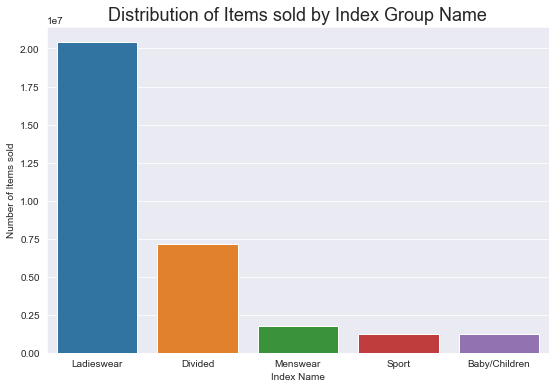

In [113]:
plt.figure(figsize = (9,6))
ax = sns.countplot(x="index_group_name", data=transactions_merged, order = transactions_merged['index_group_name'].value_counts().index)
ax.set_title('Distribution of Items sold by Index Group Name', fontsize=18)
ax.set_xlabel('Index Name')
ax.set_ylabel('Number of Items sold')
plt.show()

In [47]:
transactions_merged['index_group_name'].value_counts() / len(transactions_merged) * 100

Ladieswear       64.222511
Divided          22.455585
Menswear          5.571395
Sport             3.920962
Baby/Children     3.829548
Name: index_group_name, dtype: float64

**The Ladieswear category accounts for 64% of the total number of items sold. Women's cateogories account for 86.67% given that 'Divided' is a category for young female customer.**

In [106]:
# show top product types for each index group
(transactions_merged[transactions_merged['index_group_name'] == 'Ladieswear']
    .groupby(['index_group_name','index_name','section_name','product_type_name']).article_id.count().sort_values(ascending=False) / len(transactions_merged) * 100) [:10]

index_group_name  index_name        section_name                product_type_name
Ladieswear        Ladieswear        Womens Everyday Collection  Trousers             3.702872
                  Lingeries/Tights  Womens Lingerie             Bra                  3.505334
                                    Womens Swimwear, beachwear  Bikini top           3.487302
                                                                Swimwear bottom      3.267986
                  Ladieswear        Womens Everyday Collection  Dress                3.059897
                  Lingeries/Tights  Womens Lingerie             Underwear bottom     2.856627
                  Ladieswear        Womens Everyday Collection  Sweater              2.711272
                                                                Blouse               2.106730
                                                                Top                  1.899160
                                    Womens Everyday Basics      T-shirt 

In [107]:
(transactions_merged[transactions_merged['index_group_name'] == 'Divided']
    .groupby(['index_group_name','index_name','section_name','product_type_name']).article_id.count().sort_values(ascending=False) / len(transactions_merged) * 100) [:10]

index_group_name  index_name  section_name        product_type_name
Divided           Divided     Divided Collection  Trousers             2.485246
                              Ladies Denim        Trousers             2.123280
                              Divided Collection  Dress                1.919721
                                                  Sweater              1.795527
                              Divided Basics      T-shirt              1.082375
                              Divided Collection  T-shirt              0.809546
                                                  Skirt                0.797636
                                                  Vest top             0.594659
                                                  Shirt                0.592469
                              Divided Basics      Vest top             0.531623
Name: article_id, dtype: float64

In [108]:
(transactions_merged[transactions_merged['index_group_name'] == 'Menswear']
    .groupby(['index_group_name','index_name','section_name','product_type_name']).article_id.count().sort_values(ascending=False) / len(transactions_merged) * 100) [:10]

index_group_name  index_name  section_name           product_type_name
Menswear          Menswear    Men Underwear          T-shirt              0.620457
                              Denim Men              Trousers             0.337882
                              Men Underwear          Socks                0.324182
                                                     Hoodie               0.282245
                              Contemporary Smart     Sweater              0.279700
                              Men Suits & Tailoring  Shirt                0.205670
                              Men Underwear          Sweater              0.189415
                                                     Underwear bottom     0.175813
                              Contemporary Street    T-shirt              0.171516
                              Contemporary Smart     Shirt                0.168172
Name: article_id, dtype: float64

In [109]:
(transactions_merged[transactions_merged['index_group_name'] == 'Sport']
    .groupby(['index_group_name','index_name','section_name','product_type_name']).article_id.count().sort_values(ascending=False) / len(transactions_merged) * 100) [:10]

index_group_name  index_name  section_name      product_type_name
Sport             Sport       Ladies H&M Sport  Leggings/Tights      1.124344
                                                Bra                  0.613342
                                                Vest top             0.546414
                                                T-shirt              0.438340
                                                Top                  0.199079
                                                Shorts               0.183747
                                                Hoodie               0.118833
                                                Sweater              0.117383
                                                Trousers             0.092031
                                                Jacket               0.059896
Name: article_id, dtype: float64

In [110]:
(transactions_merged[transactions_merged['index_group_name'] == 'Baby/Children']
    .groupby(['index_group_name','index_name','section_name','product_type_name']).article_id.count().sort_values(ascending=False) / len(transactions_merged) * 100) [:10]

index_group_name  index_name              section_name  product_type_name
Baby/Children     Children Sizes 134-170  Young Boy     Trousers             0.161827
                                          Young Girl    Trousers             0.149413
                                                        Sweater              0.124118
                  Children Sizes 92-140   Kids Girl     Dress                0.121120
                                          Kids Boy      Trousers             0.113422
                  Children Sizes 134-170  Young Boy     T-shirt              0.070991
                                          Young Girl    Leggings/Tights      0.068799
                  Children Sizes 92-140   Kids Boy      Sweater              0.067465
                                          Kids Girl     Sweater              0.064835
                                                        Trousers             0.062602
Name: article_id, dtype: float64

**Across all the index groups except Menswear, trousers are the most sold proudct type, while T-shirt was the most sold product type in Menswear category. Underwear is a popular cateogory, though Socks is more sold than Underwear in Menswear category**

## 1.2 Most Sold Products by Quantity

In [22]:
df1 = transactions_merged['product_code'].value_counts().reset_index()
df1 = df1.rename(columns={'index':'product_code','product_code':'count'})
df1 = pd.merge(df1,transactions_merged[['product_code','prod_name','section_name','product_type_name',]].drop_duplicates('product_code'), how='left', on='product_code')
df1[:30]

product_code   count                    prod_name  \
0         706016  183921     Jade HW Skinny Denim TRS   
1         562245  158557               Luna skinny RW   
2         610776  137799                    Tilly (1)   
3         599580  122143       Timeless Midrise Brief   
4         717490   81304                     Cat Tee.   
5         695632   75867                        Gyda-   
6         684209   74827  Simple as That Triangle Top   
7         372860   73456           7p Basic Shaftless   
8         759871   68891                   Tilda tank   
9         573085   68241        Madison skinny HW (1)   
10        554450   67103    Julia RW Skinny Denim TRS   
11        399223   66253                 Jeggings H.W   
12        688537   64603  Simple as that Cheeky Tanga   
13        554598   64497                 Nora T-shirt   
14        751471   64305          Pluto RW slacks (1)   
15        399256   64118    Skinny Ankle R.W Brooklyn   
16        573716   57636                 Kanta slacks   
17        783346   56814                 Primo slacks   
18        778064   56039                     Claudine   
19        685816   55446         RONNY REG RN T-SHIRT   
20        568601   54648                     Mariette   
21        720125   53357            SUPREME RW tights   
22        685814   51651                  RICHIE HOOD   
23        697054   50016                    Despacito   
24        624486   49059                Brit Baby Tee   
25        448509   48114    Perrie Slim Mom Denim TRS   
26        351484   47729        LAZER RAZER brief (1)   
27        673677   47634              Henry polo. (1)   
28        579541   47632            Calista cardigan.   
29        399087   47098        Super Skinny L.W Epic   

                      section_name product_type_name  
0               Divided Collection          Trousers  
1       Womens Everyday Collection          Trousers  
2           Womens Everyday Basics           T-shirt  
3       Womens Swimwear, beachwear   Swimwear bottom  
4                   Divided Basics           T-shirt  
5                 Womens Tailoring            Blouse  
6       Womens Swimwear, beachwear        Bikini top  
7   Womens Nightwear, Socks & Tigh             Socks  
8                   Divided Basics          Vest top  
9       Womens Everyday Collection          Trousers  
10              Divided Collection          Trousers  
11                    Ladies Denim          Trousers  
12      Womens Swimwear, beachwear   Swimwear bottom  
13          Womens Everyday Basics           T-shirt  
14      Womens Everyday Collection          Trousers  
15                    Ladies Denim          Trousers  
16      Womens Everyday Collection          Trousers  
17      Womens Everyday Collection          Trousers  
18          Womens Everyday Basics           T-shirt  
19                   Men Underwear           T-shirt  
20                Womens Tailoring            Blazer  
21                Ladies H&M Sport   Leggings/Tights  
22                   Men Underwear            Hoodie  
23      Womens Everyday Collection            Blouse  
24                  Divided Basics           T-shirt  
25              Divided Collection          Trousers  
26      Womens Swimwear, beachwear   Swimwear bottom  
27                Womens Tailoring           Sweater  
28                Womens Tailoring          Cardigan  
29                    Ladies Denim          Trousers

**There are more products from Divided collection among the most sold products, though the product types in Divided are sold less than those in Ladies wear. It shows that the sales in Divided section is more concentrated to certain products while the sales in Ladieswear are more distributed.**

## 1.3 How similar are articles sold in certain period of time?

I guess that there will be a seasonality in sales data because of promotion or something like that. There are more than 100,000 articles and we can make 12 recommendations. I guess that there will be limited number of articles sold in certain period such as in a week or in a month. If so, I will see how articles sold in previous period are related to the articles sold the next week. and if both are true, I will cluster customers and make recommendations according to their cluster and 'trendy' articles. I'm going to measure the similarity using various metrics

### 1.3.1 Similarity?? why? how do we measure?

Cosine similarity. maximum value is 1

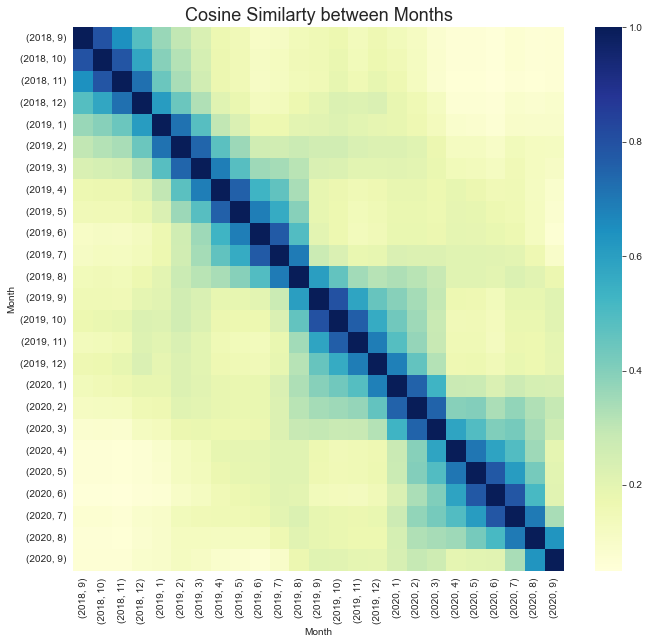

In [229]:
from sklearn.metrics.pairwise import cosine_similarity
# group df by month
group_month = transactions_merged.groupby(['year','month','article_id'])['customer_id'].count().unstack(2)
group_month_idx = group_month.index
group_month = group_month.fillna(0).to_numpy()

# calculate cosine similarity matrix
mat_cos_month = list()
for vec_1 in group_month:
    for vec_2 in group_month:
        mat_cos_month.append(cosine_similarity([vec_1],[vec_2]))
mat_cos_month = np.array(mat_cos_month).reshape((25,25))

# plot the result
fig, ax = plt.subplots(figsize=(11,10))
ax = sns.heatmap(mat_cos_month, cmap="YlGnBu",xticklabels = group_month_idx , yticklabels = group_month_idx)
ax.set_title('Cosine Similarty between Months', fontsize=18)
ax.set_xlabel('Month')
ax.set_ylabel('Month')
plt.show()

**As the color is darker and bluer, they are more similar. We can see that closer the months are, the more similar they are. Also, we see that the color gets bluer in the middle. It seems that due to the seasonality, the similarity increases though they are farther from the point of comparison.**

In [259]:
transactions_merged[transactions_merged['week']==24]

t_dat                                        customer_id  \
11606467 2019-06-10  00040239317e877c77ac6e79df42eb2633ad38fcac09fc...   
11606468 2019-06-10  00040239317e877c77ac6e79df42eb2633ad38fcac09fc...   
11606469 2019-06-10  00040239317e877c77ac6e79df42eb2633ad38fcac09fc...   
11606470 2019-06-10  00040239317e877c77ac6e79df42eb2633ad38fcac09fc...   
11606471 2019-06-10  00040239317e877c77ac6e79df42eb2633ad38fcac09fc...   
...             ...                                                ...   
27244203 2020-06-14  ffe1dc63491a0bb1dfa973a5066f5069605ad135c40378...   
27244204 2020-06-14  fff289640860f5d0783ce156f0f6c043d46fff0ca53875...   
27244205 2020-06-14  fff289640860f5d0783ce156f0f6c043d46fff0ca53875...   
27244206 2020-06-14  fff2c4204fac63f93aec10ed657958d372efe948de1492...   
27244207 2020-06-14  fff2c4204fac63f93aec10ed657958d372efe948de1492...   

          article_id     price  sales_channel_id  year  month  product_code  \
11606467   765926001  0.033875                 2  2019      6        765926   
11606468   765926001  0.033875                 2  2019      6        765926   
11606469   719639003  0.033875                 2  2019      6        719639   
11606470   719639003  0.033875                 2  2019      6        719639   
11606471   554598047  0.016937                 2  2019      6        554598   
...              ...       ...               ...   ...    ...           ...   
27244203   862325001  0.042358                 1  2020      6        862325   
27244204   399087014  0.025406                 2  2020      6        399087   
27244205   399087021  0.033875                 2  2020      6        399087   
27244206   826211001  0.013542                 1  2020      6        826211   
27244207   470789031  0.016937                 1  2020      6        470789   

                             prod_name  product_type_no  ... index_code  \
11606467                       Gjelina              265  ...          A   
11606468                       Gjelina              265  ...          A   
11606469  Davos paper-bag waist shorts              274  ...          A   
11606470  Davos paper-bag waist shorts              274  ...          A   
11606471                  Nora T-shirt              255  ...          A   
...                                ...              ...  ...        ...   
27244203                      Felix HW              272  ...          A   
27244204             S.Skinny L.W Epic              272  ...          D   
27244205             S.Skinny L.W Epic              272  ...          D   
27244206               Kiwi sweatshirt              252  ...          D   
27244207  OP Brazilian 2p Low (Acacia)              286  ...          B   

                index_name  index_group_no index_group_name  section_no  \
11606467        Ladieswear               1       Ladieswear          16   
11606468        Ladieswear               1       Ladieswear          16   
11606469        Ladieswear               1       Ladieswear           6   
11606470        Ladieswear               1       Ladieswear           6   
11606471        Ladieswear               1       Ladieswear          16   
...                    ...             ...              ...         ...   
27244203        Ladieswear               1       Ladieswear          15   
27244204           Divided               2          Divided          57   
27244205           Divided               2          Divided          57   
27244206           Divided               2          Divided          53   
27244207  Lingeries/Tights               1       Ladieswear          61   

                        section_name  garment_group_no garment_group_name  \
11606467      Womens Everyday Basics              1002       Jersey Basic   
11606468      Womens Everyday Basics              1002       Jersey Basic   
11606469               Womens Casual              1025             Shorts   
11606470               Womens Casual              1025            

In [ ]:
# add week of the year to df
transactions_merged['week'] = pd.DatetimeIndex(transactions_merged.t_dat).week

# group df by week of the year
group_week = transactions_merged.groupby(['year','week','article_id'])['customer_id'].count().unstack(2)
group_week_idx = group_week.index
group_week = group_week.fillna(0).to_numpy()

# calculate cosine similarity matrix
mat_cos_week = list()
for vec_1 in group_week:
    for vec_2 in group_week:
        mat_cos_week.append(cosine_similarity([vec_1],[vec_2]))
mat_cos_week = np.array(mat_cos_week).reshape((len(group_week_idx),len(group_week_idx)))

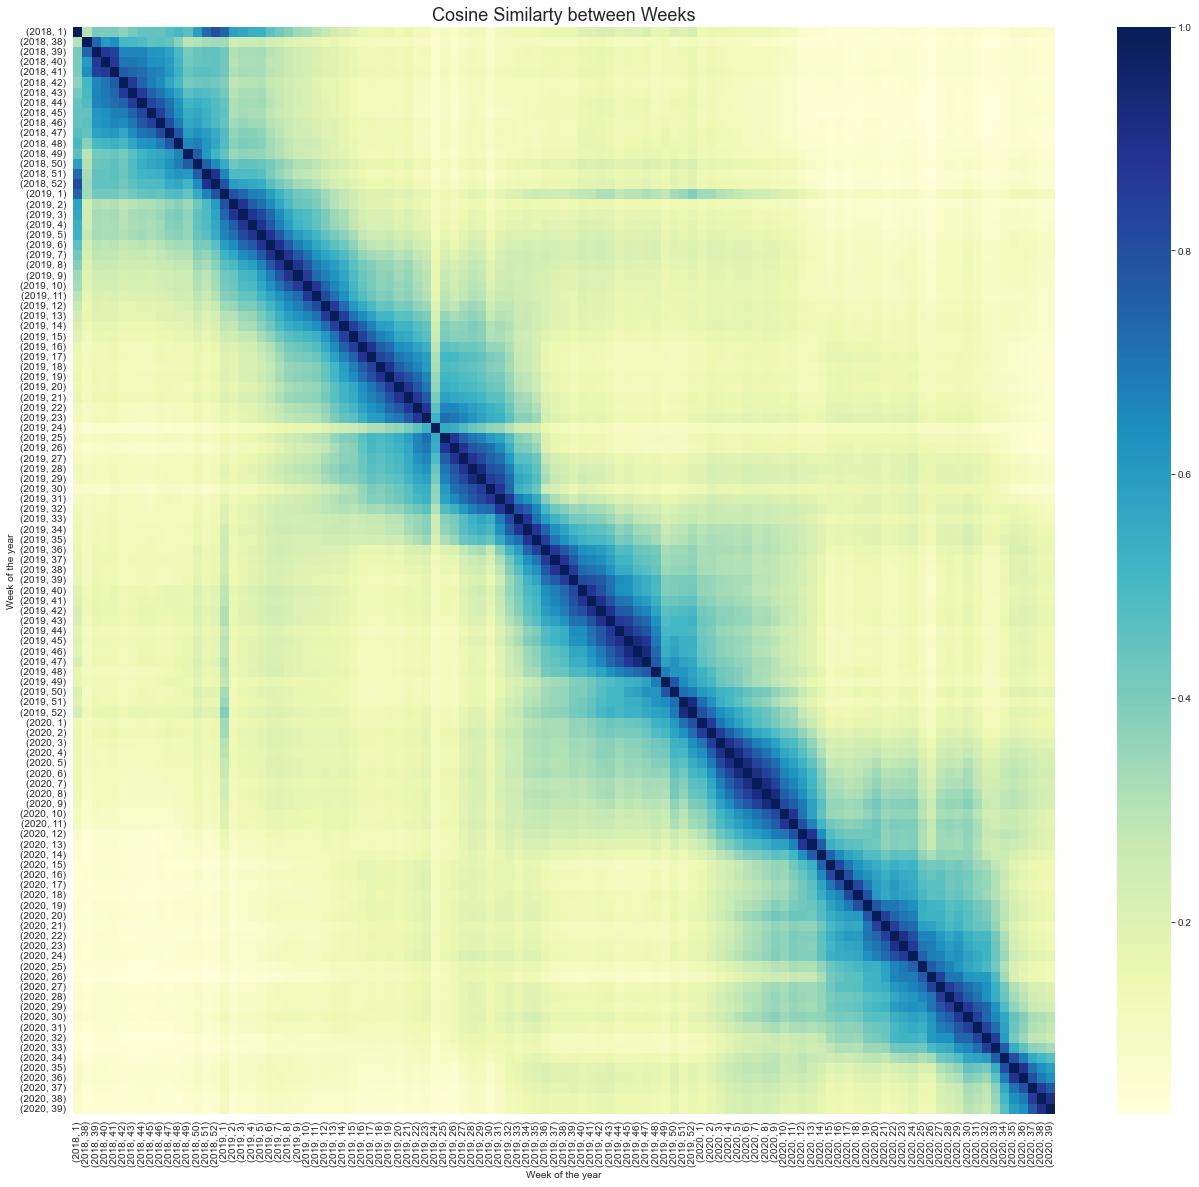

In [244]:
# plot the result
fig, ax = plt.subplots(figsize=(22,20))
ax = sns.heatmap(mat_cos_week, cmap="YlGnBu",xticklabels = group_week_idx , yticklabels = group_week_idx)
ax.set_title('Cosine Similarty between Weeks', fontsize=18)
ax.set_xlabel('Week of the year')
ax.set_ylabel('Week of the year')
plt.show()

**As shown above, the next week's composition of articles sold is very related to the previous week's composition. That is, we can assume that the distribution of various customer segments are similar and their shopping pattern is similar. I will find clusters and assign recs**

## Clustering

- what metric do we use?
- standardize or no?

### Cluster in index group level

In [11]:
customer_group_index_group = transactions_merged.groupby(['customer_id','index_group_name'])['sales_channel_id'].count()

In [270]:
customer_group_index_group = customer_group_index_group.unstack(1)

#### Standardize

In [281]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
customers_grouped_standardized = scaler.fit_transform(customer_group_index_group)

In [ ]:
import time
from sklearn.cluster import MiniBatchKMeans, KMeans

for n_cluster in [2,3,4,5]:
    clusterer = KMeans(n_clusters=n_cluster, random_state=10)
    t0 = time.time()
    cluster_labels = clusterer.fit_predict(customers_grouped_standardized)
    
    
    silhouette_avg = metrics.silhouette_score(customers_grouped_standardized, cluster_labels, sample_size = 50000, random_state = 46531)
    print(
        "For n_clusters =",
        n_cluster,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    t_elapsed = time.time() - t0
    print(n_cluster,": ",t_elapsed)

random_state = 937, sample_size = 50000
For n_clusters = 2 The average silhouette_score is : 0.7323860768439158
2 :  46.259992599487305
For n_clusters = 3 The average silhouette_score is : 0.7128665107024376
3 :  58.89199614524841
For n_clusters = 4 The average silhouette_score is : 0.6008475744585634
4 :  69.70900821685791
For n_clusters = 5 The average silhouette_score is : 0.5859073757721333
5 :  76.80296158790588
For n_clusters = 6 The average silhouette_score is : 0.5692191196014669
6 :  83.94700026512146

random_state = 46531, sample_size = 50000
For n_clusters = 2 The average silhouette_score is : 0.7356842742067995
2 :  46.8680362701416
For n_clusters = 3 The average silhouette_score is : 0.7153944932806591
3 :  58.995004415512085
For n_clusters = 4 The average silhouette_score is : 0.6016854332906132
4 :  72.34197402000427
For n_clusters = 5 The average silhouette_score is : 0.5862203097343789
5 :  78.24302434921265

**The results show that these features are not the best for clustering. I will try other features such as index_name. This might be due to very skewed data**

### Cluster with

In [7]:
# %%time
# customer_group_section = transactions_merged.groupby(['customer_id','index_group_name','index_name','section_name']).sales_channel_id.count().compute()
# customer_group_section = customer_group_section.unstack([1,2,3])
# # customer_group_section = customer_group_section.fillna(0)

Wall time: 3min 41s


In [9]:
%%time
customer_grouped = transactions_merged.groupby(['customer_id','index_group_name']).sales_channel_id.count().compute()
customer_grouped = customer_grouped.unstack(-1)

Wall time: 3min 11s


<AxesSubplot:>

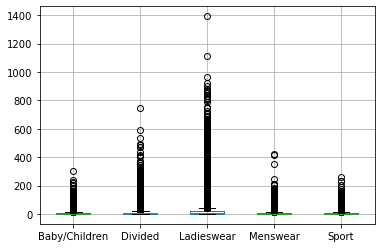

In [15]:
customer_grouped.boxplot()

In [22]:
df2 = transactions_merged[transactions_merged['index_group_name']=='Ladieswear'].groupby(['customer_id','index_name']).sales_channel_id.count().compute()
df2 = df2.unstack(-1)

<AxesSubplot:>

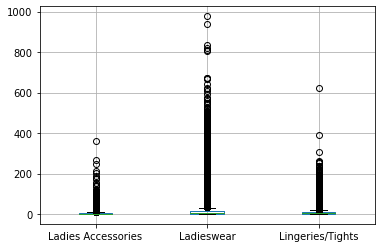

In [24]:
df2.boxplot()

<AxesSubplot:>

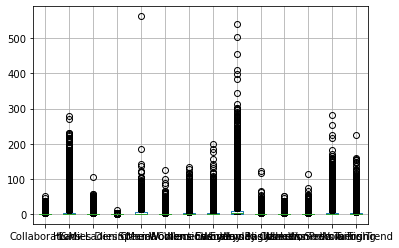

In [25]:
df3 = transactions_merged[transactions_merged['index_name']=='Ladieswear'].groupby(['customer_id','section_name']).sales_channel_id.count().compute().unstack(-1)
df3.boxplot()

In [26]:
customer_group_merged  = customer_grouped.drop(columns='Ladieswear').join(df2.drop(columns='Ladieswear'), how='outer',rsuffix = 'index').join(df3, how='outer',rsuffix = 'section')
customer_group_merged = customer_group_merged.fillna(0)
customer_group_merged['total'] = customer_group_merged.sum(axis=1)

for c in customer_group_merged.columns:
    customer_group_merged[c] /= customer_group_merged['total']
customer_group_merged = customer_group_merged.drop(columns=['total'])

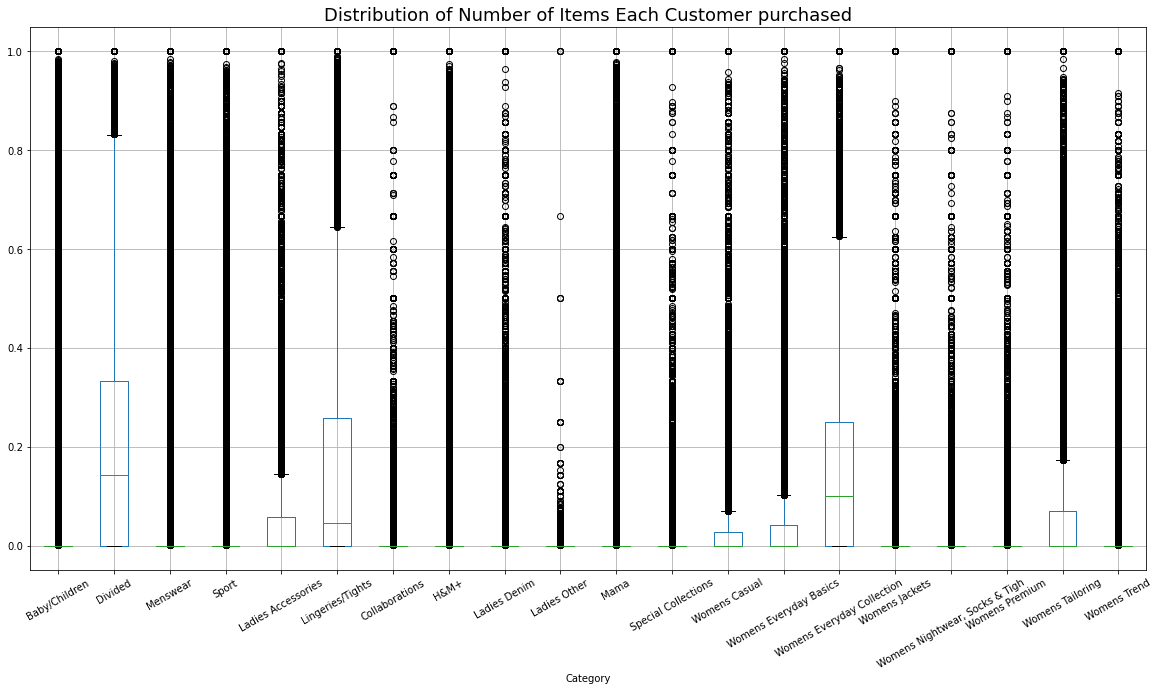

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
ax = customer_group_merged.boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_title('Distribution of Number of Items Each Customer purchased',fontsize=18)
ax.set_xlabel('Category')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.002464900728502913
2 :  73.75829744338989
For n_clusters = 3 The average silhouette_score is : 0.25976658075469305
3 :  81.42850494384766
For n_clusters = 4 The average silhouette_score is : 0.1606955300556549
4 :  79.94682836532593
For n_clusters = 5 The average silhouette_score is : 0.15176528910484635
5 :  82.08893942832947
For n_clusters = 6 The average silhouette_score is : 0.09214959207114716
6 :  101.35543394088745
For n_clusters = 7 The average silhouette_score is : 0.13465702433905583
7 :  94.05757093429565
For n_clusters = 8 The average silhouette_score is : 0.1562937230764895
8 :  103.20180082321167
For n_clusters = 9 The average silhouette_score is : 0.1764527757768937
9 :  115.86474061012268
For n_clusters = 10 The average silhouette_score is : 0.1754879212460495
10 :  105.022465467453
For n_clusters = 11 The average silhouette_score is : 0.17744960234744814
11 :  113.97285842895508
For n_clusters = 12 The average silh

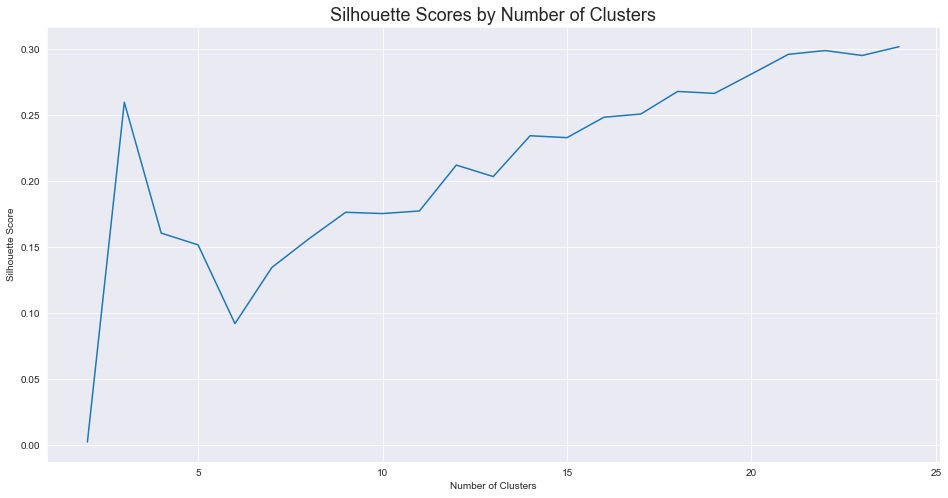

In [348]:
import time
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
import matplotlib.cm as cm


# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

# convert the df to numpy array to increase the speed
customer_group_merged_np = np.array(customer_group_merged)
scaler = StandardScaler()
customers_grouped_standardized = scaler.fit_transform(customer_group_merged_np)

train = customers_grouped_standardized
# sample rows for faster silhouette calculation
number_of_samples = 70000
np.random.seed(47)
sample_indices = np.random.choice(customer_group_merged.shape[0], number_of_samples, replace=False)
X = train[sample_indices]
range_n_clusters = range(2,25)
sil_scores = list()
for n_clusters in range_n_clusters:
    t0 = time.time()

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=47)
    cluster_labels = clusterer.fit_predict(train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    labels_sampled = cluster_labels[sample_indices]
    silhouette_avg_sampled = silhouette_score(X, labels_sampled)
    # append the result to plot later
    sil_scores.append(silhouette_avg_sampled)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg_sampled,
    )
    t_elapsed = time.time() - t0
    print(n_clusters,": ",t_elapsed)

df_sil_scores = pd.DataFrame([range_n_clusters,sil_scores]).T
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.lineplot(data=df_sil_scores, x=0, y=1)
ax.set_title('Silhouette Scores by Number of Clusters', fontsize=18)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.15003498081614972
2 :  80.11712884902954
For n_clusters = 3 The average silhouette_score is : 0.19932815410739857
3 :  97.33029890060425
For n_clusters = 4 The average silhouette_score is : 0.20366042055806188
4 :  105.62183332443237
For n_clusters = 5 The average silhouette_score is : 0.23219238605047443
5 :  108.30610632896423
For n_clusters = 6 The average silhouette_score is : 0.2612343478046832
6 :  105.8988950252533
For n_clusters = 7 The average silhouette_score is : 0.27978898306146693
7 :  103.81834864616394
For n_clusters = 8 The average silhouette_score is : 0.28754324205559034
8 :  132.12569403648376
For n_clusters = 9 The average silhouette_score is : 0.3089009627637916
9 :  146.61197471618652
For n_clusters = 10 The average silhouette_score is : 0.28250408653302495
10 :  137.50515818595886
For n_clusters = 11 The average silhouette_score is : 0.2809754107668786
11 :  150.98956871032715
For n_clusters = 12 The average 

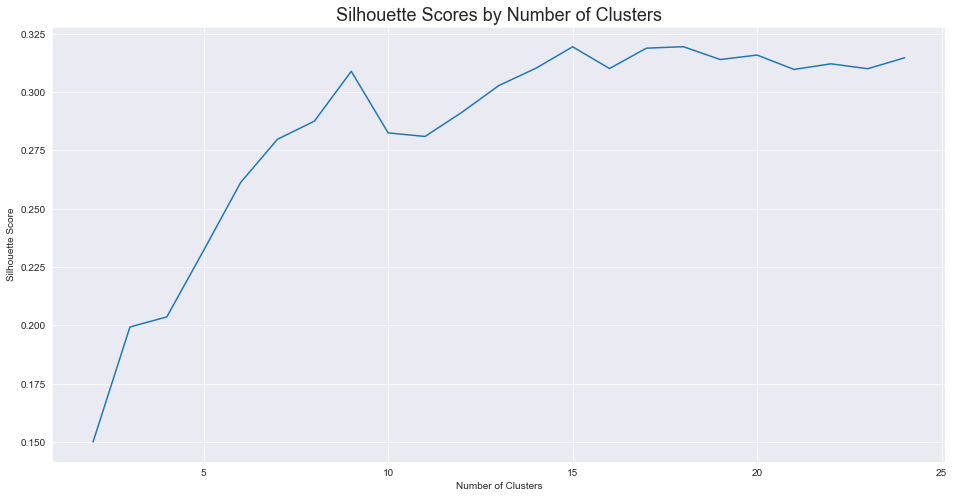

In [349]:
import time
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
import matplotlib.cm as cm


# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

# convert the df to numpy array to increase the speed
customer_group_merged_np = np.array(customer_group_merged)


train = customer_group_merged_np
# sample rows for faster silhouette calculation
number_of_samples = 70000
np.random.seed(47)
sample_indices = np.random.choice(customer_group_merged.shape[0], number_of_samples, replace=False)
X = train[sample_indices]
range_n_clusters = range(2,25)
sil_scores = list()
for n_clusters in range_n_clusters:
    t0 = time.time()

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=47)
    cluster_labels = clusterer.fit_predict(train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    labels_sampled = cluster_labels[sample_indices]
    silhouette_avg_sampled = silhouette_score(X, labels_sampled)
    # append the result to plot later
    sil_scores.append(silhouette_avg_sampled)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg_sampled,
    )
    t_elapsed = time.time() - t0
    print(n_clusters,": ",t_elapsed)

df_sil_scores = pd.DataFrame([range_n_clusters,sil_scores]).T
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.lineplot(data=df_sil_scores, x=0, y=1)
ax.set_title('Silhouette Scores by Number of Clusters', fontsize=18)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
plt.show()

For n_clusters = 7 The average silhouette_score is : 0.27978898306146693
7 :  97.52676630020142
For n_clusters = 8 The average silhouette_score is : 0.28754324205559034
8 :  106.84427547454834
For n_clusters = 9 The average silhouette_score is : 0.3089009627637916
9 :  122.42703795433044
For n_clusters = 10 The average silhouette_score is : 0.28250408653302495
10 :  108.98444080352783
For n_clusters = 11 The average silhouette_score is : 0.2809754107668786
11 :  120.52503657341003
For n_clusters = 12 The average silhouette_score is : 0.2913535627528648
12 :  132.55660271644592
For n_clusters = 13 The average silhouette_score is : 0.3028045151984825
13 :  117.04070448875427
For n_clusters = 14 The average silhouette_score is : 0.31016869154150295
14 :  130.24772191047668
For n_clusters = 15 The average silhouette_score is : 0.31939952944568006
15 :  132.73362255096436
For n_clusters = 16 The average silhouette_score is : 0.3100918092166785
16 :  155.85230803489685
For n_clusters = 17 Th

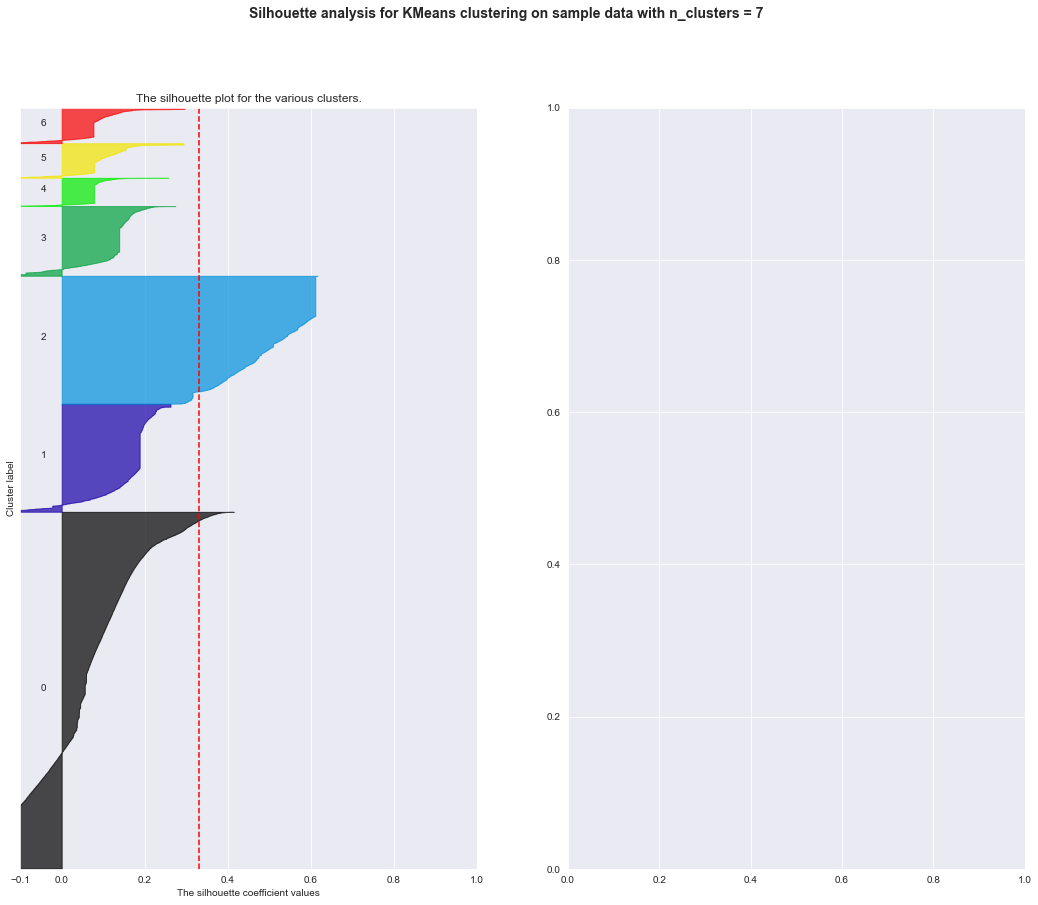

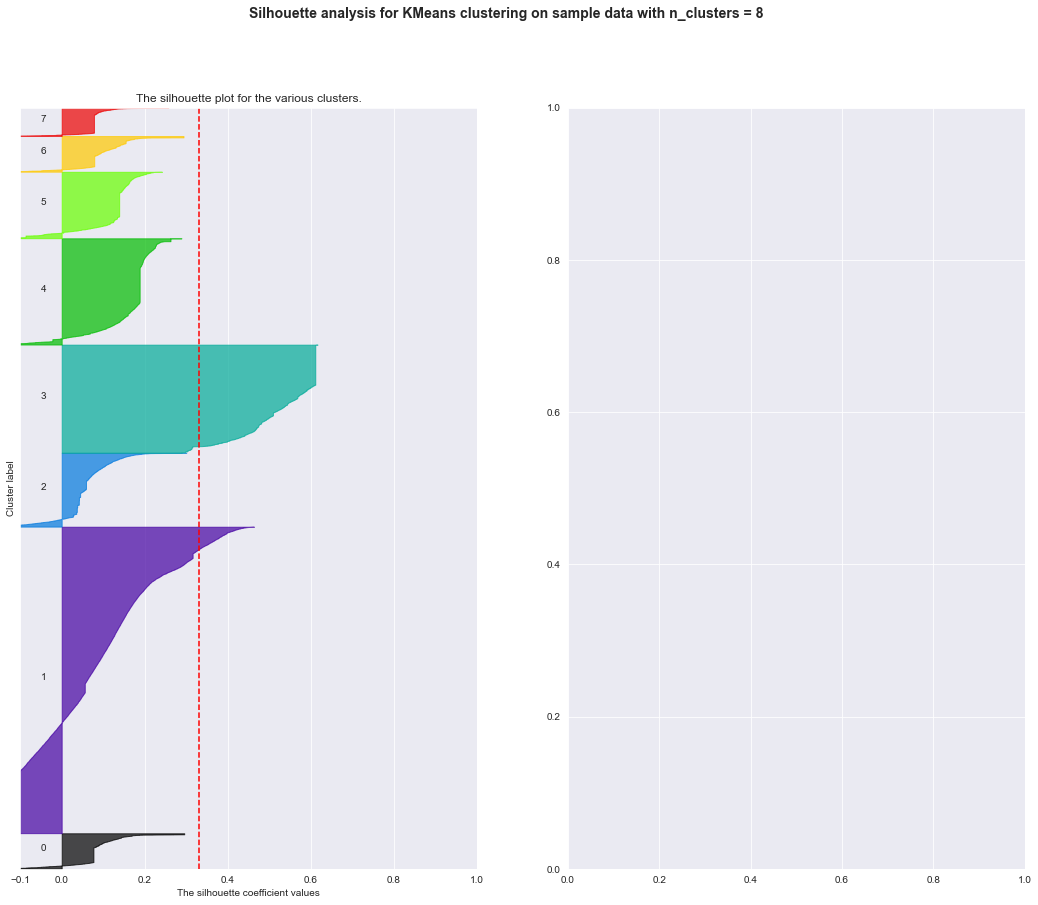

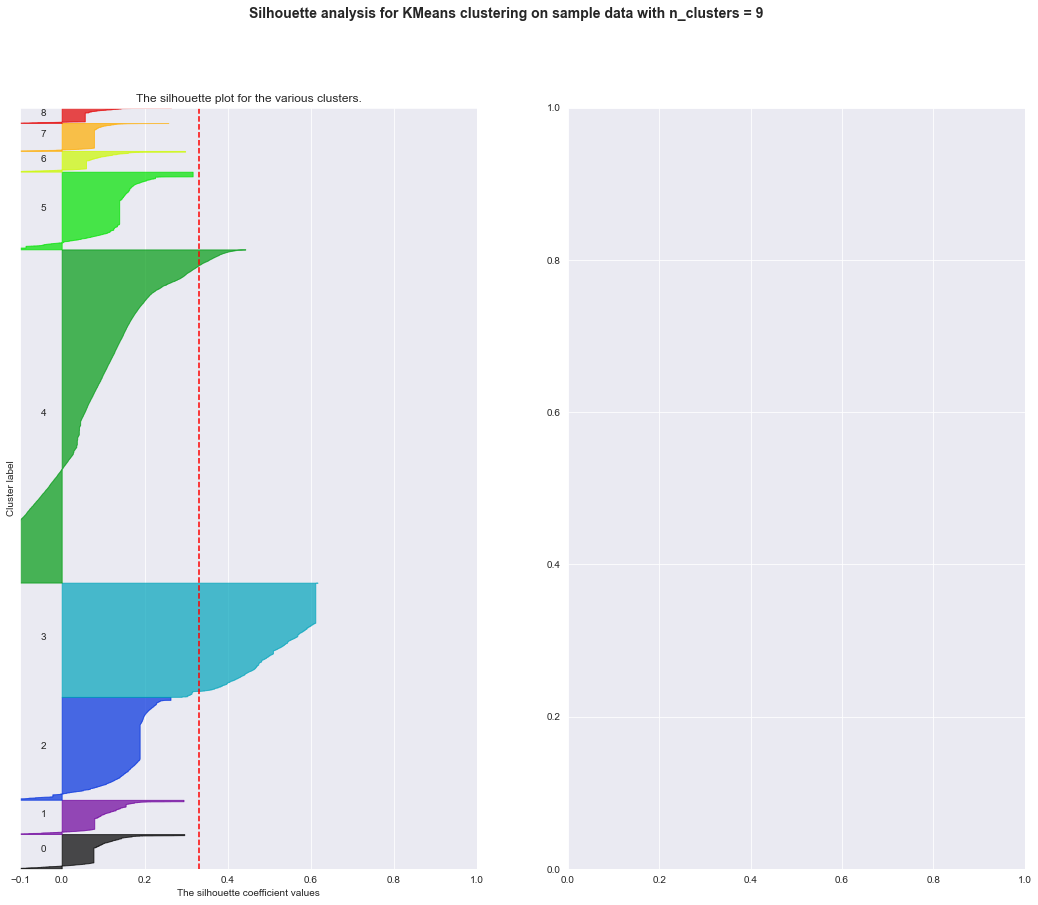

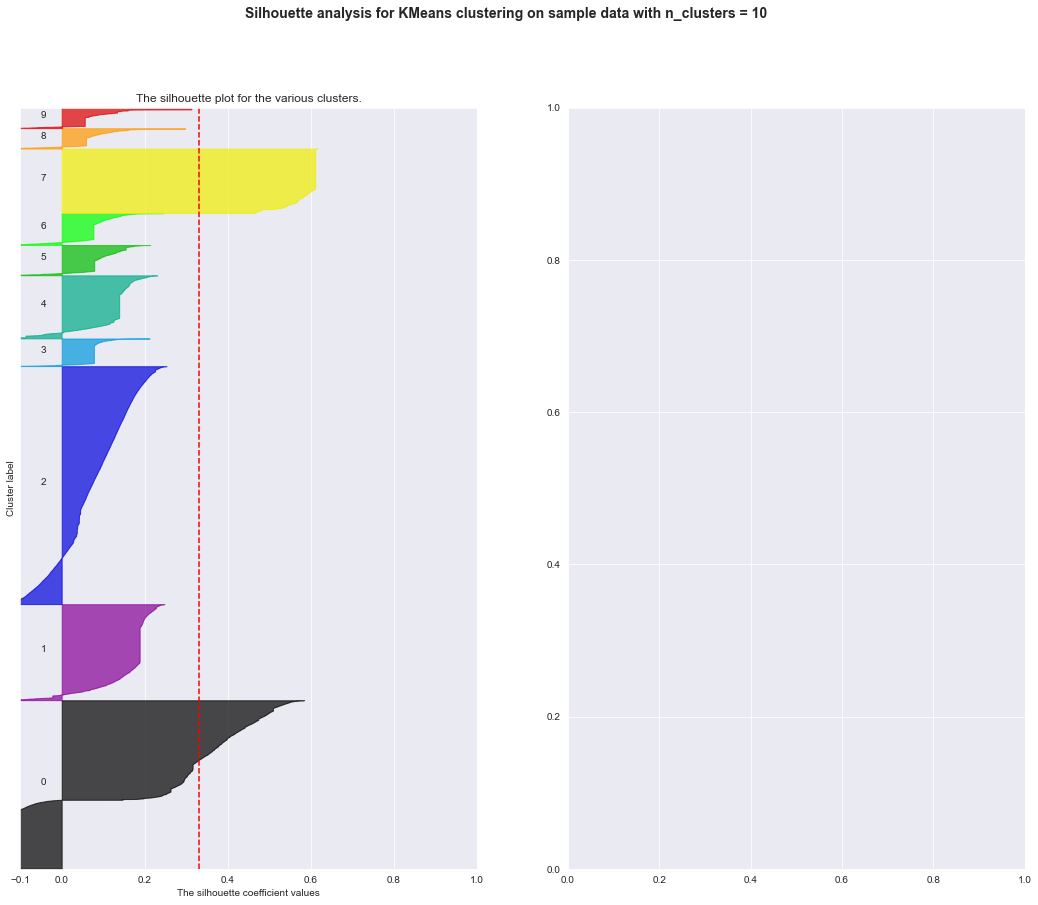

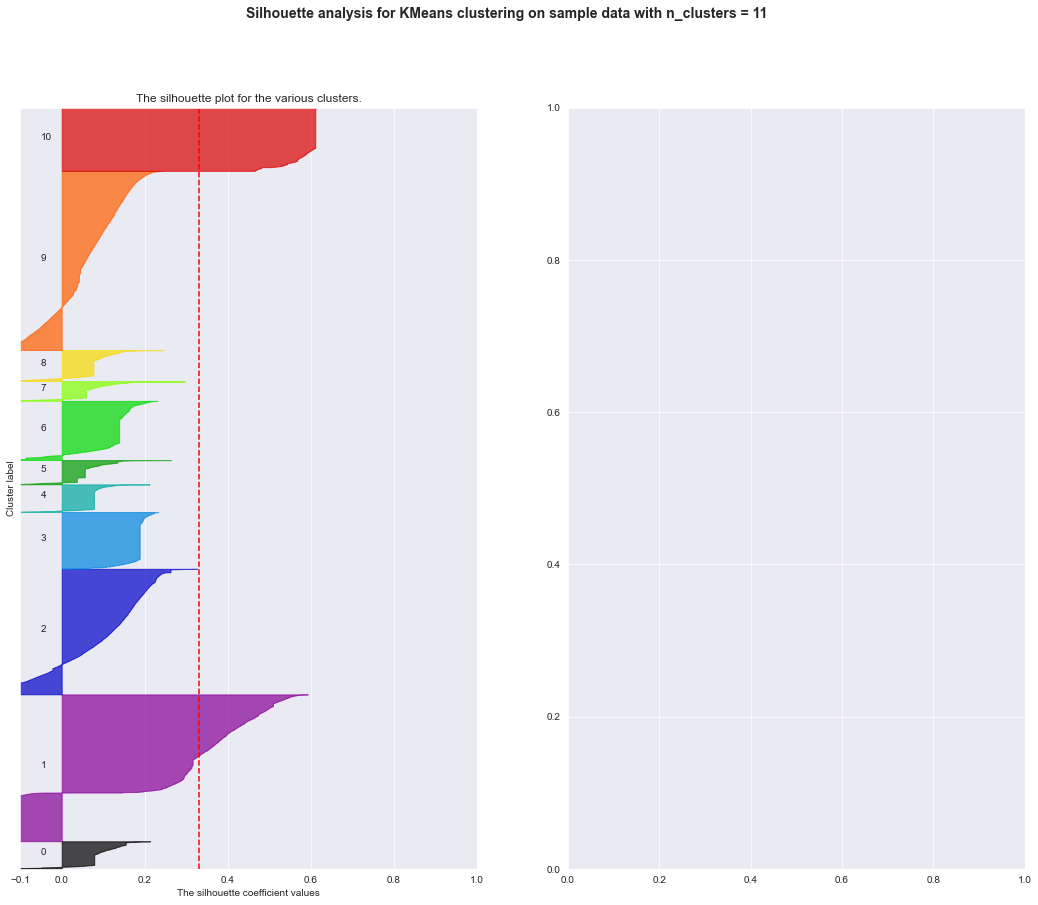

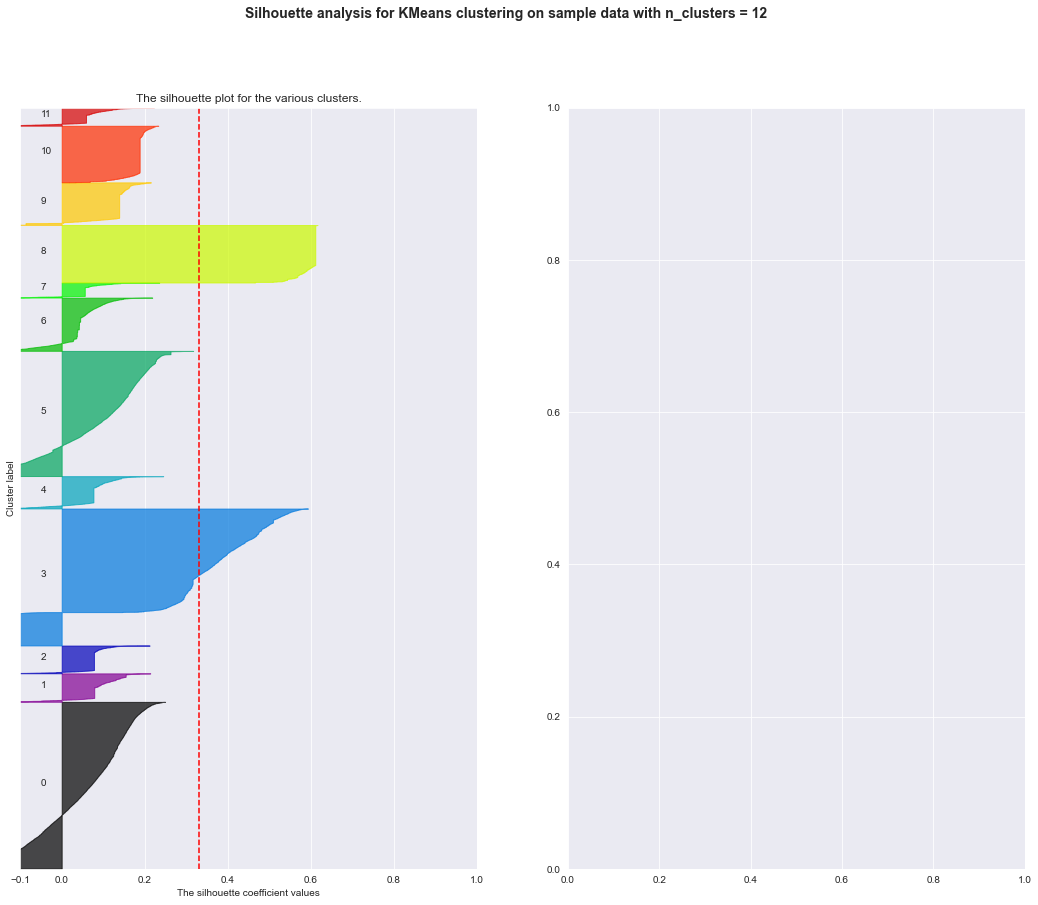

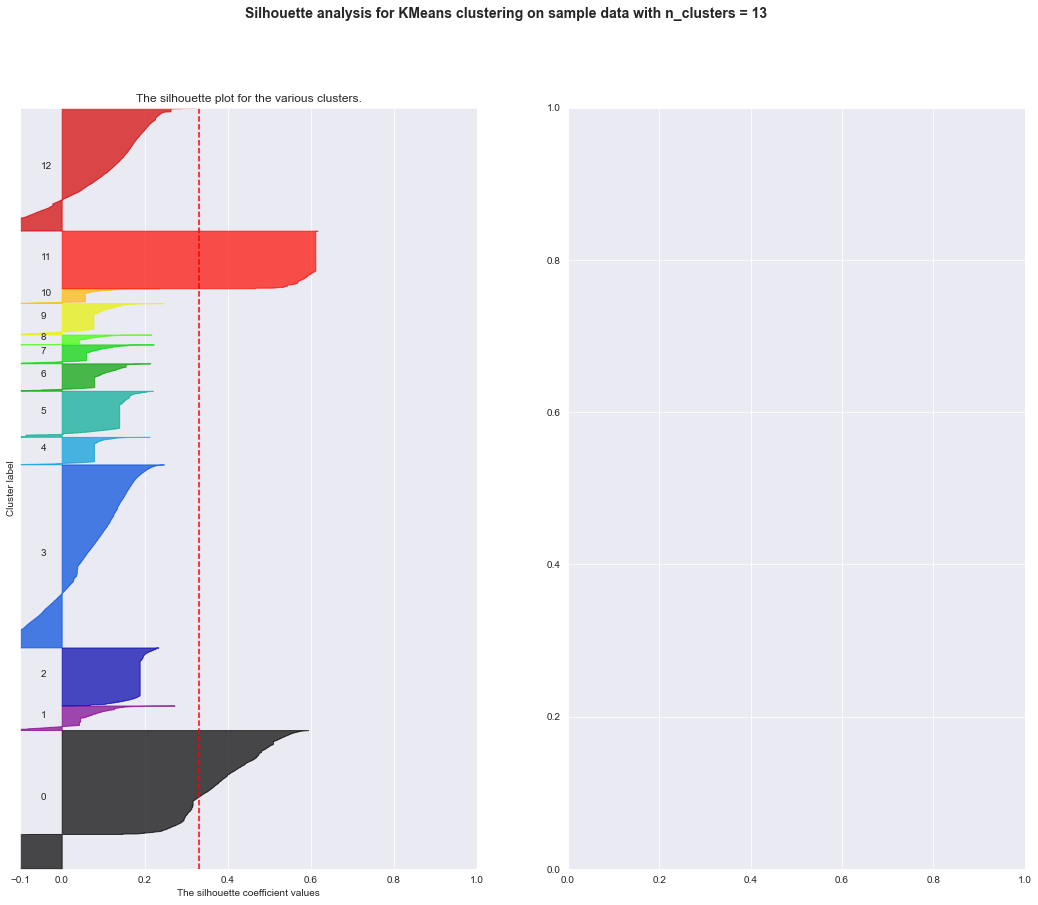

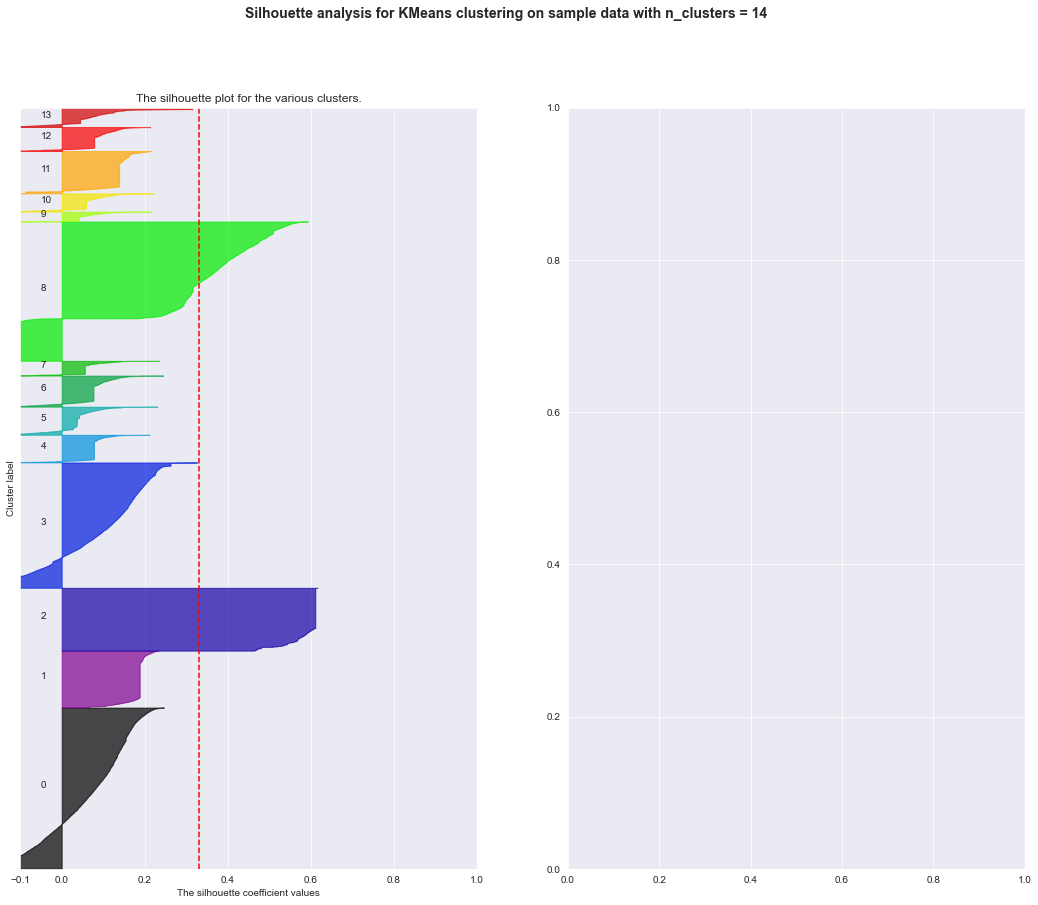

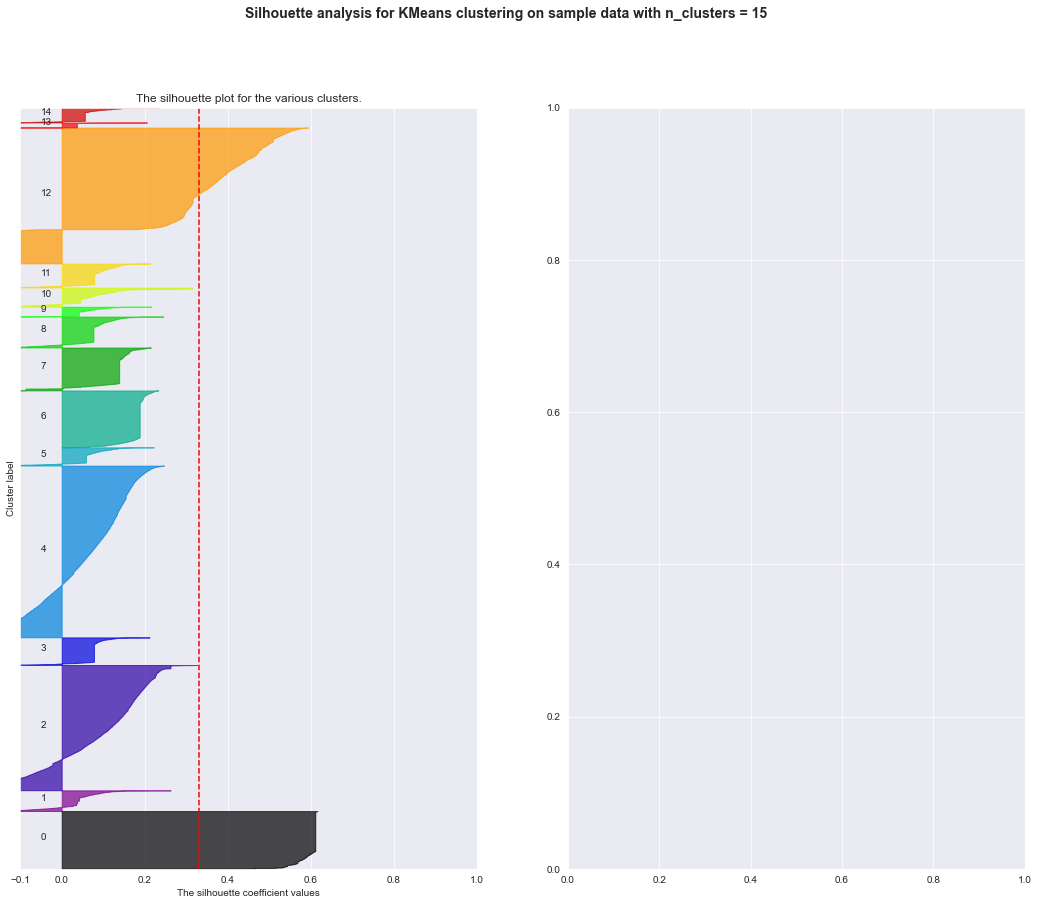

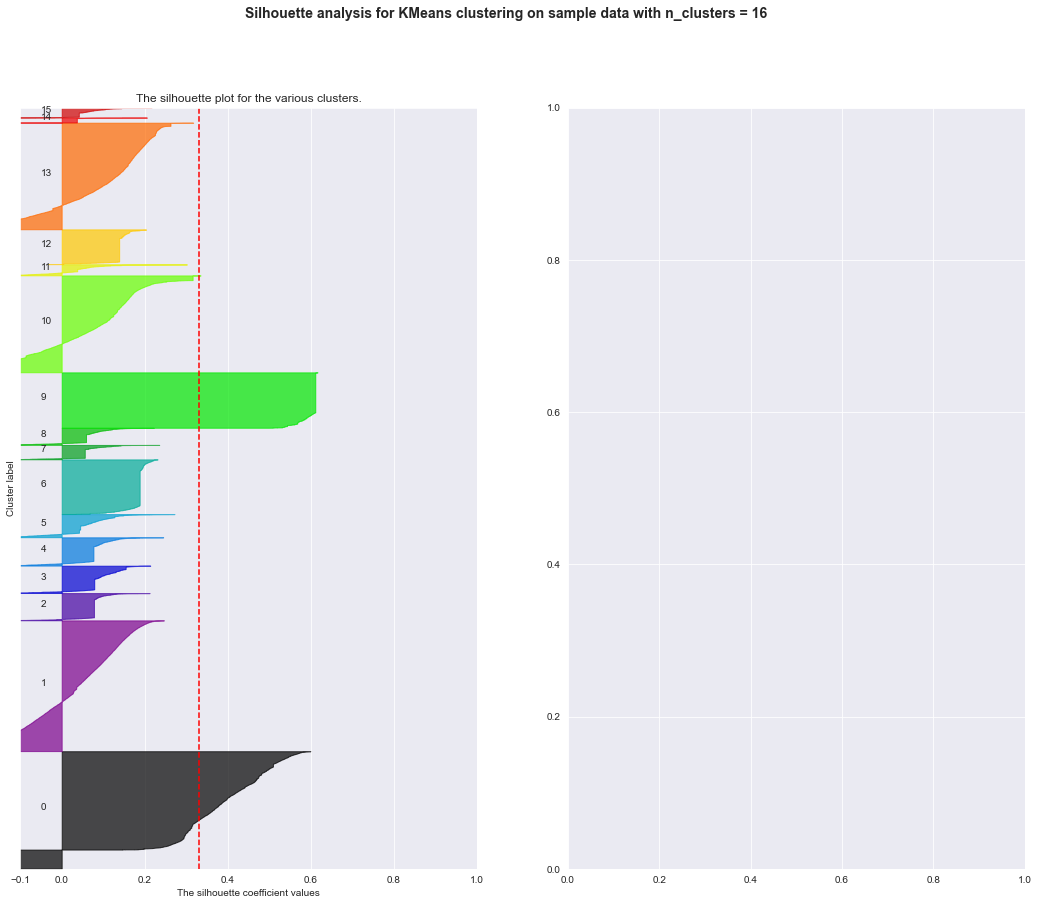

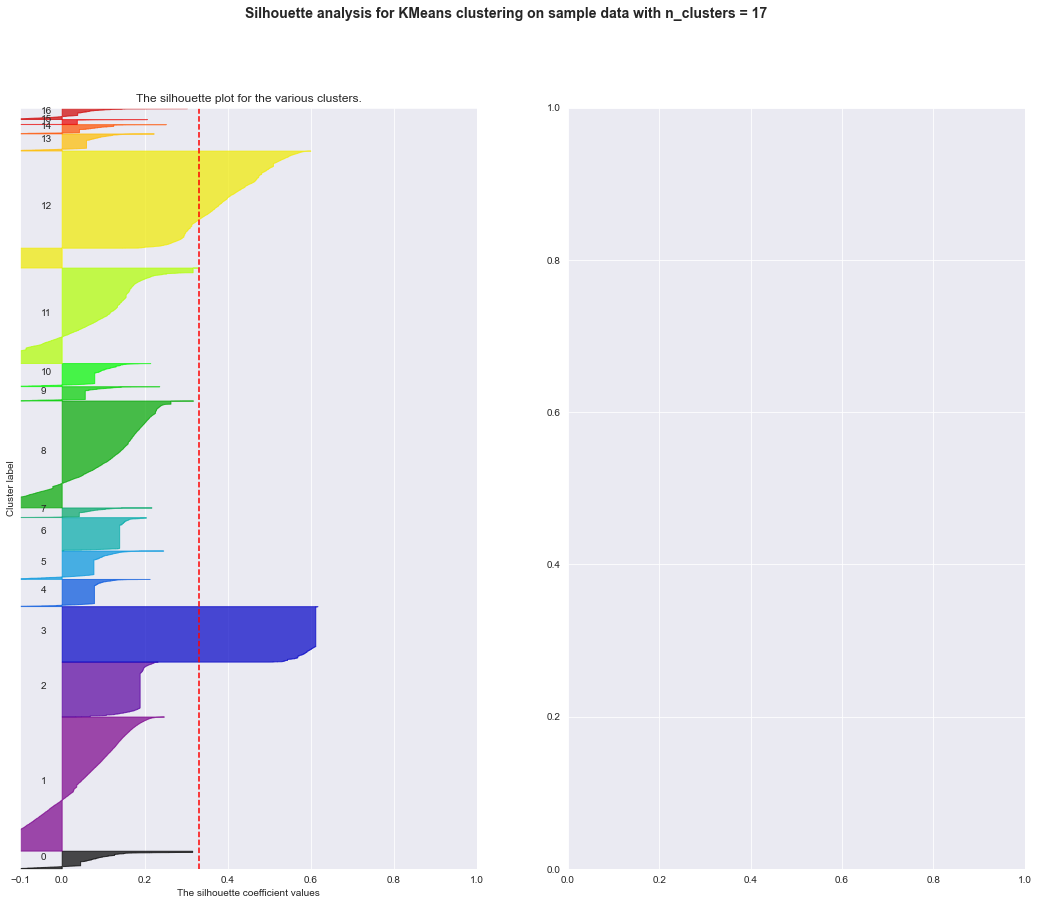

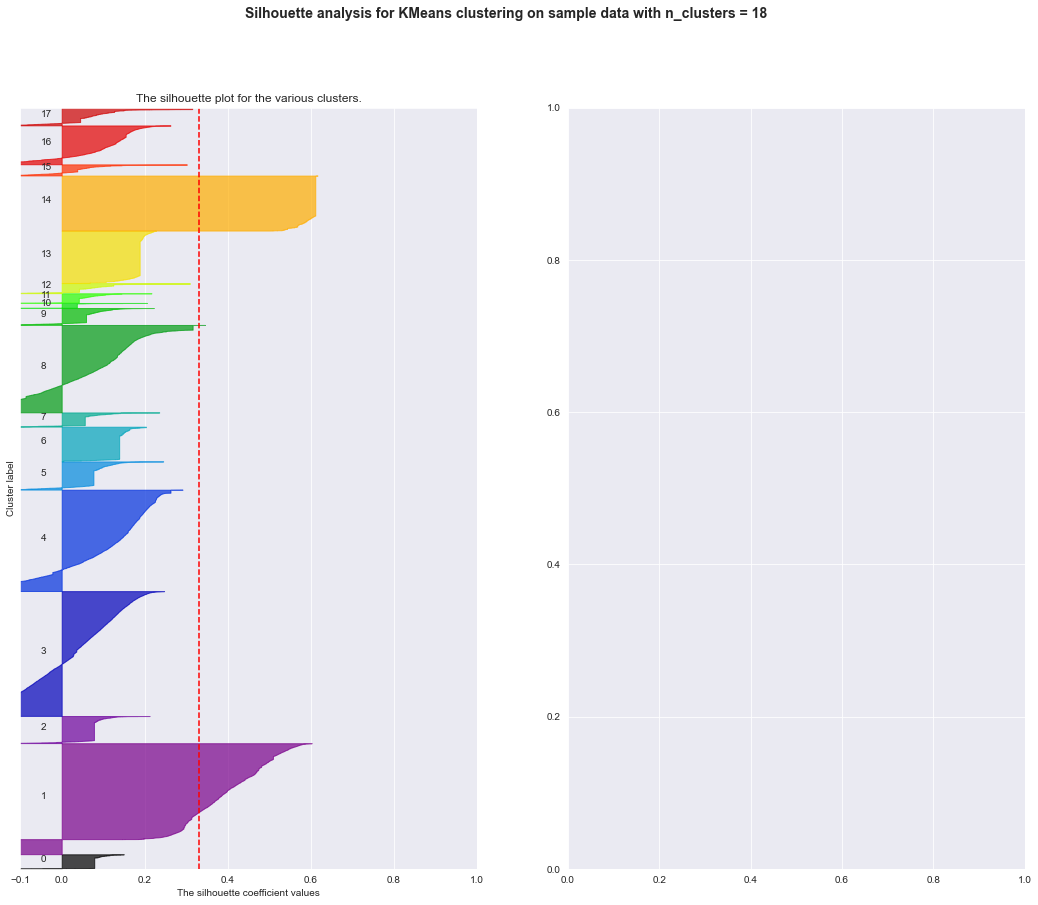

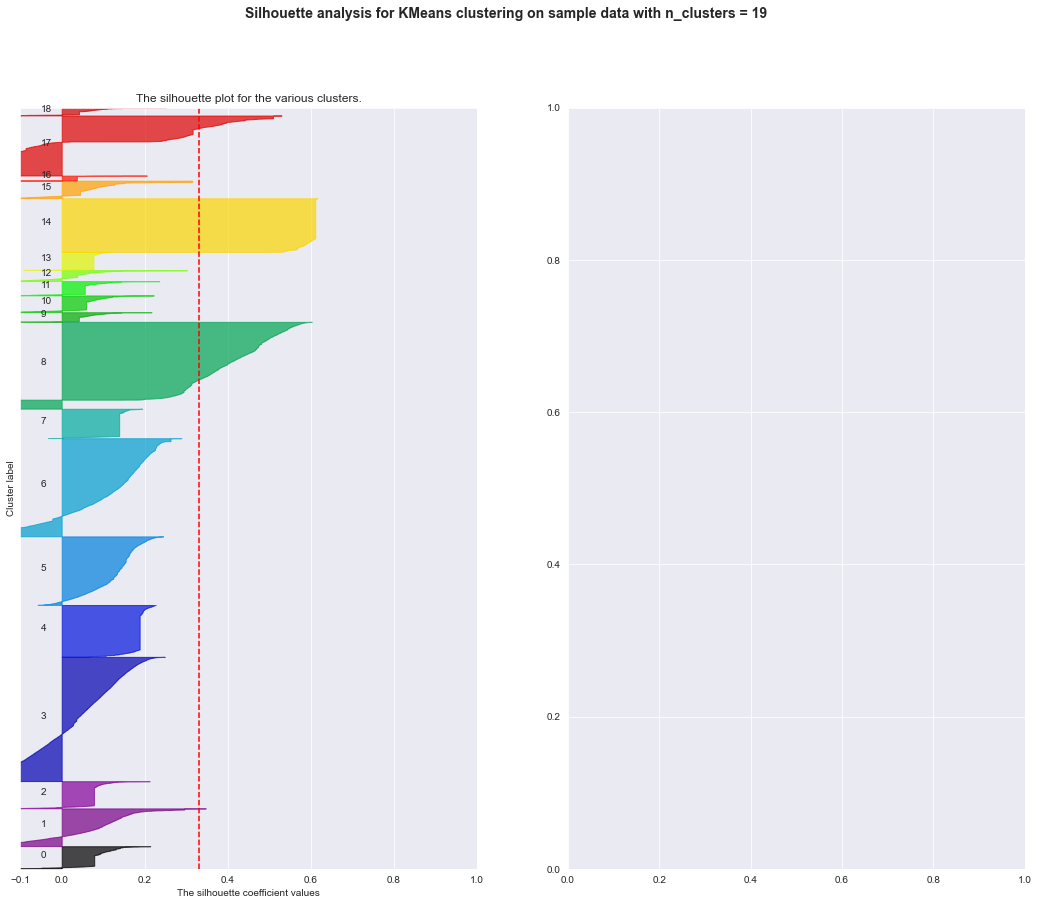

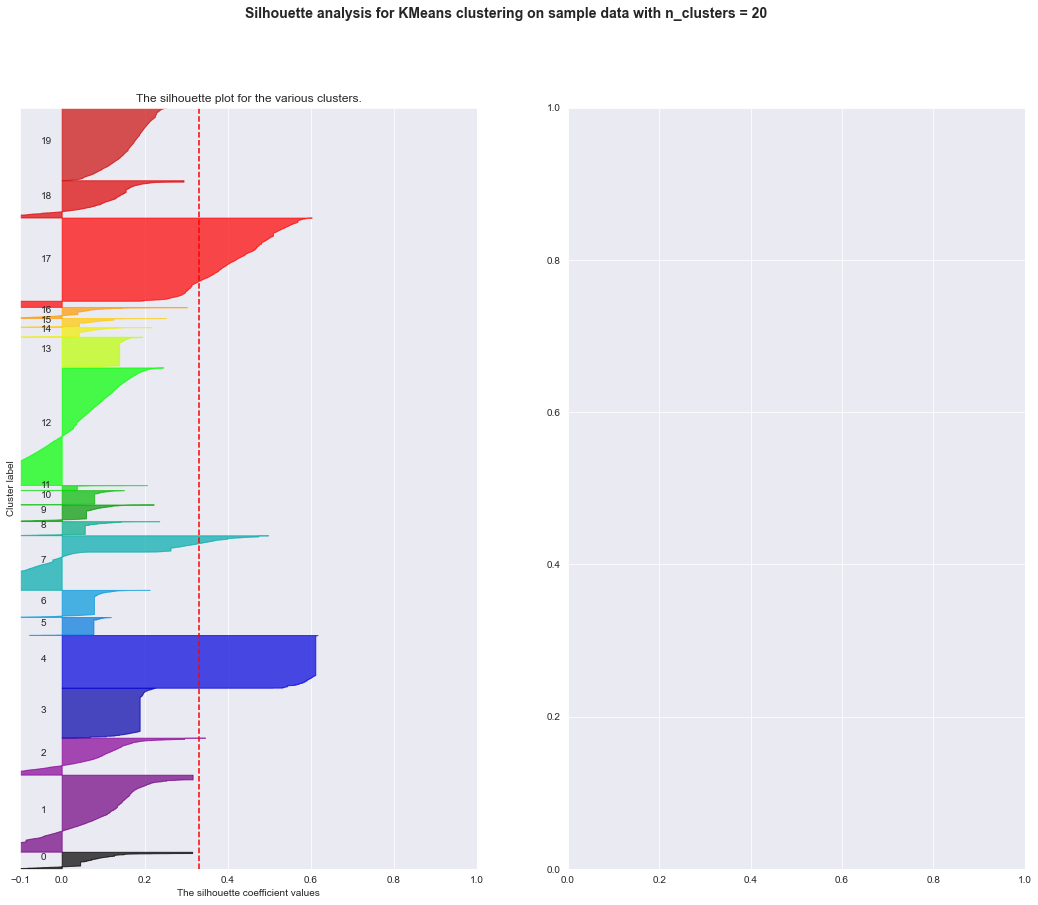

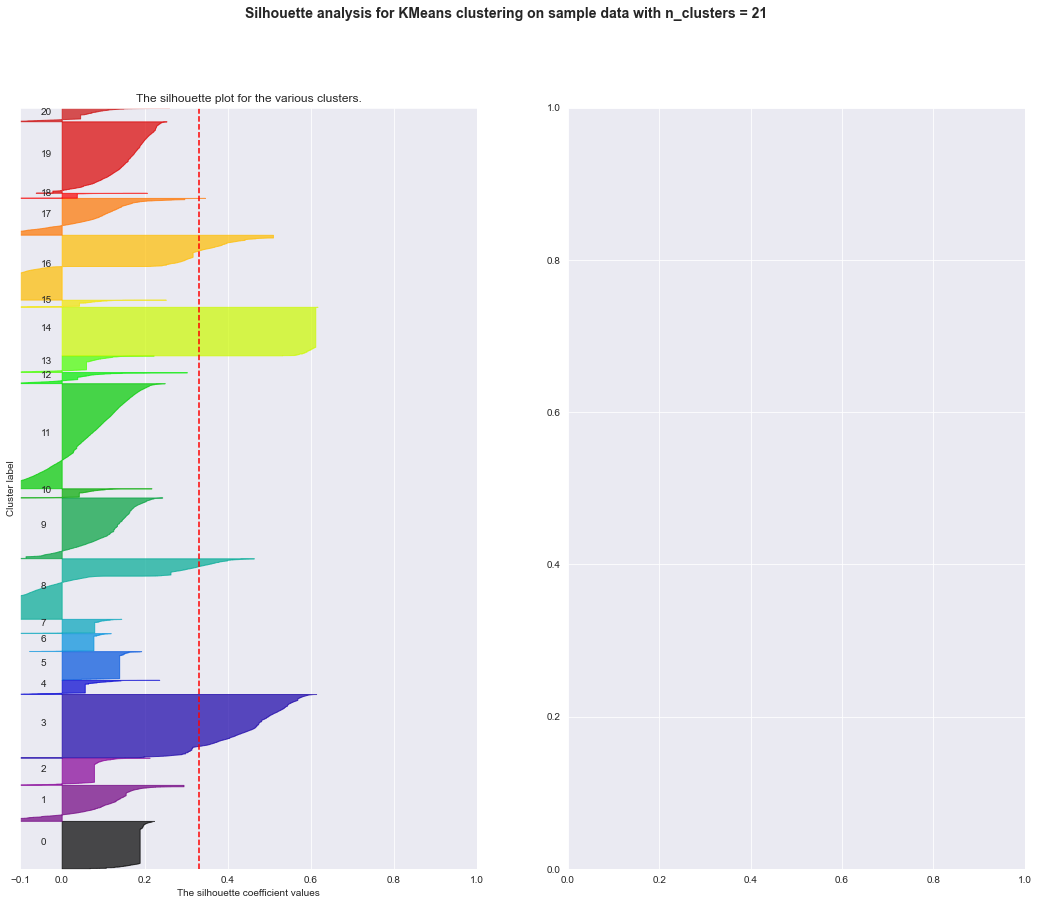

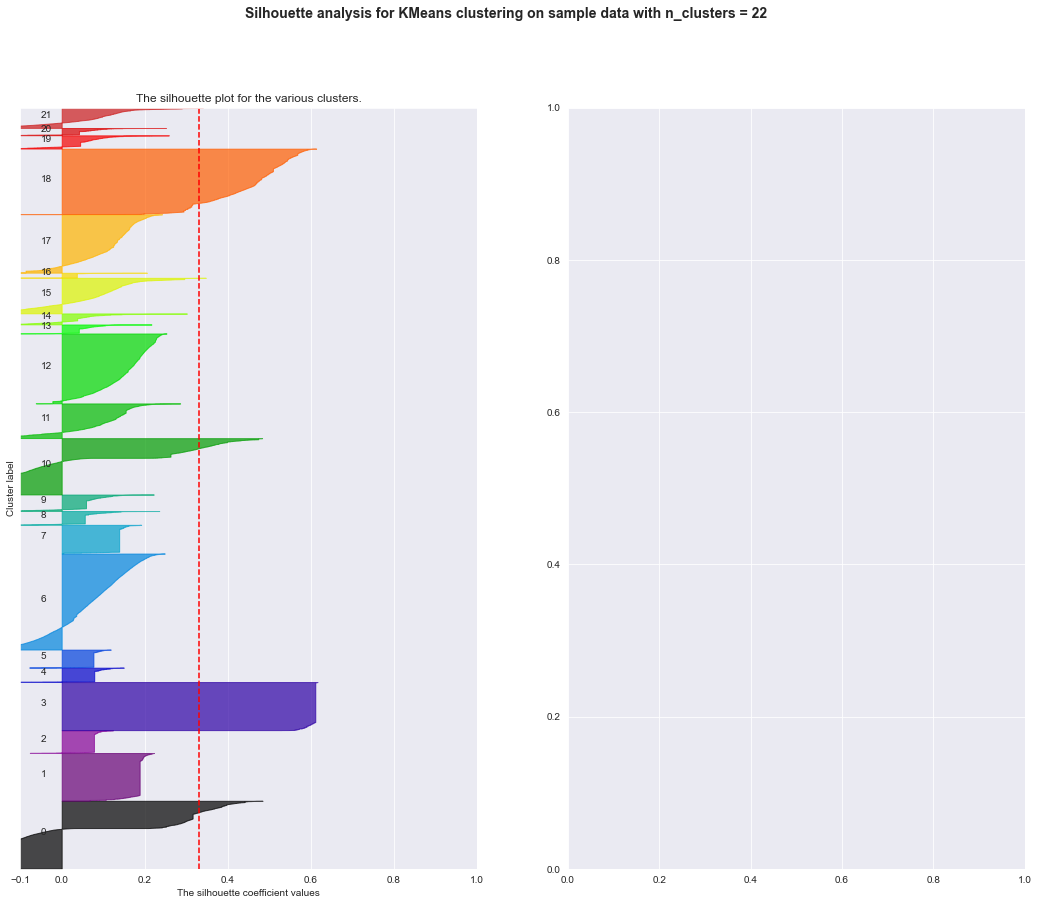

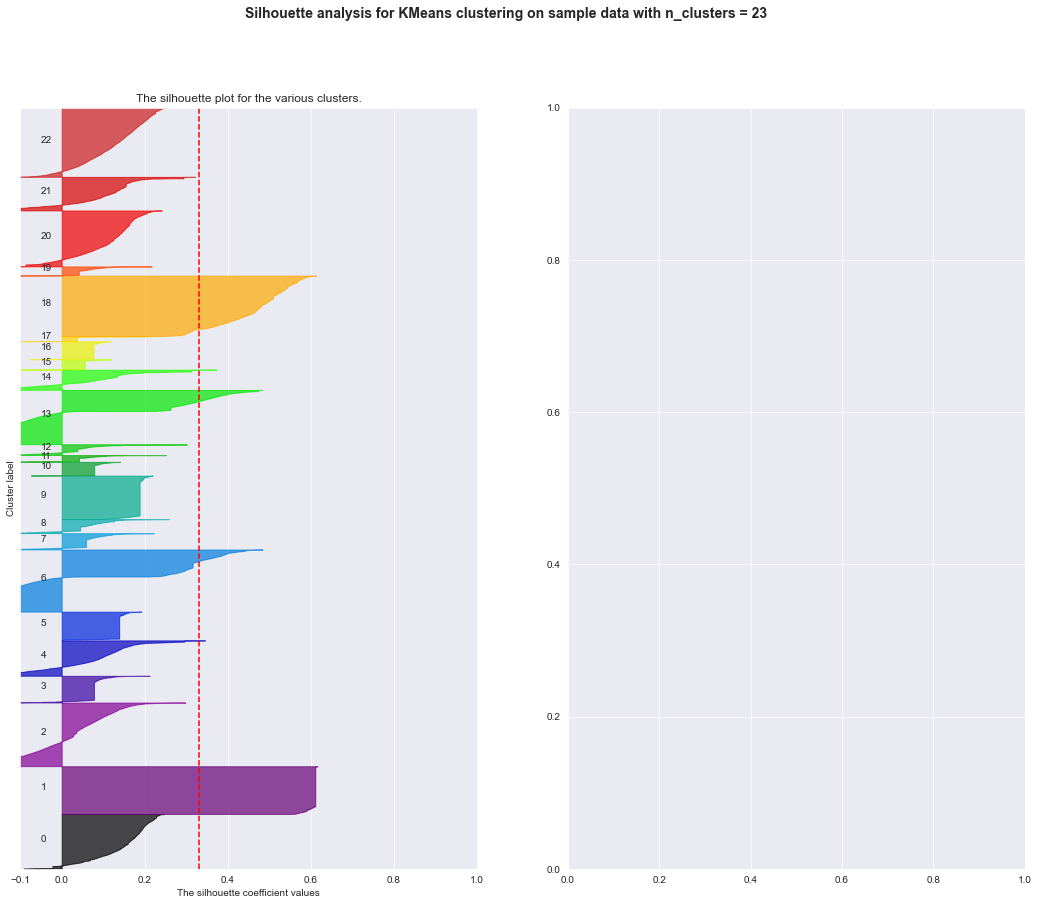

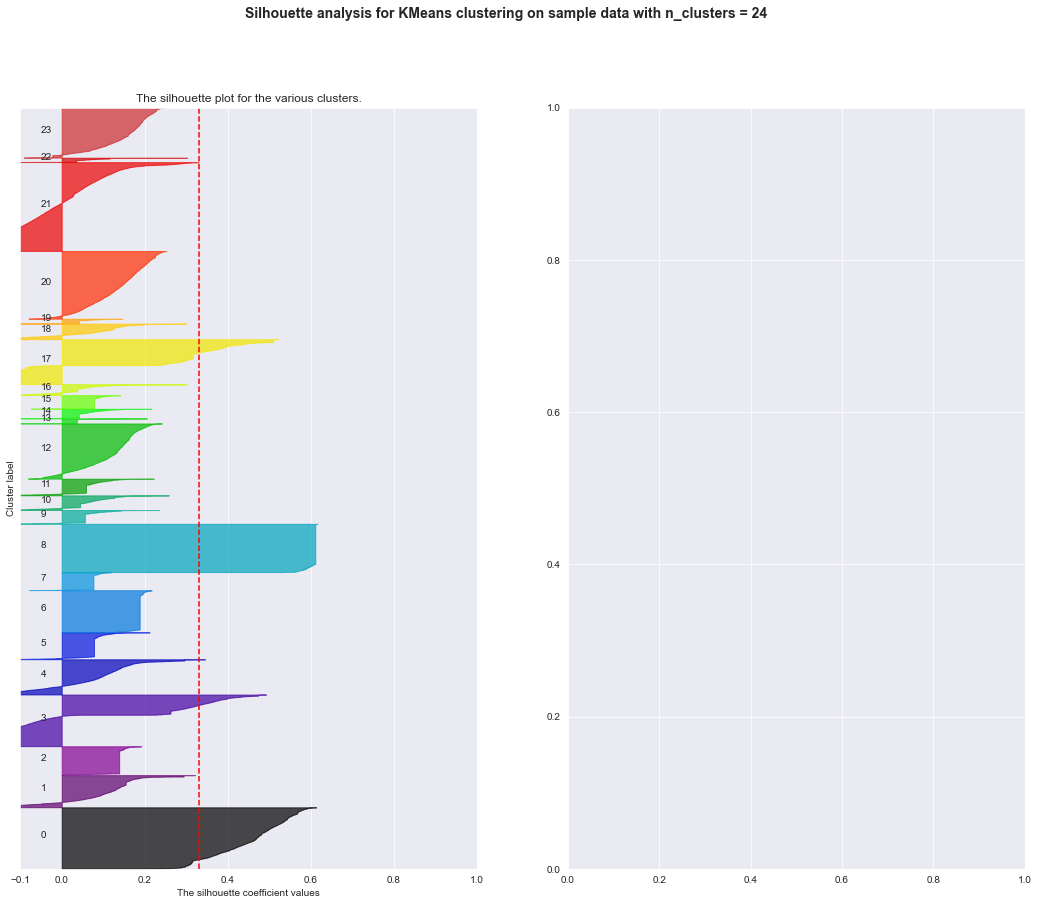

In [353]:
import time
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
import matplotlib.cm as cm


# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

# convert the df to numpy array to increase the speed
customer_group_merged_np = np.array(customer_group_merged)


train = customer_group_merged_np
# sample rows for faster silhouette calculation
number_of_samples = 70000
np.random.seed(47)
sample_indices = np.random.choice(customer_group_merged.shape[0], number_of_samples, replace=False)
X = train[sample_indices]
range_n_clusters = range(7,25)
sil_scores = list()
for n_clusters in range_n_clusters:
    t0 = time.time()
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 14)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=47)
    cluster_labels = clusterer.fit_predict(train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    labels_sampled = cluster_labels[sample_indices]
    silhouette_avg_sampled = silhouette_score(X, labels_sampled)
    # append the result to plot later
    sil_scores.append(silhouette_avg_sampled)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg_sampled,
    )
    t_elapsed = time.time() - t0
    print(n_clusters,": ",t_elapsed)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels_sampled == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    
plt.show()
    
    
# df_sil_scores = pd.DataFrame([range_n_clusters,sil_scores]).T
# sns.set_style("darkgrid")
# fig, ax = plt.subplots(figsize=(16,8))
# ax = sns.lineplot(data=df_sil_scores, x=0, y=1)
# ax.set_title('Silhouette Scores by Number of Clusters', fontsize=18)
# ax.set_xlabel('Number of Clusters')
# ax.set_ylabel('Silhouette Score')
# plt.show()

For n_clusters = 12 The average silhouette_score is : 0.2911014144391809
12 :  124.01803040504456
For n_clusters = 13 The average silhouette_score is : 0.3028080646085395
13 :  125.44404292106628
For n_clusters = 14 The average silhouette_score is : 0.3096806362138138
14 :  128.6900007724762
For n_clusters = 15 The average silhouette_score is : 0.3171514902331126
15 :  129.00103616714478
For n_clusters = 16 The average silhouette_score is : 0.31457497218487096
16 :  131.88197016716003
For n_clusters = 17 The average silhouette_score is : 0.31966727152911456
17 :  129.1600534915924
For n_clusters = 18 The average silhouette_score is : 0.3214896541963211
18 :  133.58596539497375
For n_clusters = 19 The average silhouette_score is : 0.31245370814666246
19 :  130.82699632644653
For n_clusters = 20 The average silhouette_score is : 0.3076907170062021
20 :  133.15300297737122
For n_clusters = 21 The average silhouette_score is : 0.3107331008997059
21 :  135.47399878501892
For n_clusters = 22

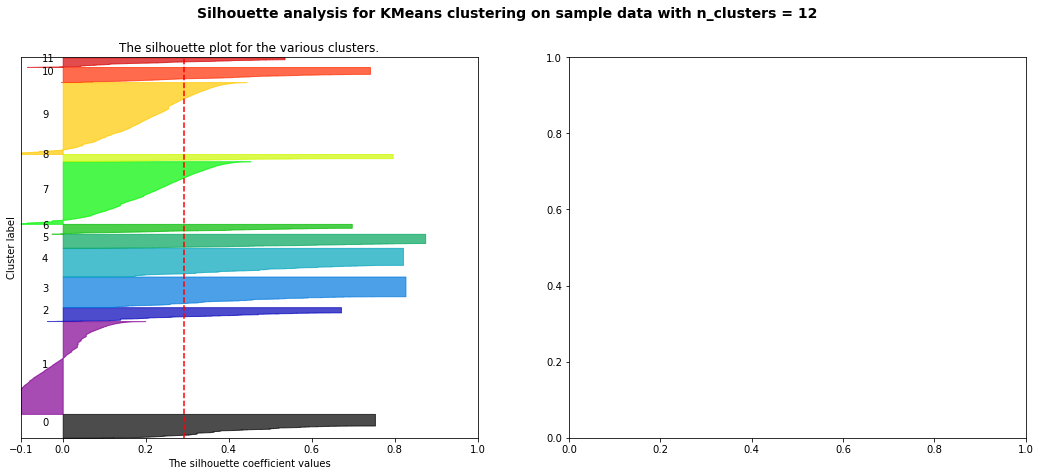

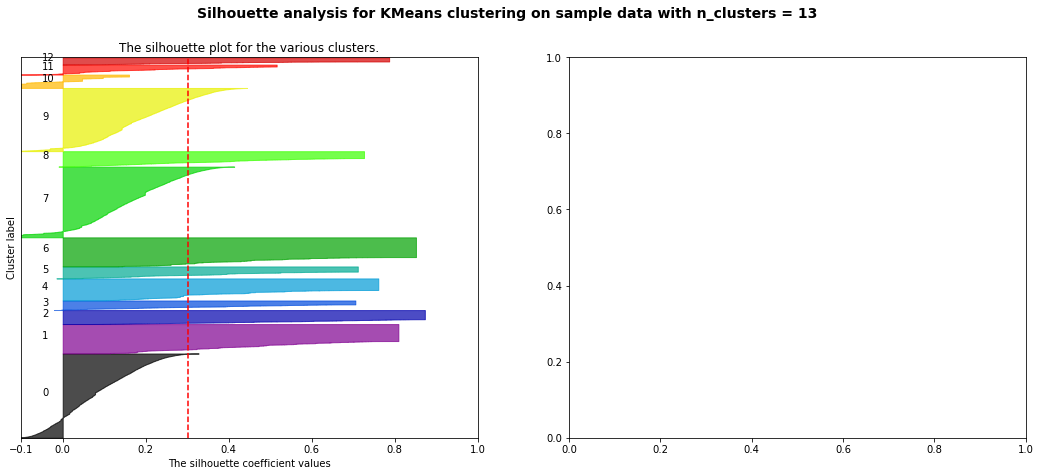

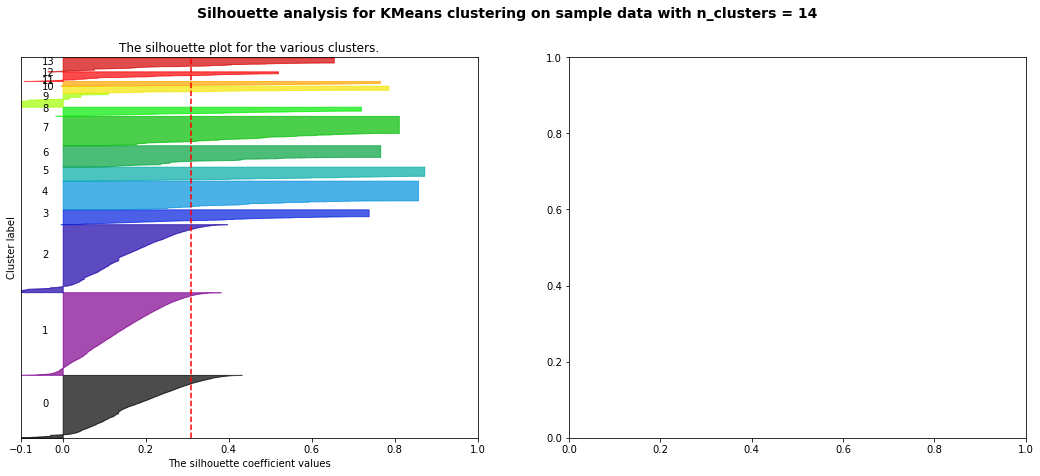

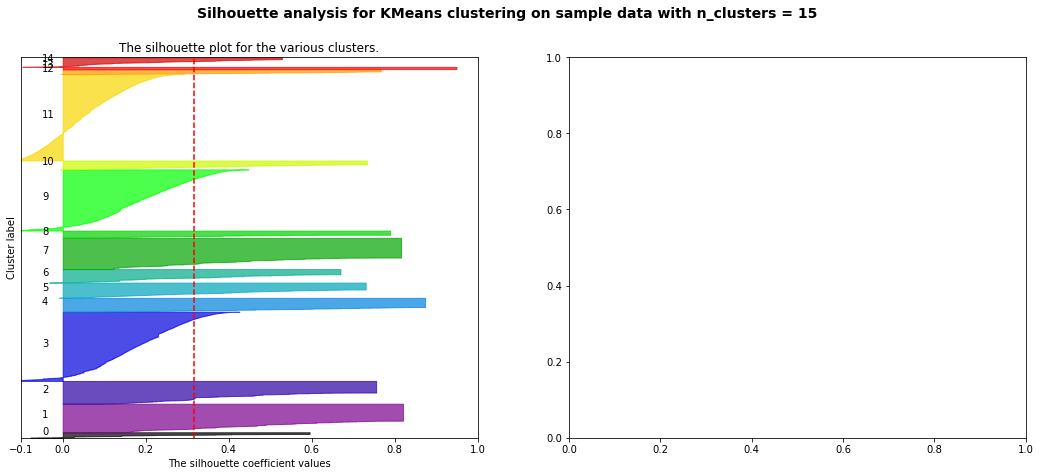

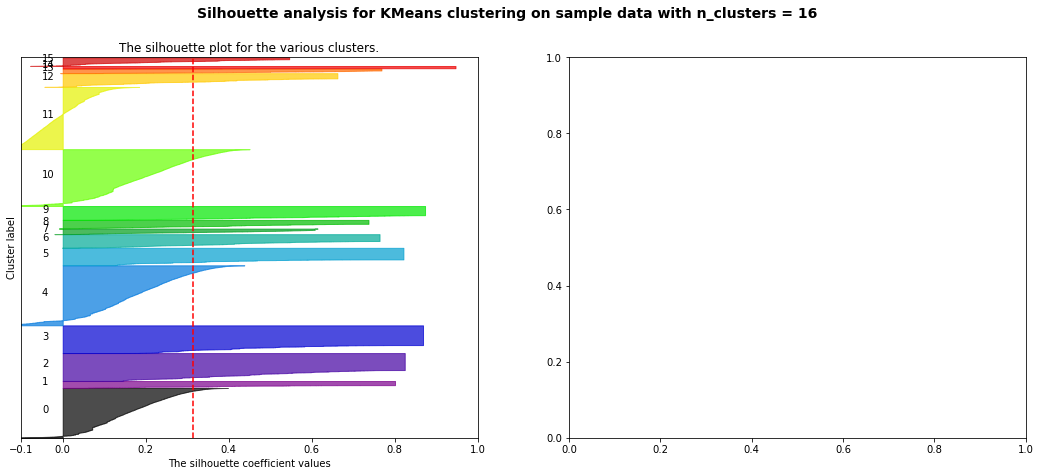

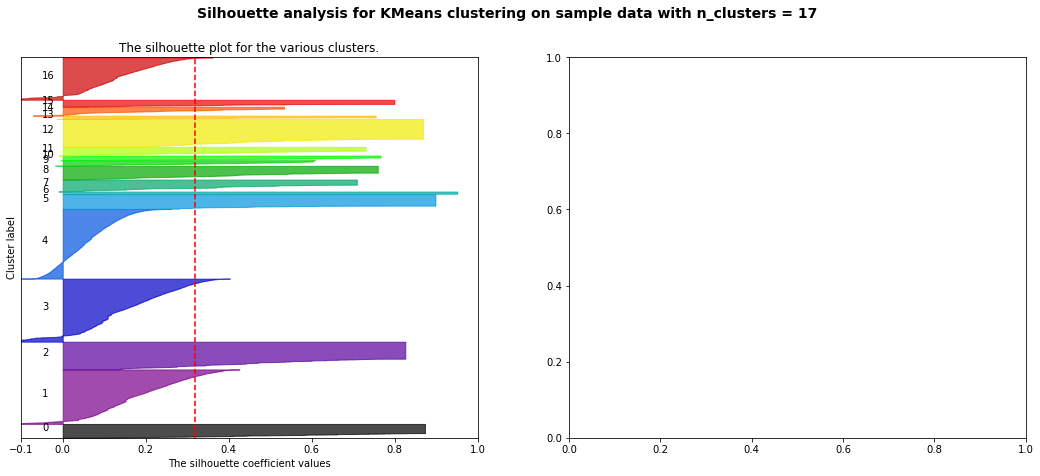

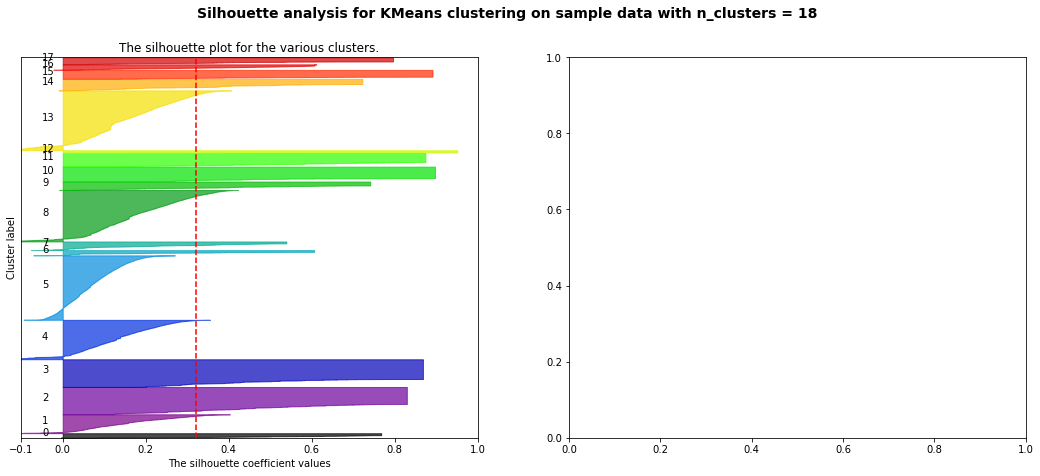

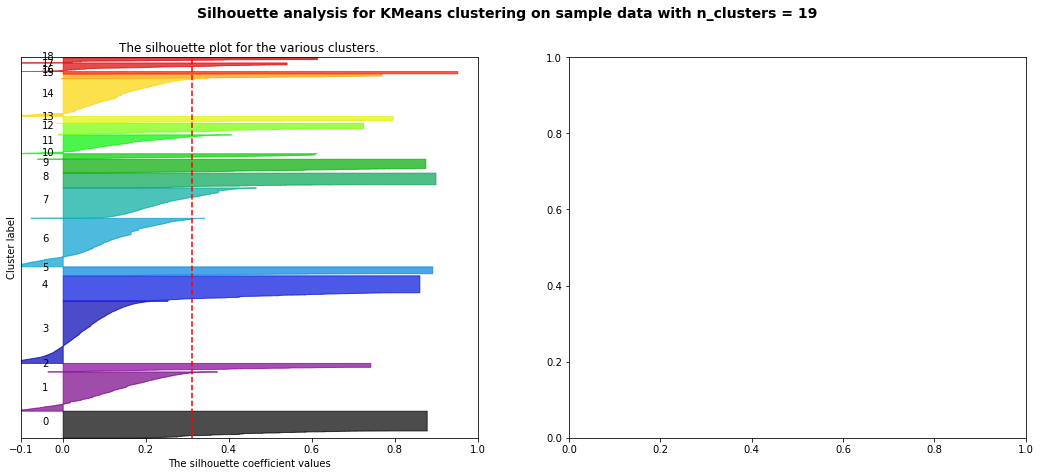

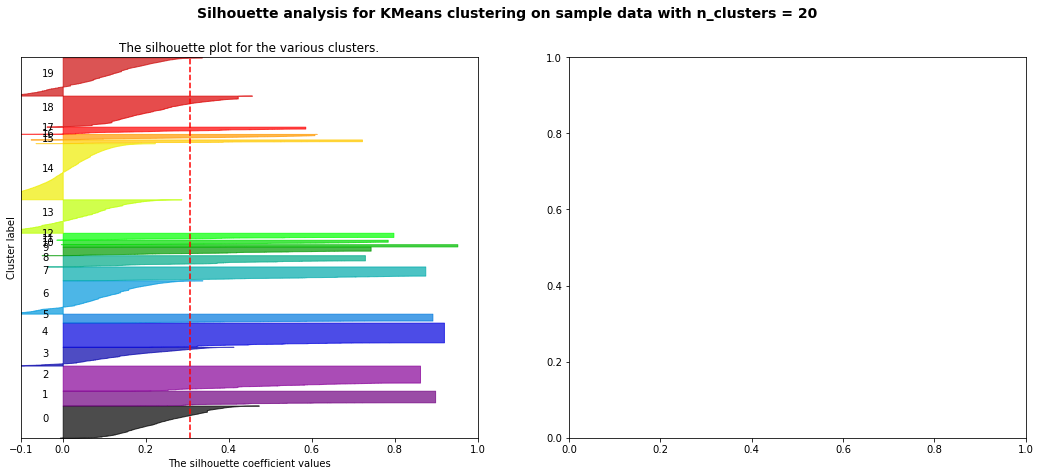

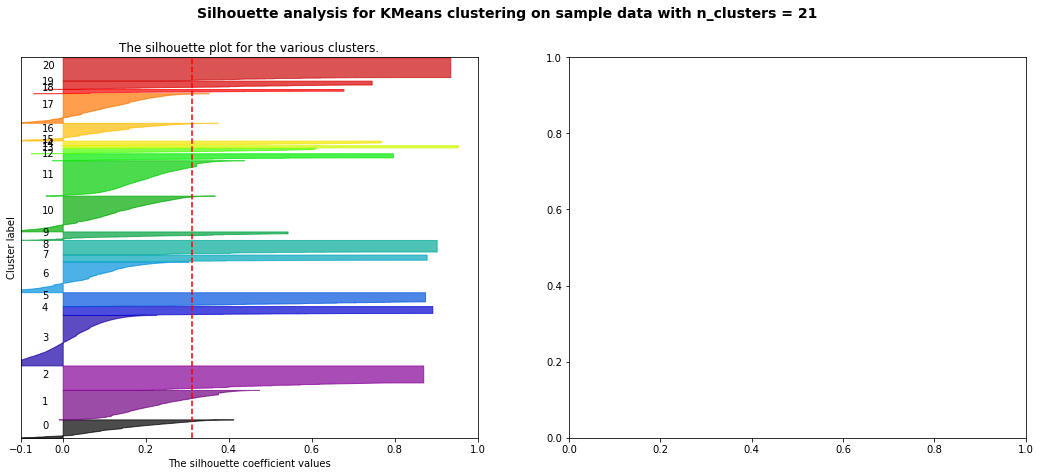

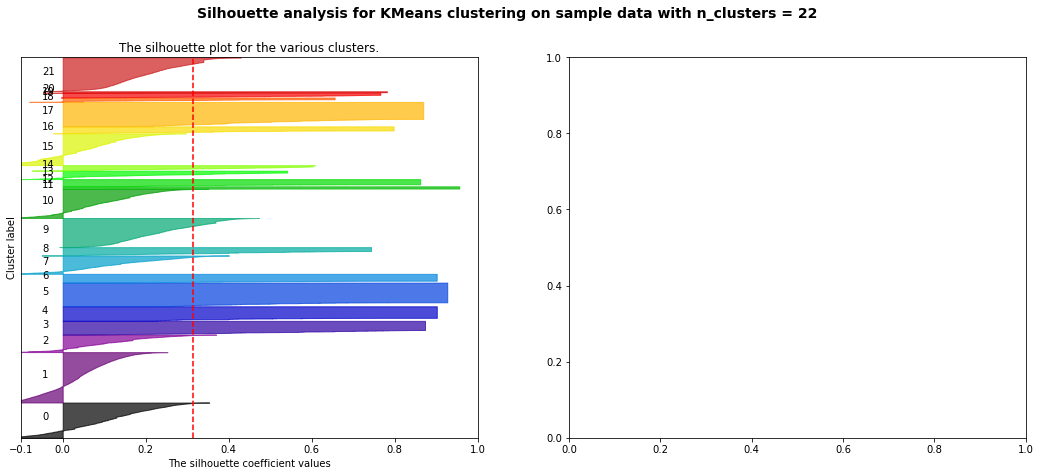

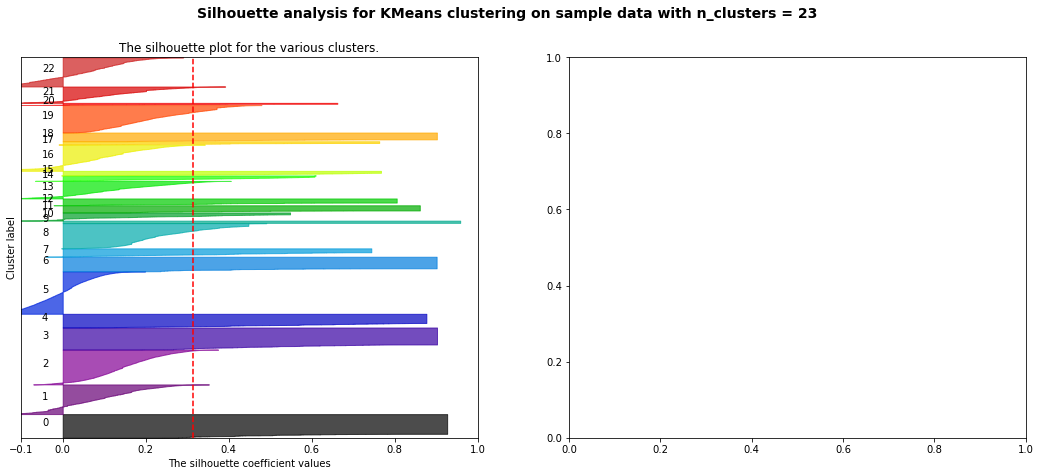

In [266]:
range_n_clusters = range(7,24)
for n_clusters in range_n_clusters:
    t0 = time.time()
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    t_elapsed = time.time() - t0
    print(n_clusters,": ",t_elapsed)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(
#         X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
#     )

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(
#         centers[:, 0],
#         centers[:, 1],
#         marker="o",
#         c="white",
#         alpha=1,
#         s=200,
#         edgecolor="k",
#     )

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    
plt.show()

## Clusters :24 - 79

For n_clusters = 24 The average silhouette_score is : 0.31928330670931504
24 :  126.56370377540588
For n_clusters = 25 The average silhouette_score is : 0.31442589648597286
25 :  121.41645002365112
For n_clusters = 26 The average silhouette_score is : 0.3159615054185404
26 :  121.52338075637817
For n_clusters = 27 The average silhouette_score is : 0.31344860617992043
27 :  119.91835260391235
For n_clusters = 28 The average silhouette_score is : 0.31625232259064034
28 :  120.58518171310425
For n_clusters = 29 The average silhouette_score is : 0.31334592057742894
29 :  123.02265691757202
For n_clusters = 30 The average silhouette_score is : 0.31596197486493754
30 :  124.76484727859497
For n_clusters = 31 The average silhouette_score is : 0.31617917402110235
31 :  125.84765696525574
For n_clusters = 32 The average silhouette_score is : 0.3127849004433582
32 :  126.407475233078
For n_clusters = 33 The average silhouette_score is : 0.3172993368893222
33 :  123.7452039718628
For n_clusters =

C:\Users\cosni\miniconda3\envs\hnm_recs\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


For n_clusters = 44 The average silhouette_score is : 0.3172657168054187
44 :  136.2924098968506
For n_clusters = 45 The average silhouette_score is : 0.3193450199706458
45 :  146.46850442886353
For n_clusters = 46 The average silhouette_score is : 0.3162137127710681
46 :  139.69016337394714
For n_clusters = 47 The average silhouette_score is : 0.3185265543857808
47 :  140.33553886413574
For n_clusters = 48 The average silhouette_score is : 0.3211071338679296
48 :  144.77807211875916
For n_clusters = 49 The average silhouette_score is : 0.3245106788084059
49 :  141.40528440475464
For n_clusters = 50 The average silhouette_score is : 0.31844915165970233
50 :  138.7952961921692
For n_clusters = 51 The average silhouette_score is : 0.3194809662489719
51 :  141.89077472686768
For n_clusters = 52 The average silhouette_score is : 0.3235246978136526
52 :  142.71641206741333
For n_clusters = 53 The average silhouette_score is : 0.3246131830825182
53 :  138.83848595619202
For n_clusters = 54 T

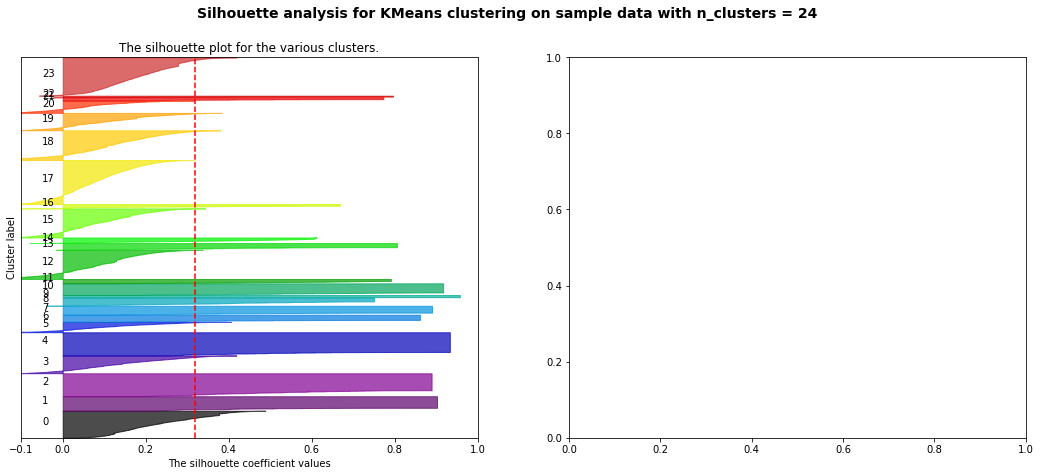

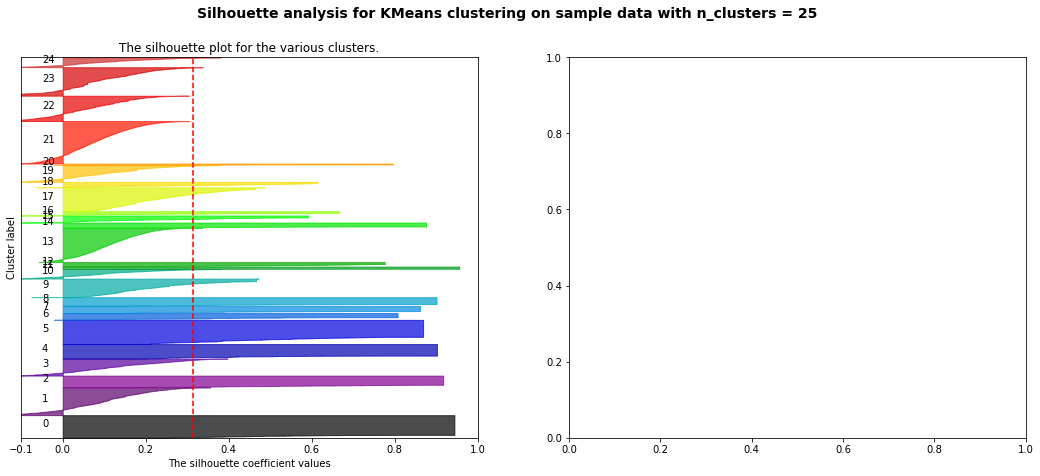

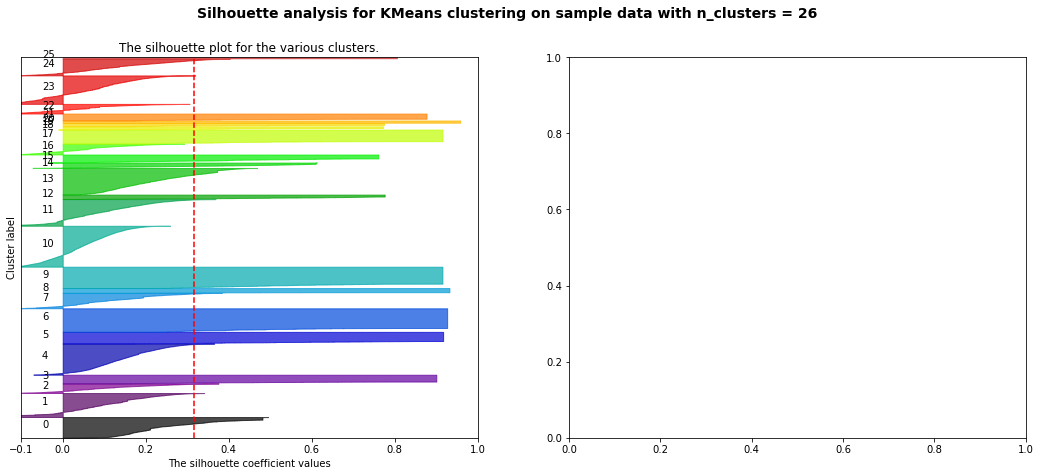

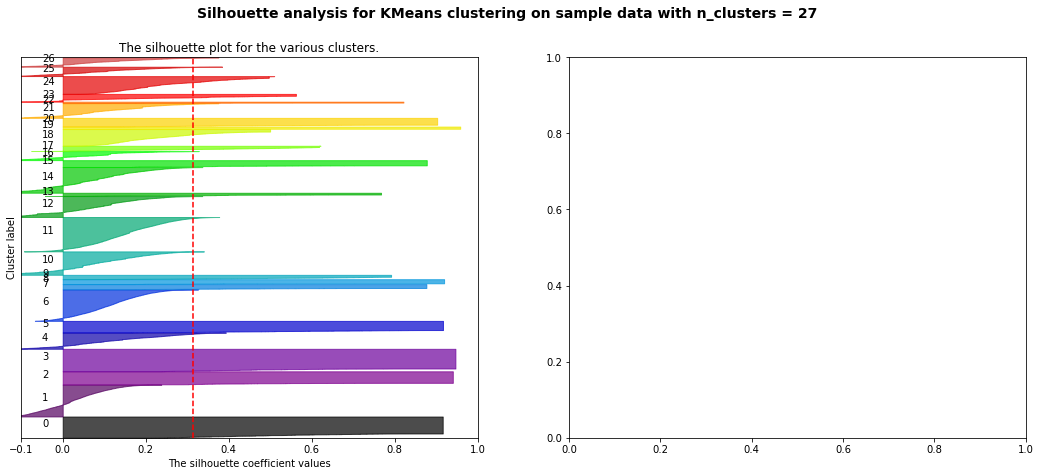

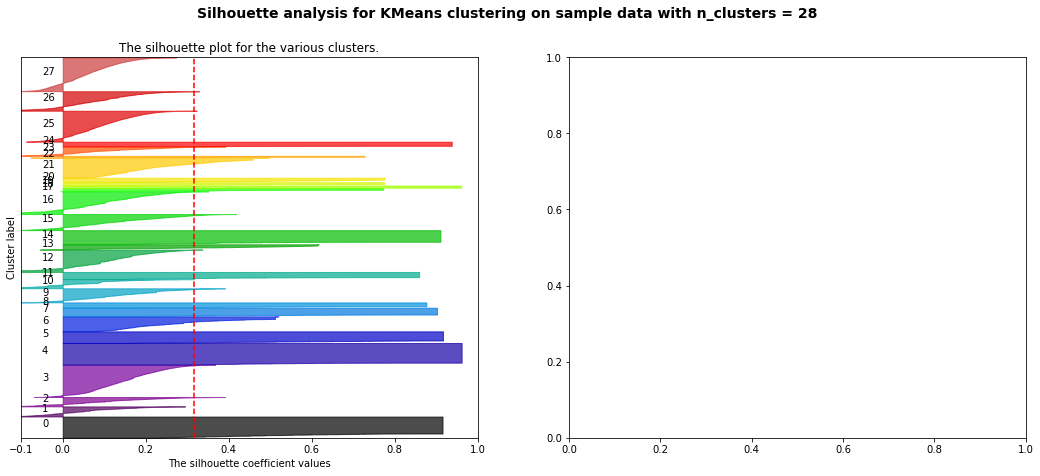

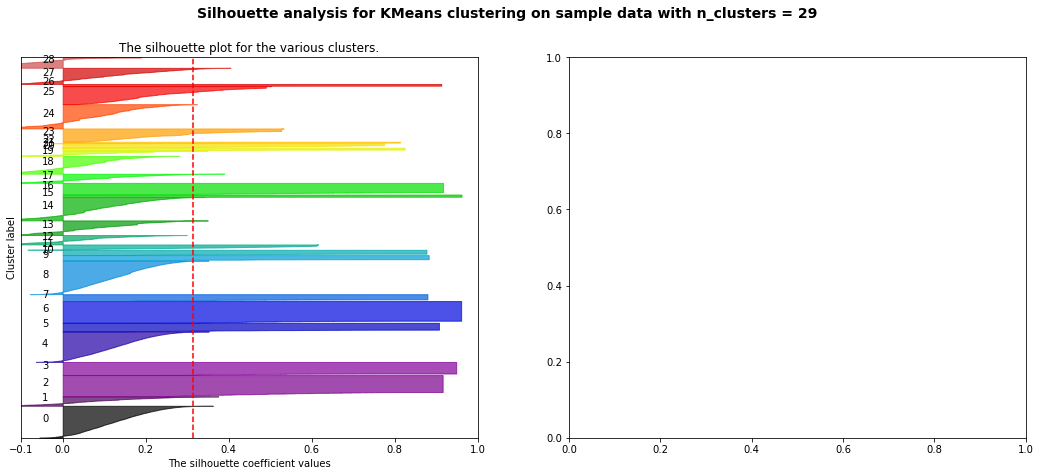

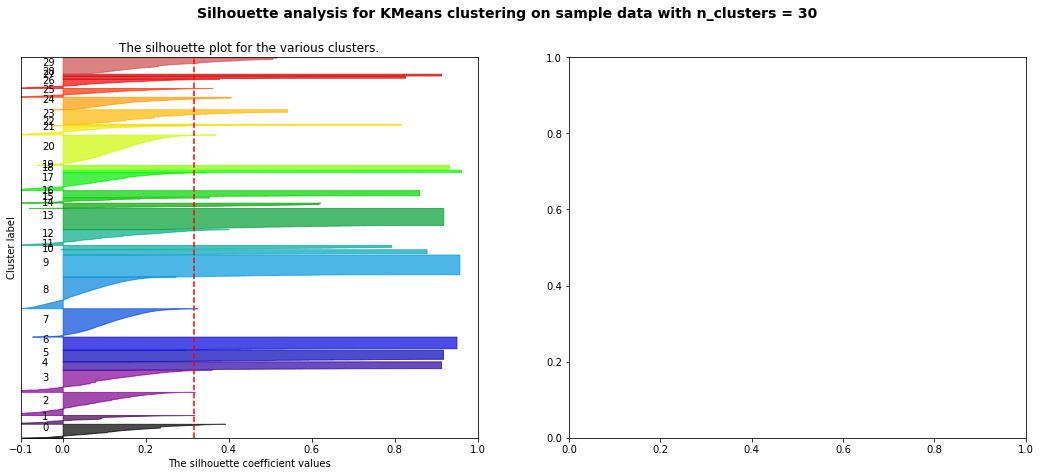

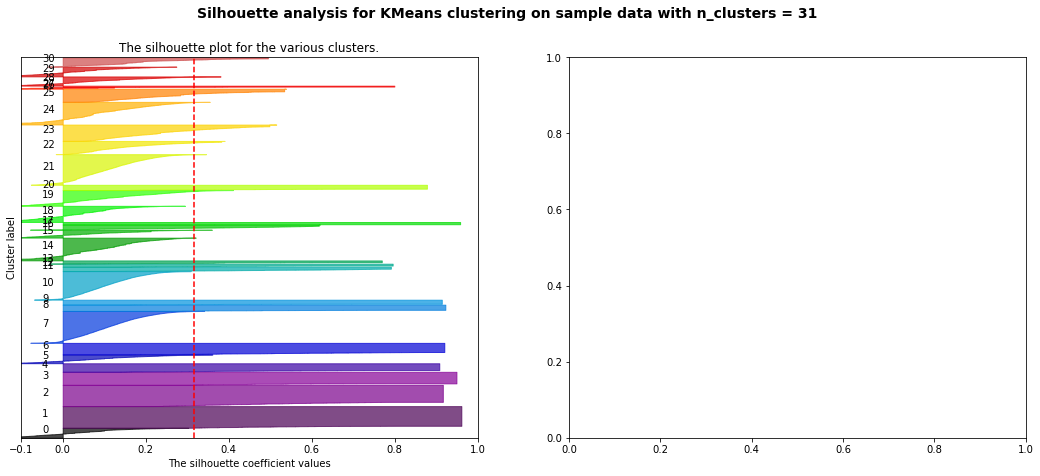

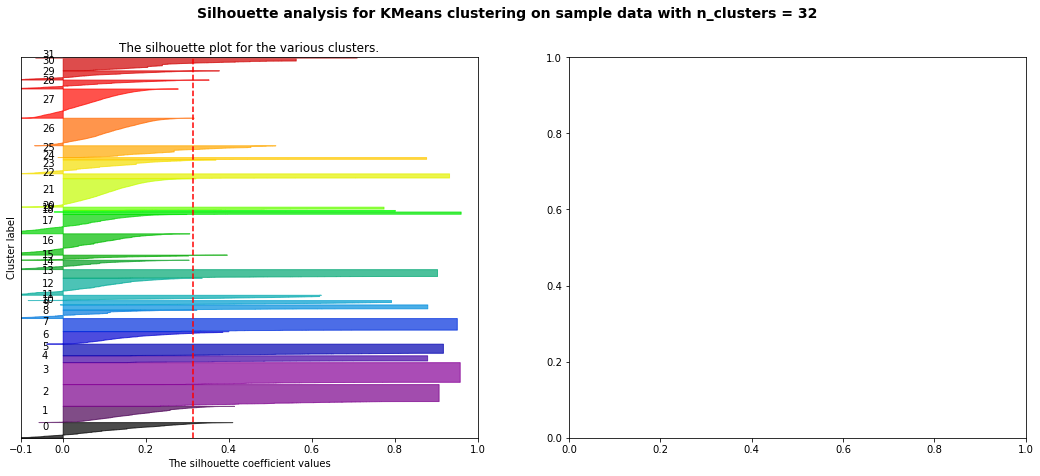

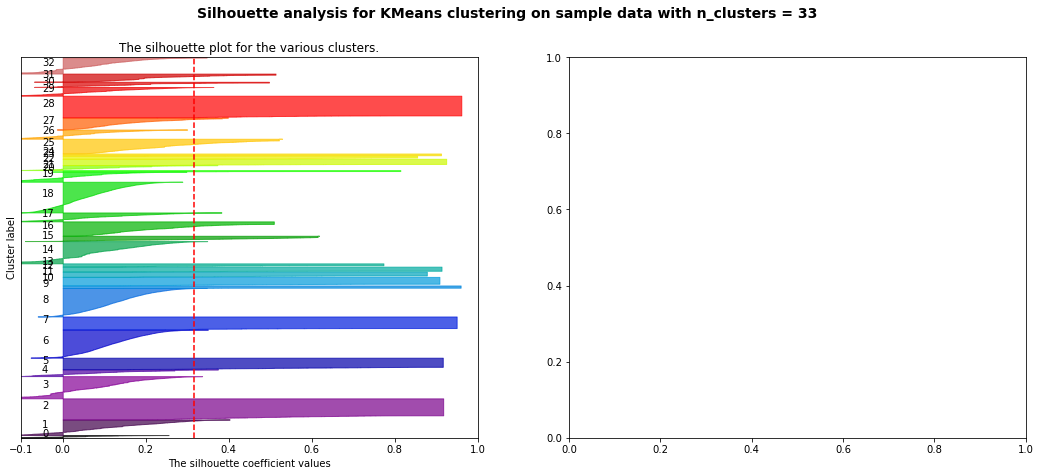

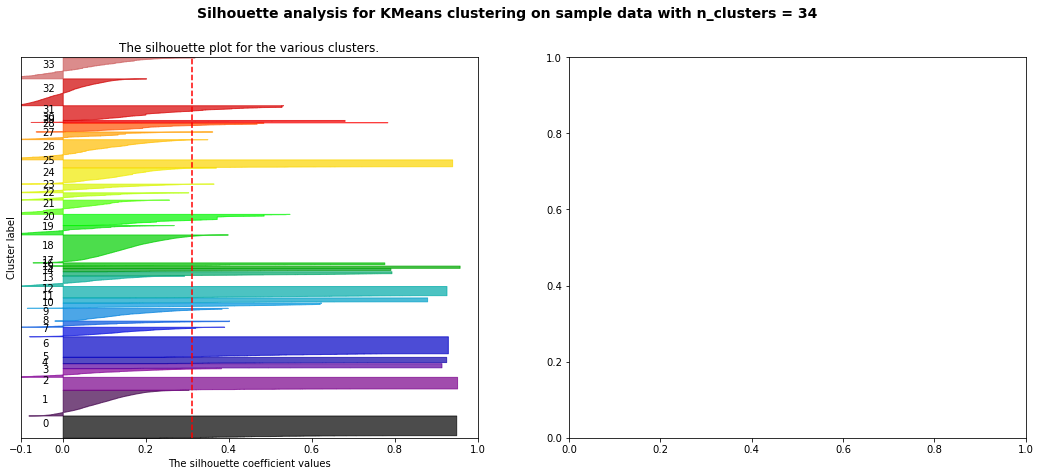

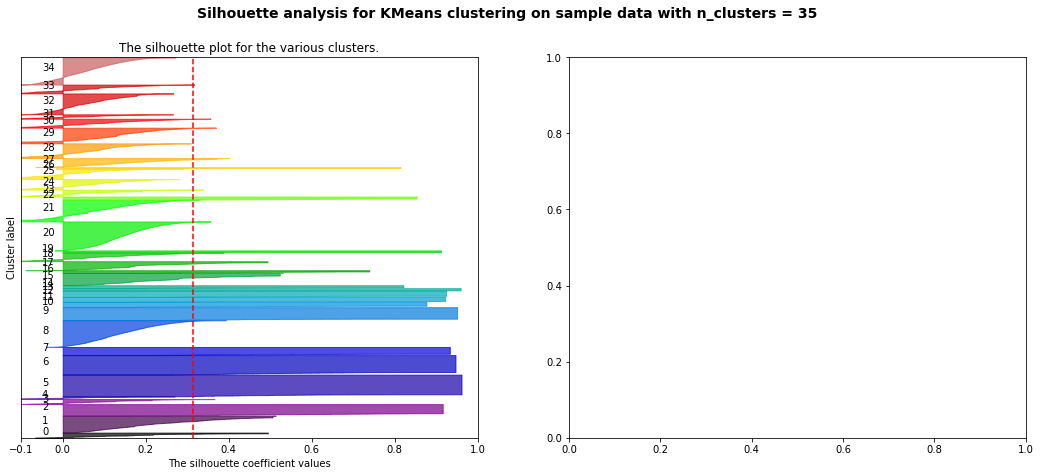

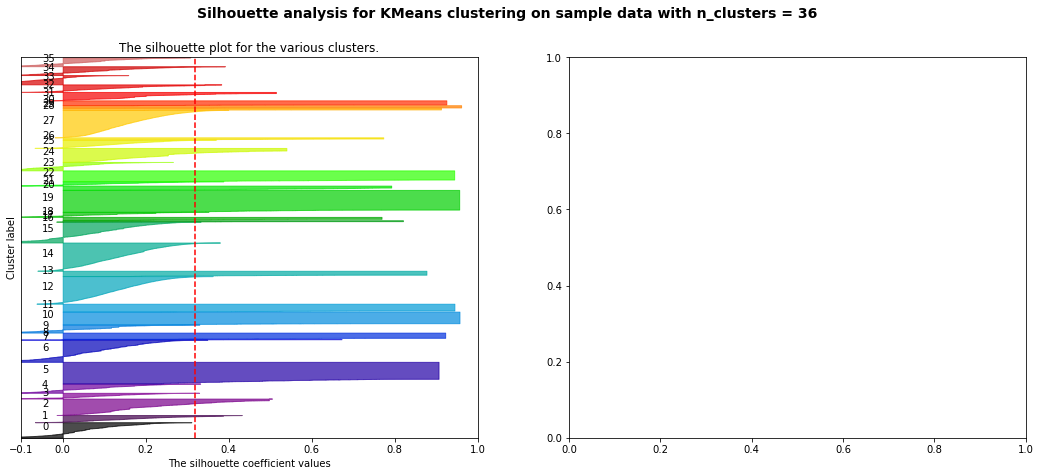

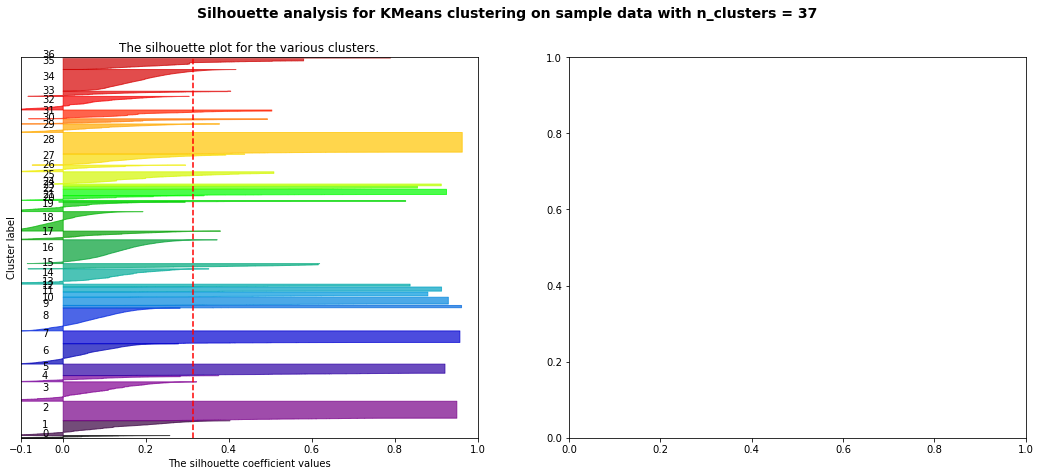

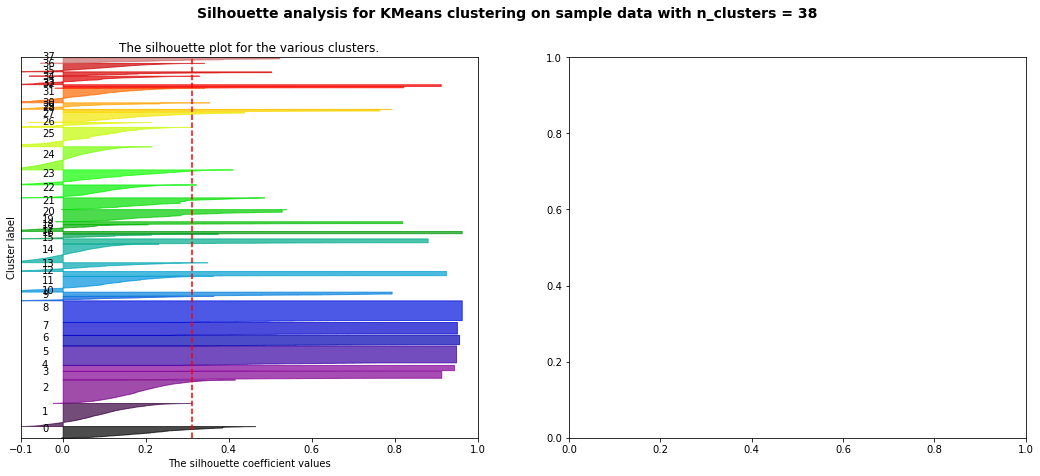

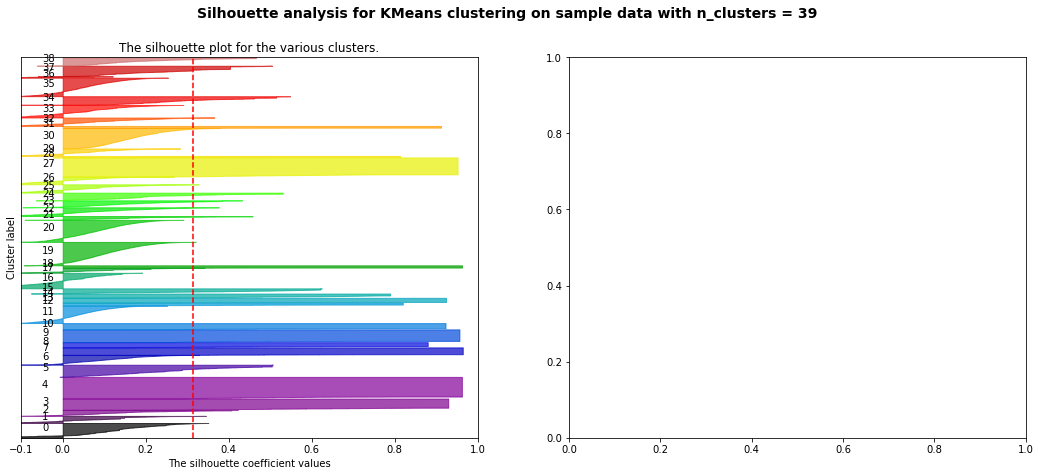

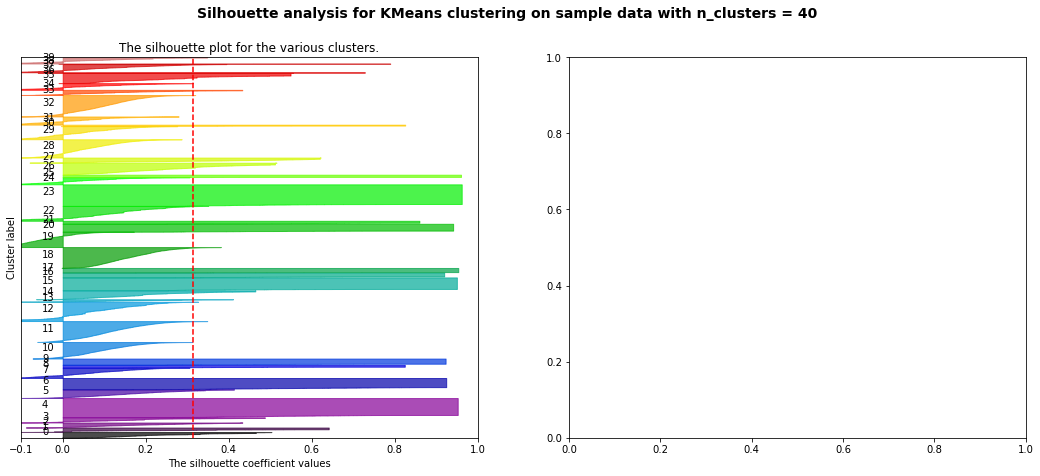

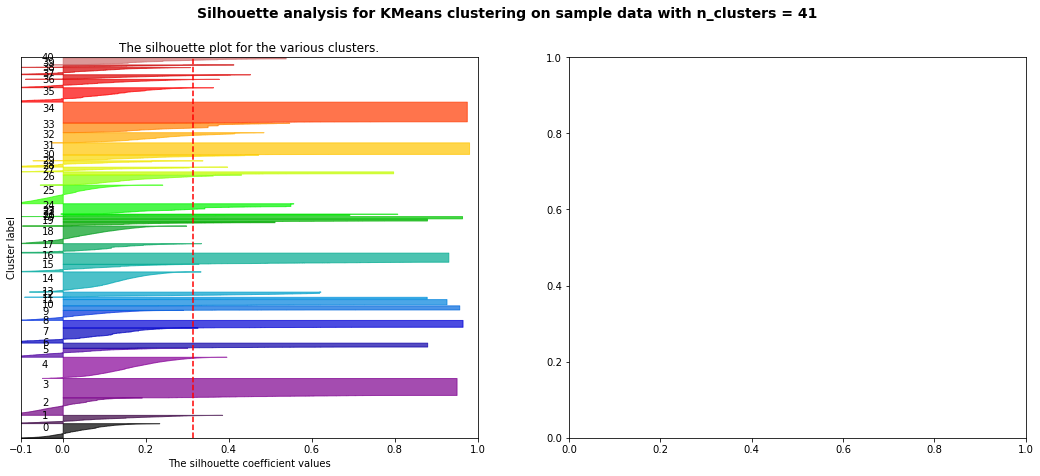

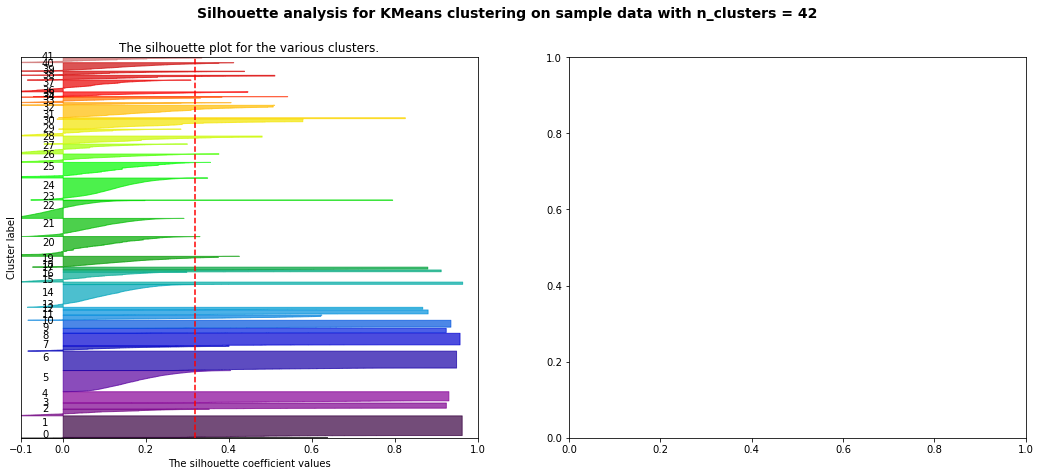

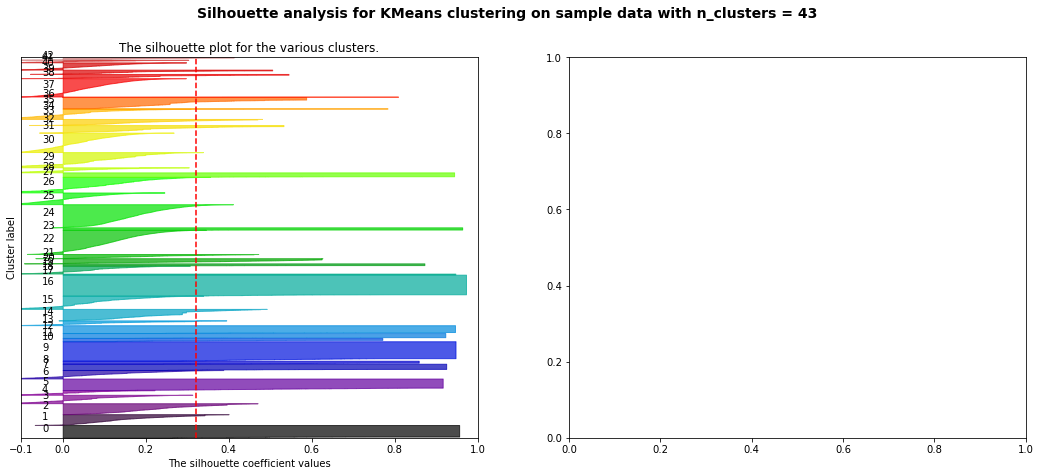

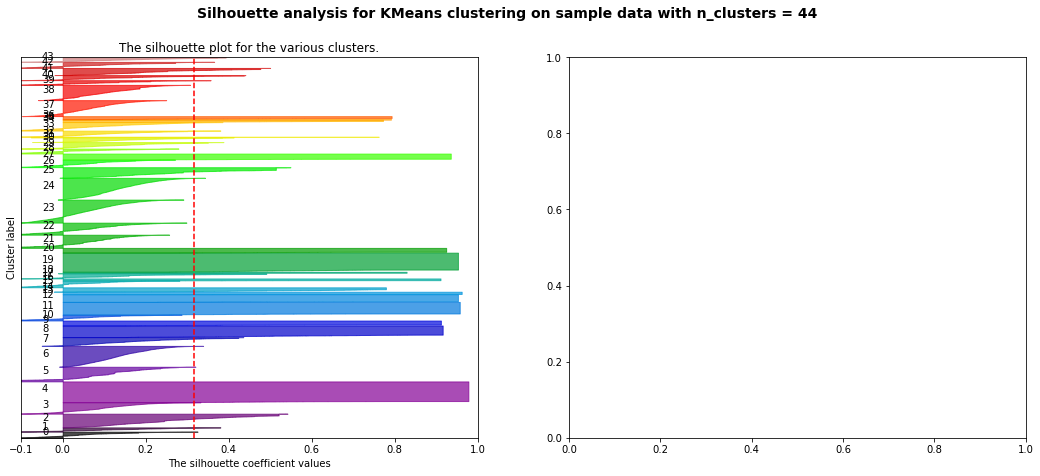

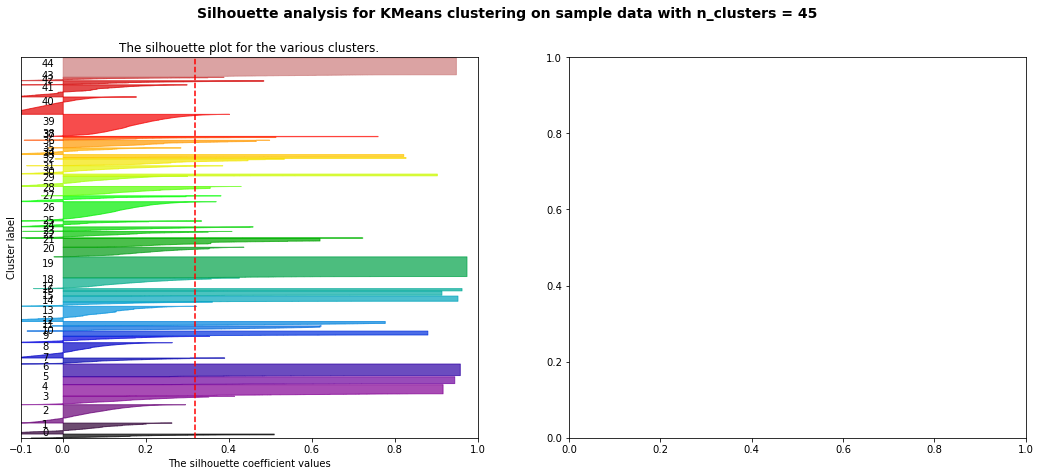

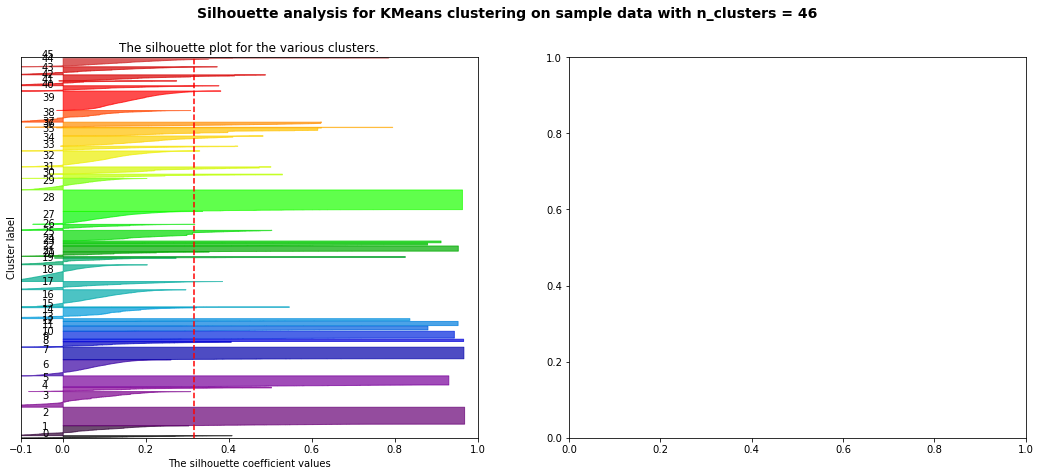

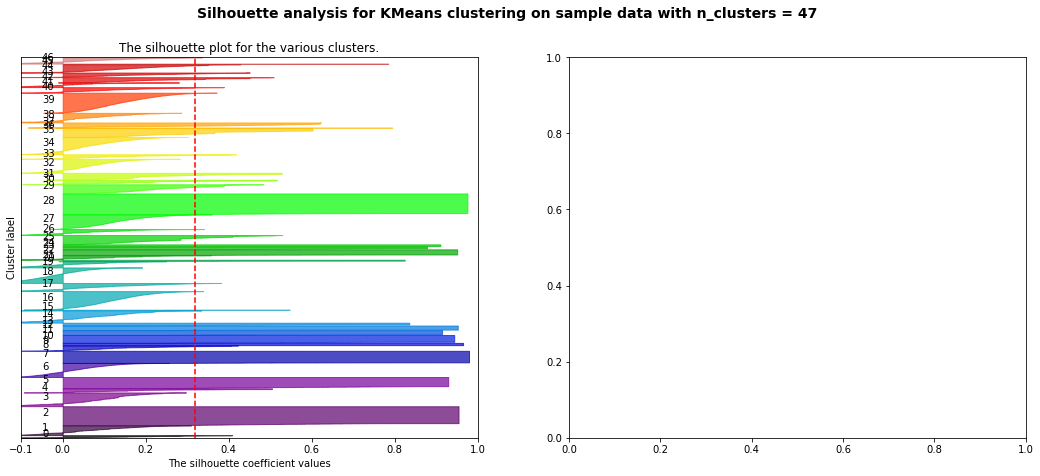

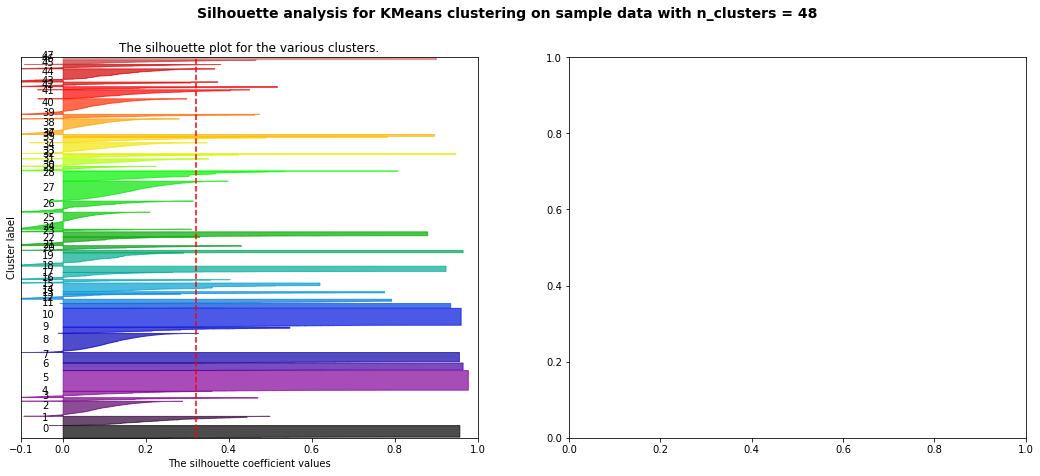

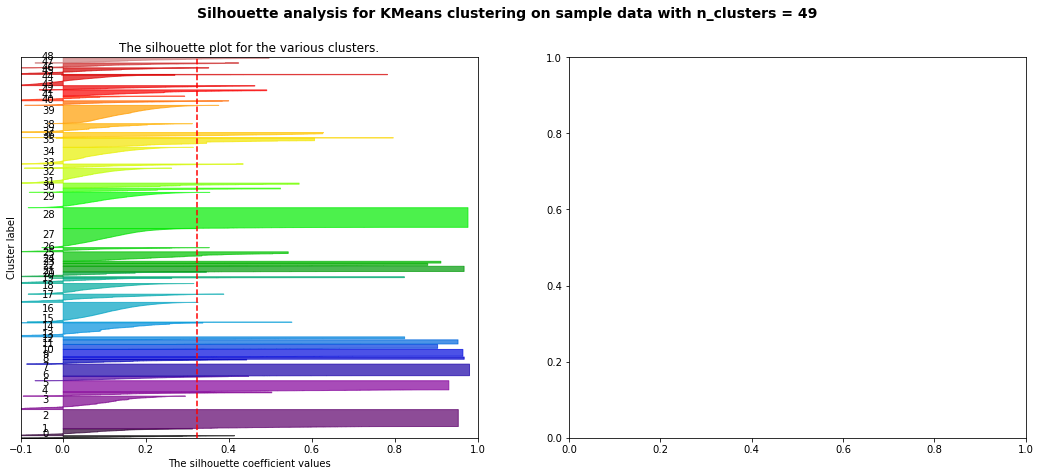

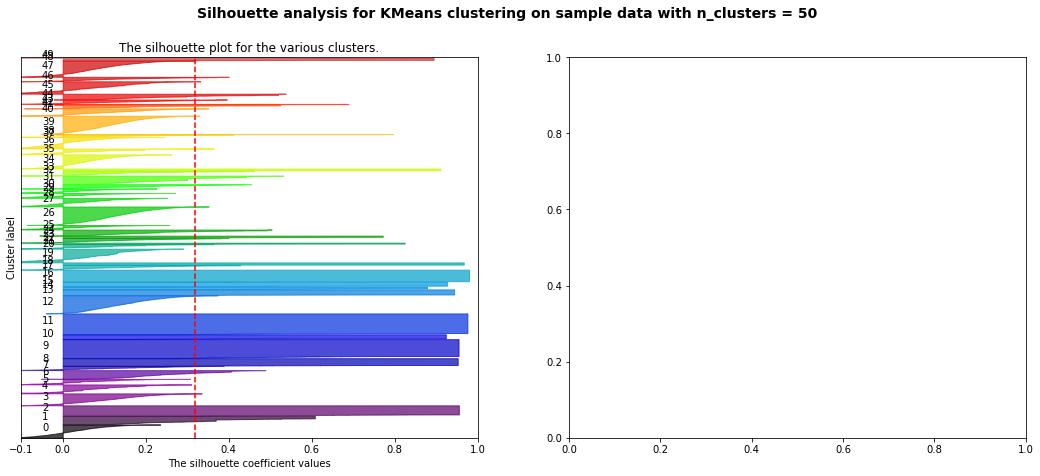

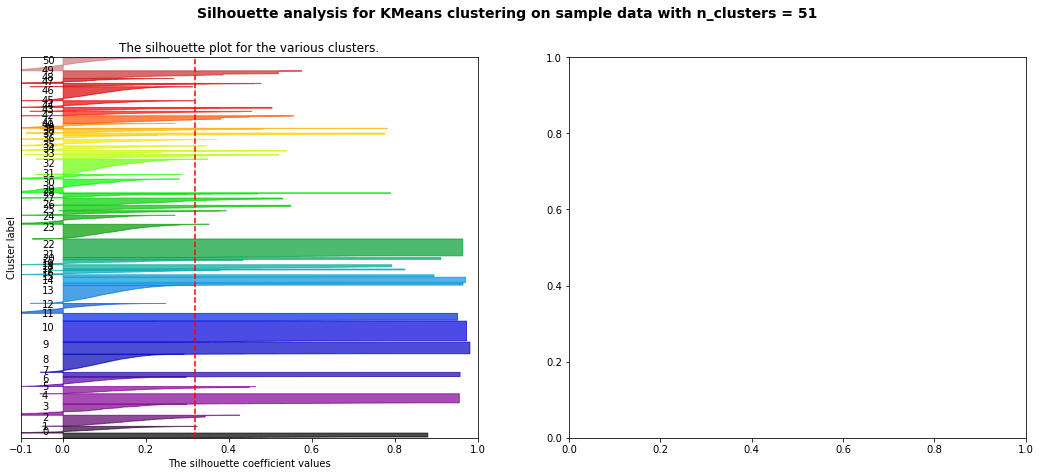

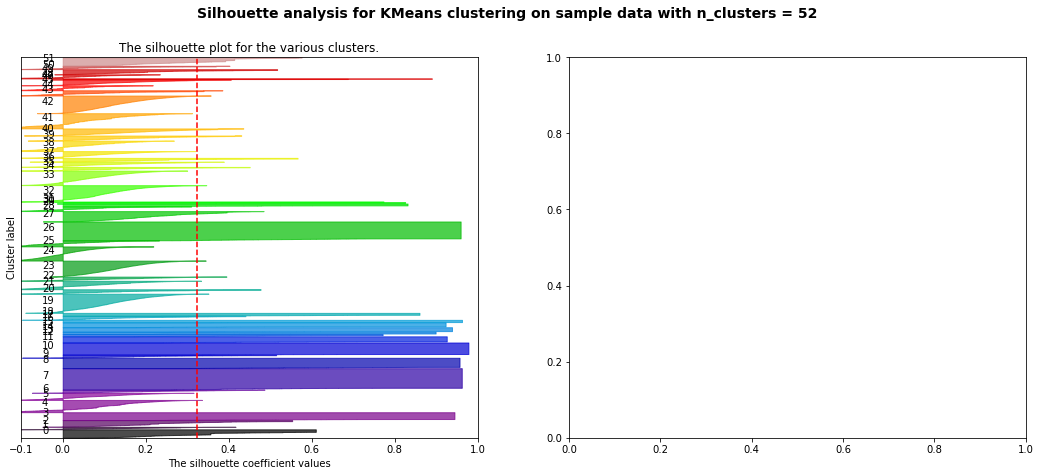

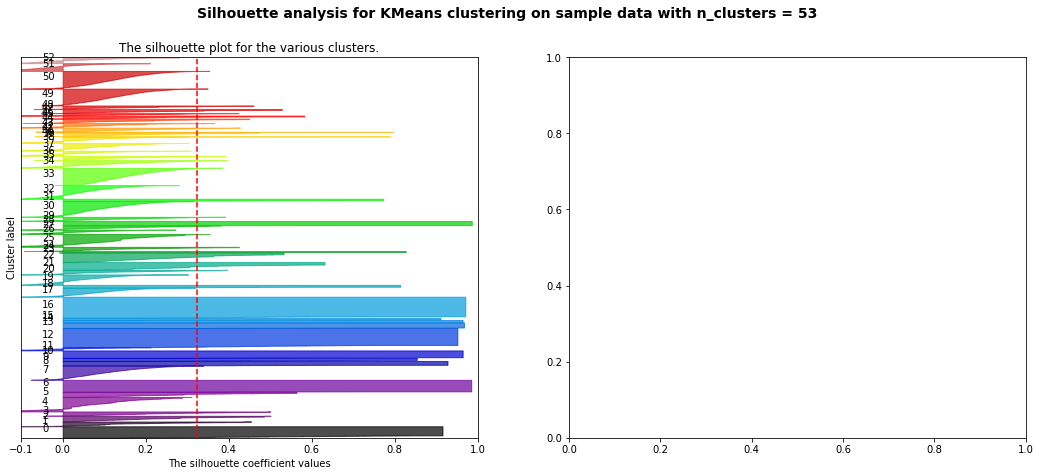

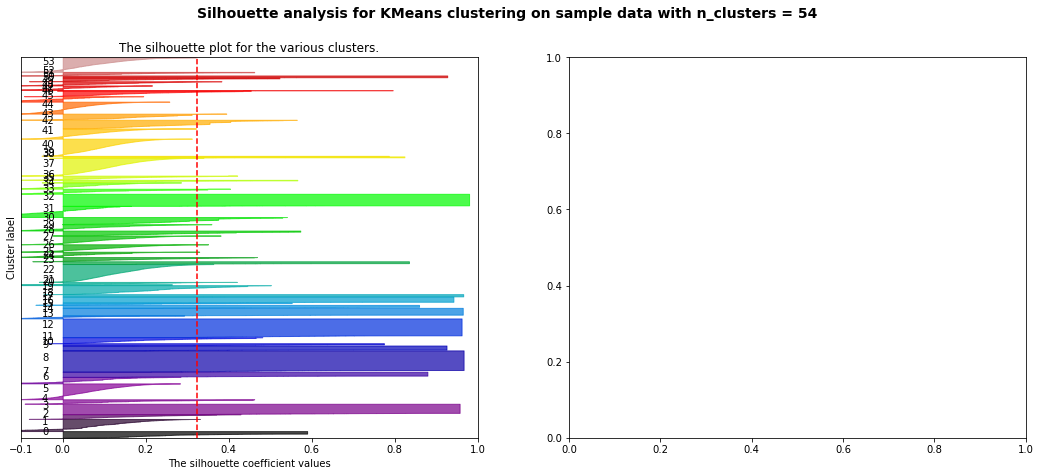

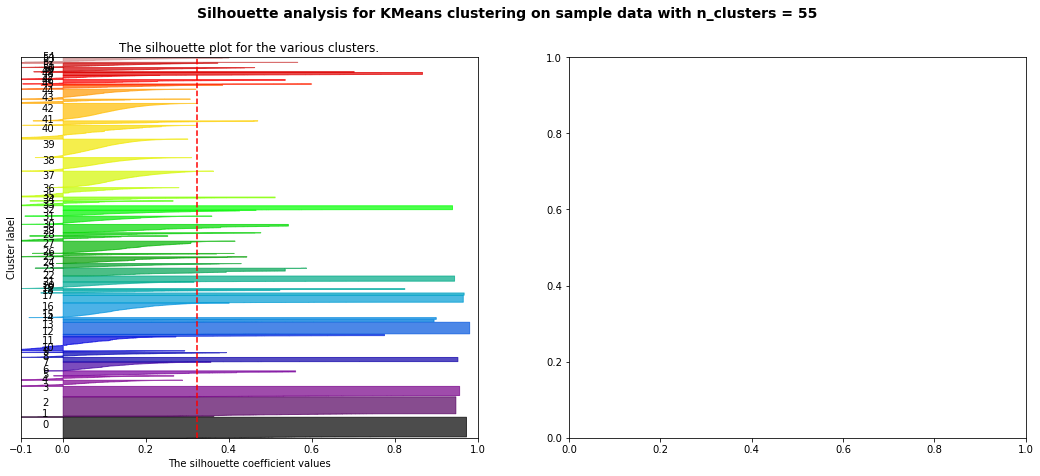

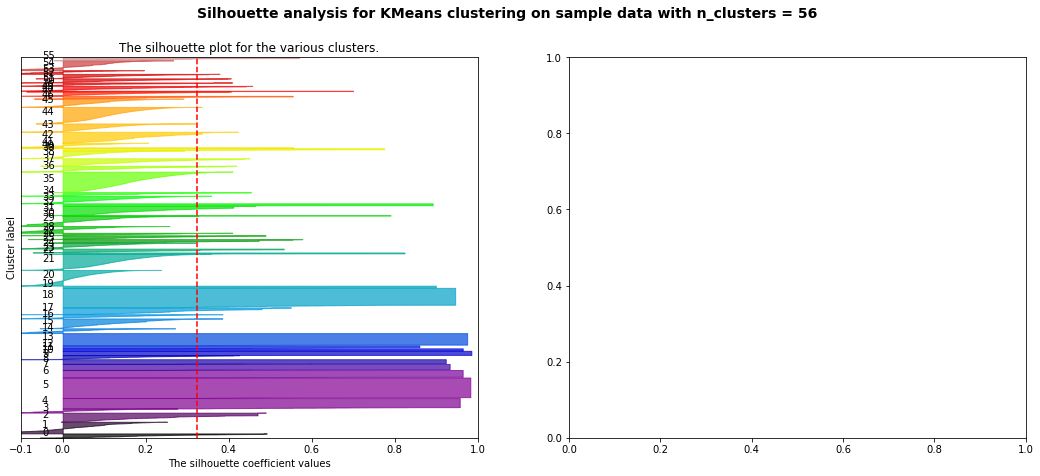

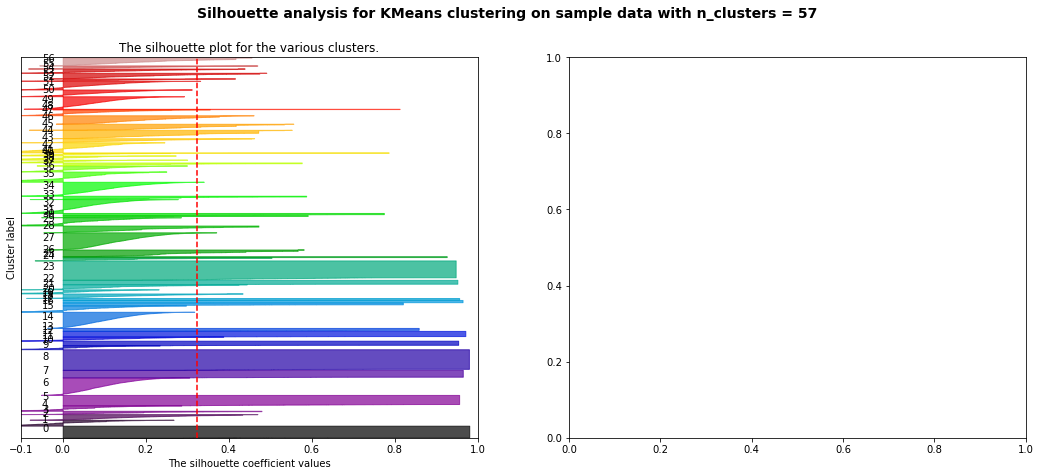

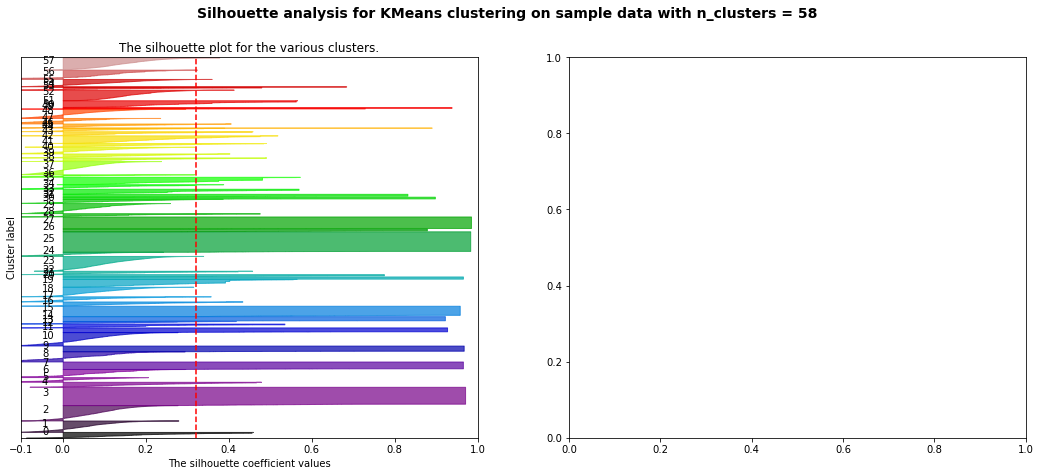

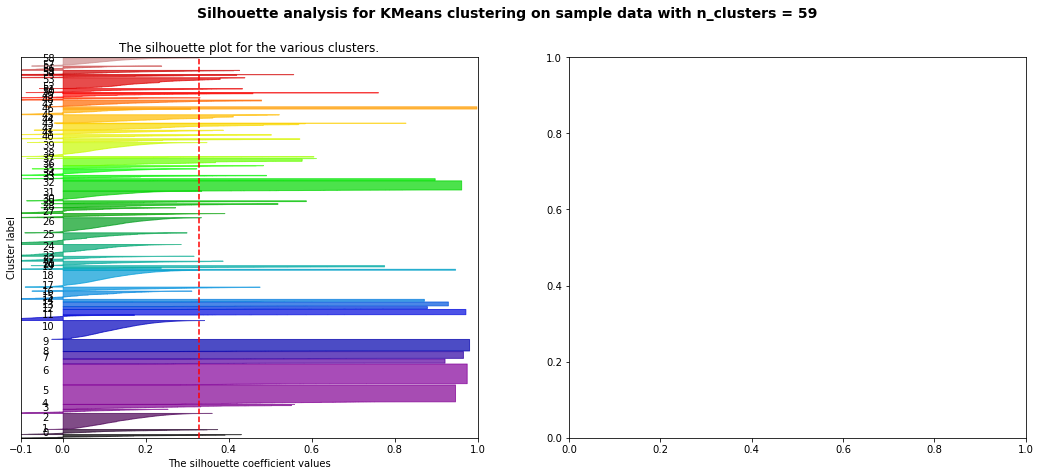

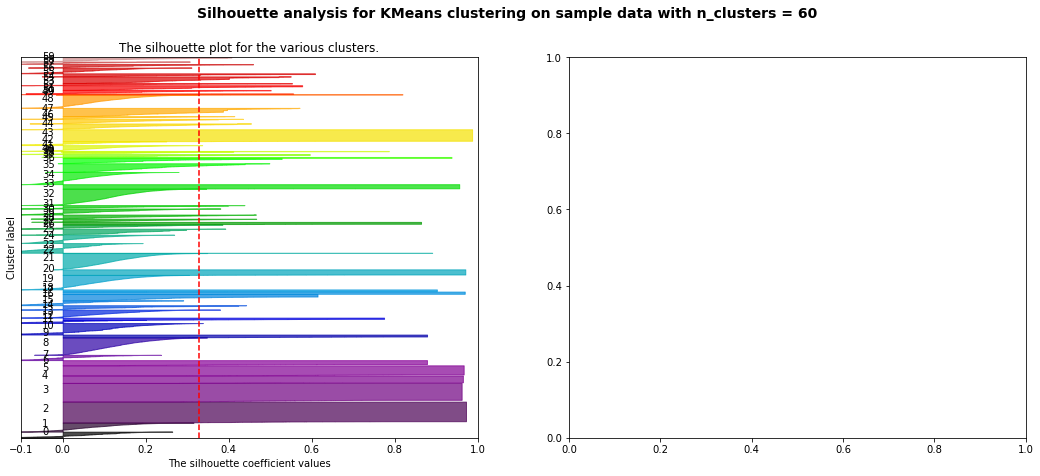

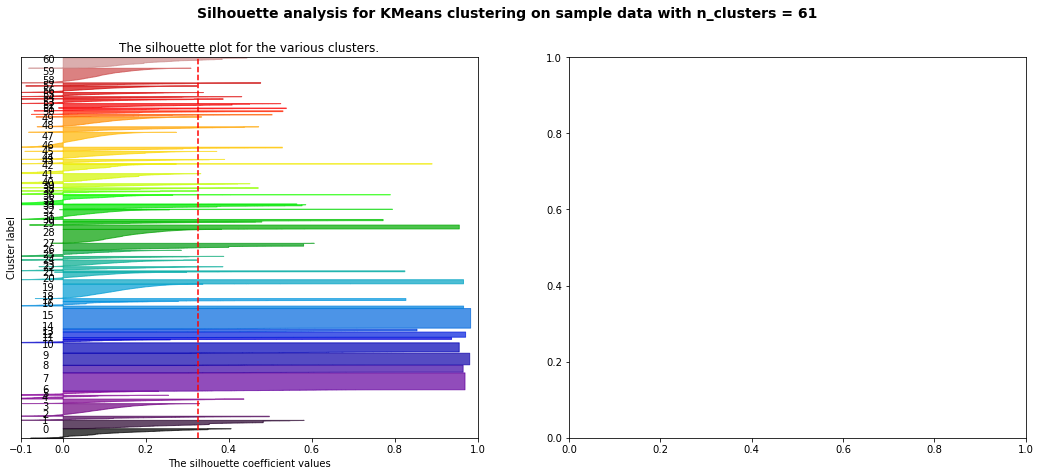

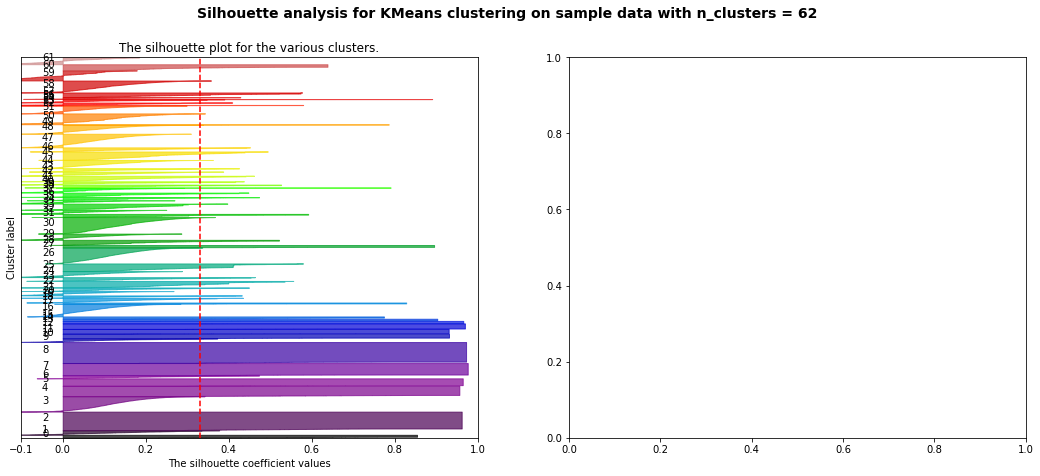

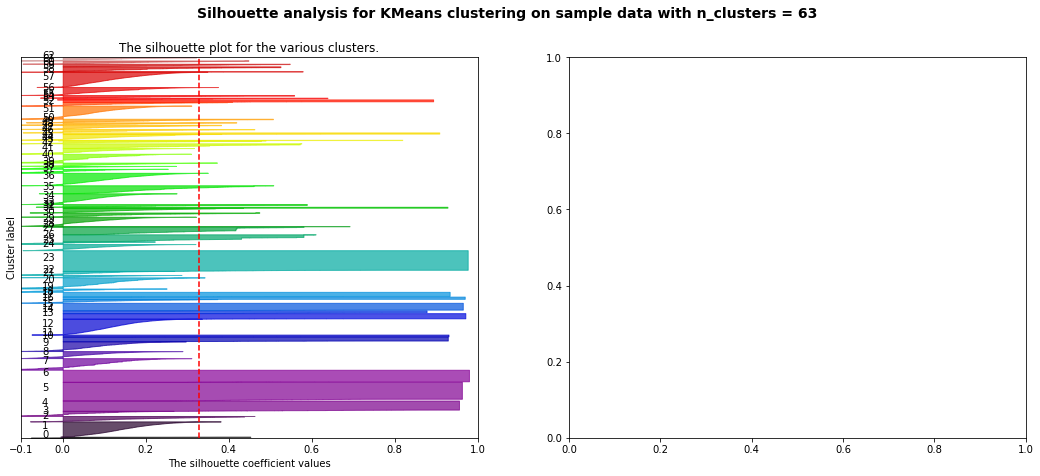

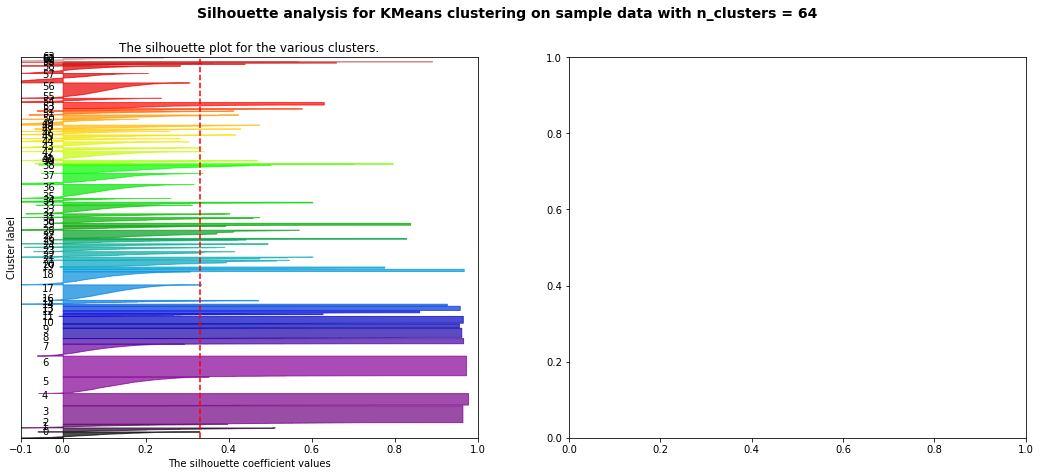

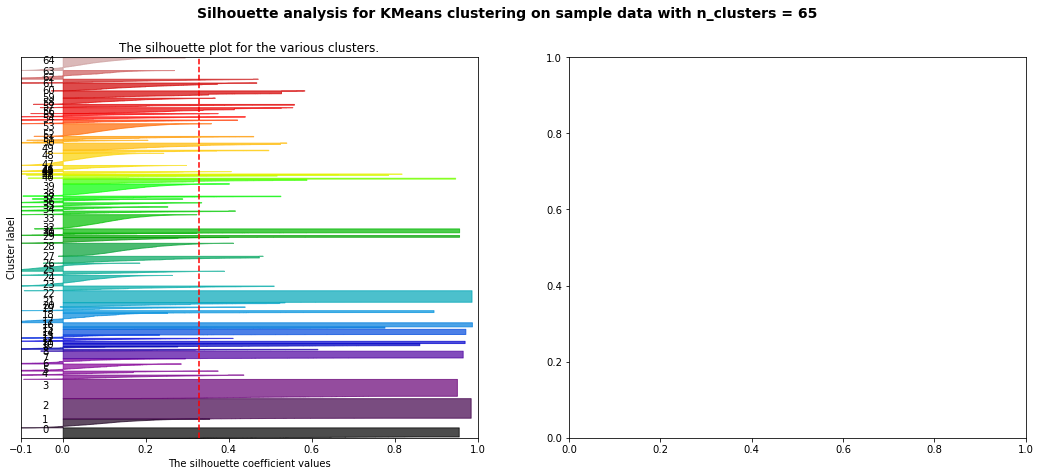

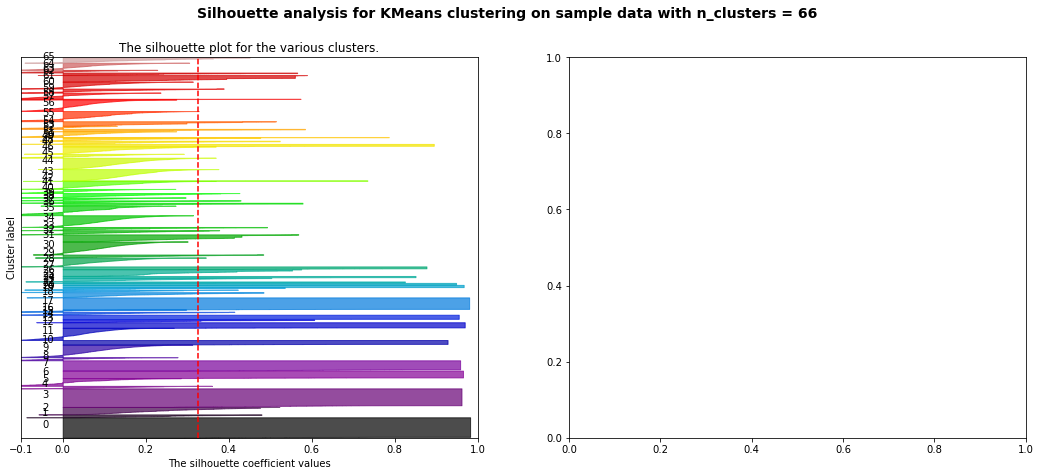

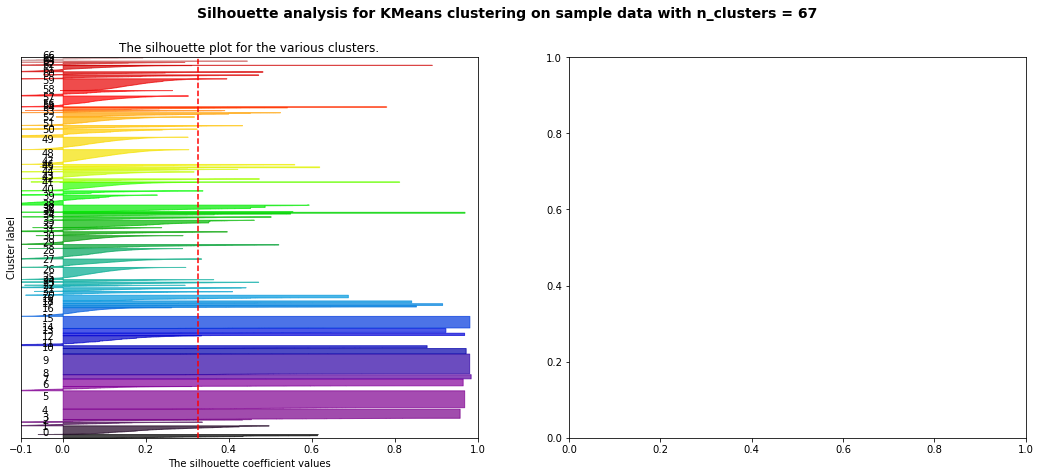

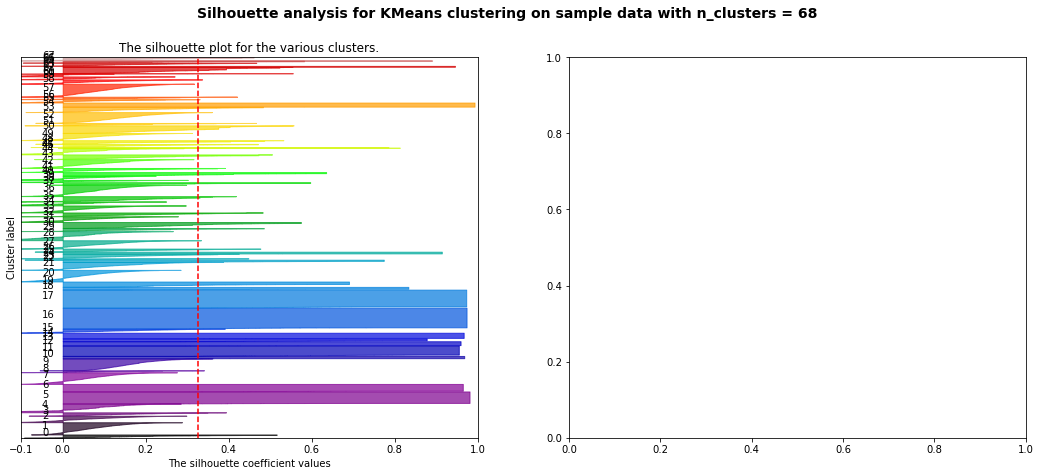

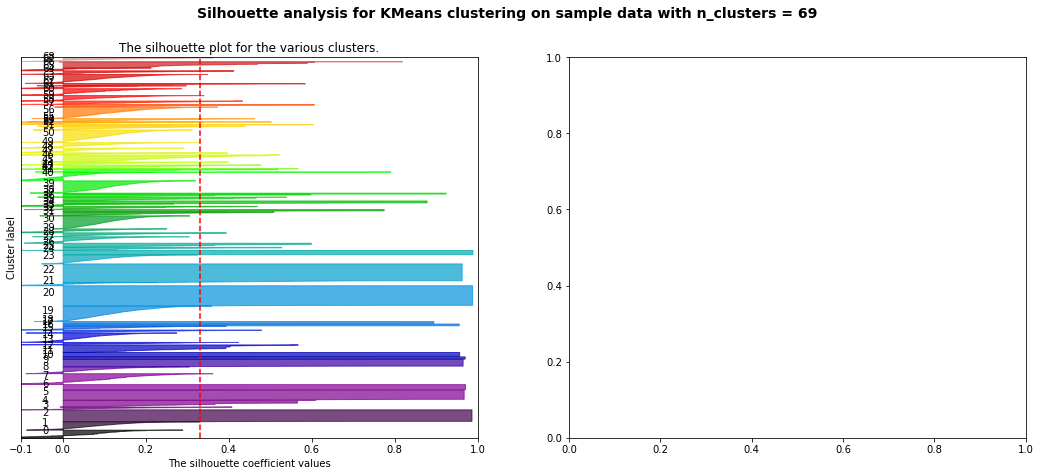

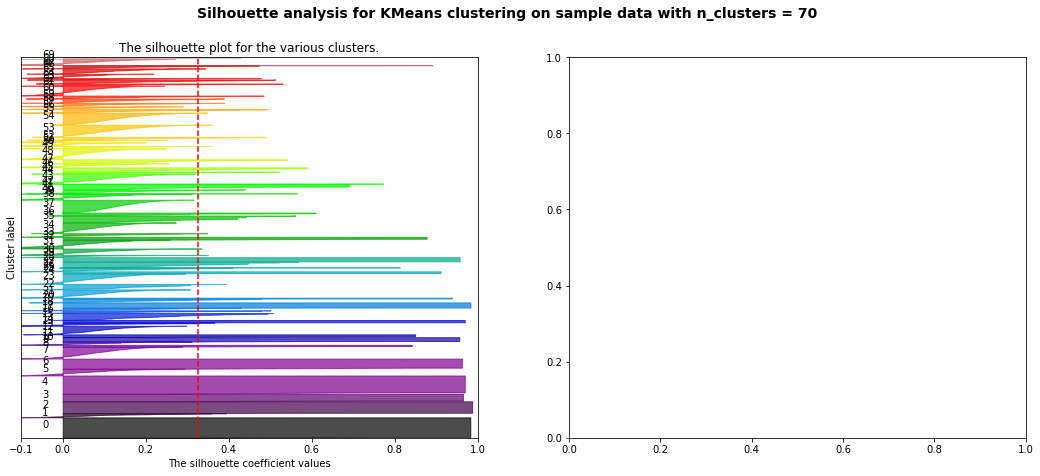

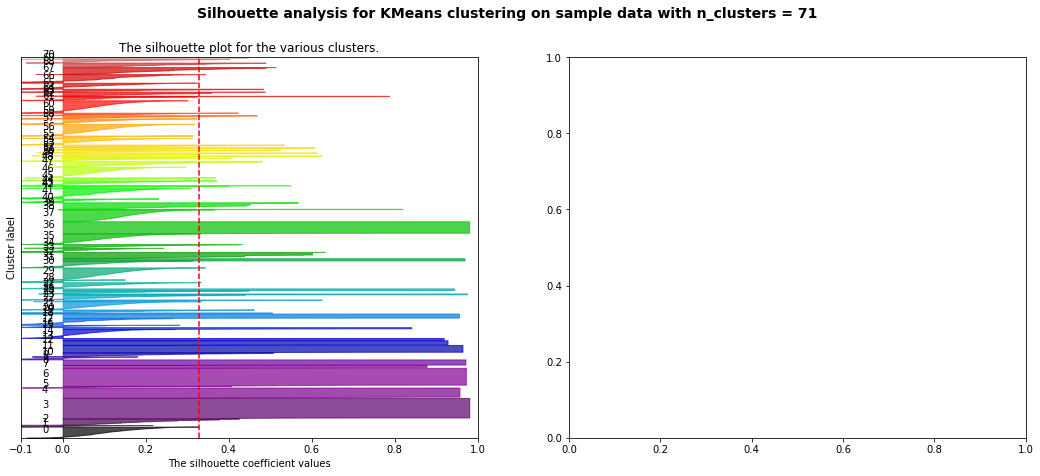

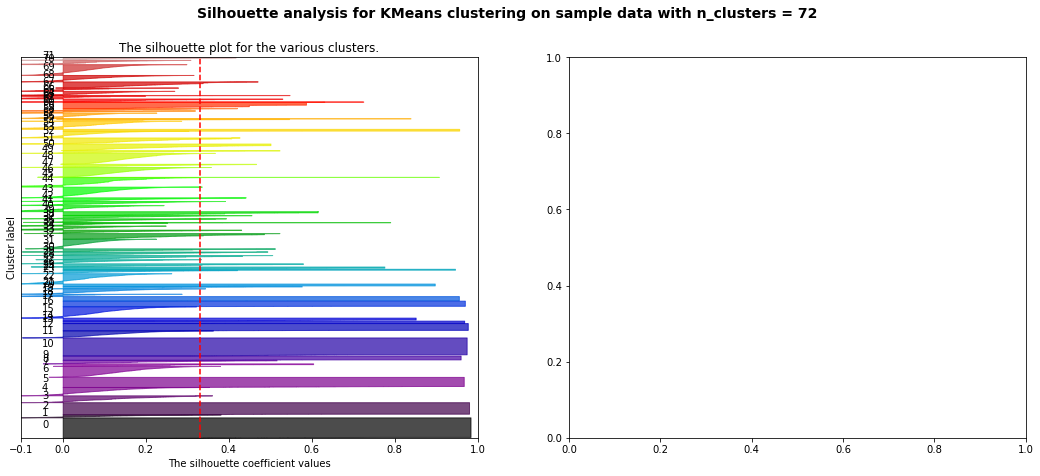

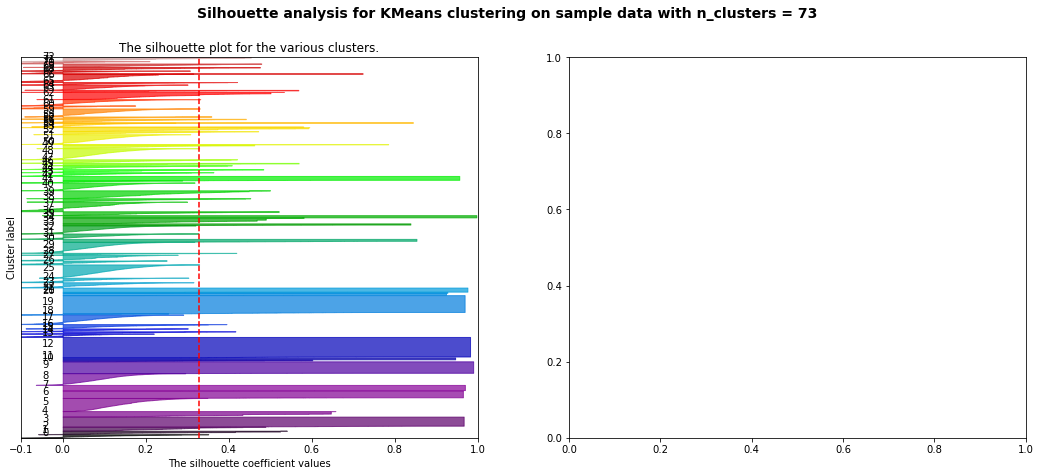

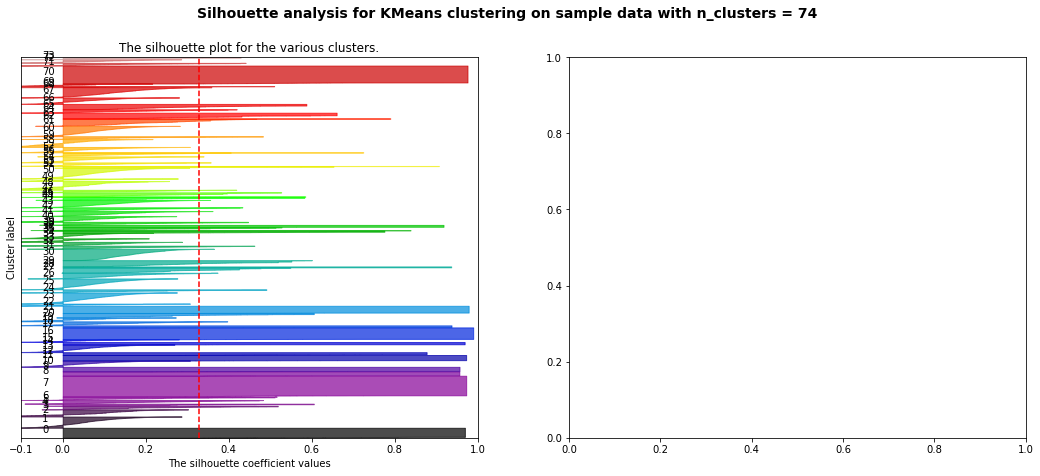

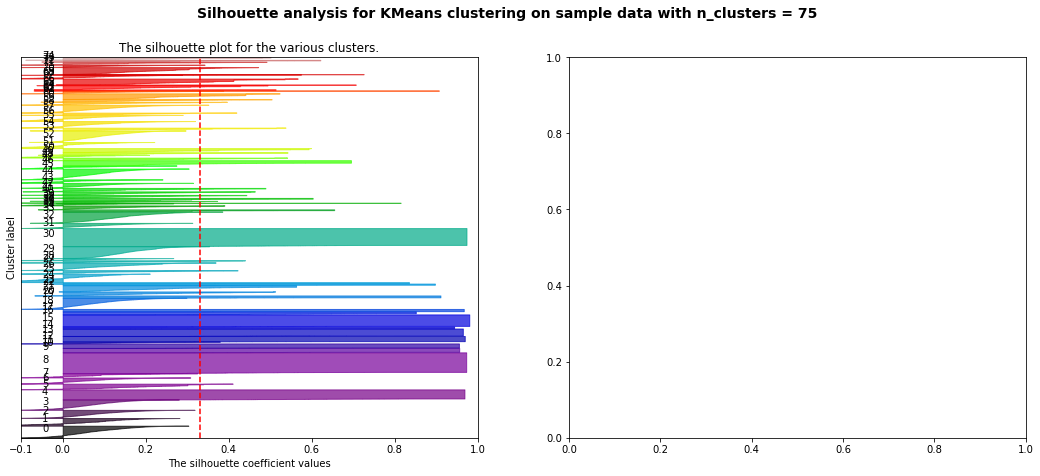

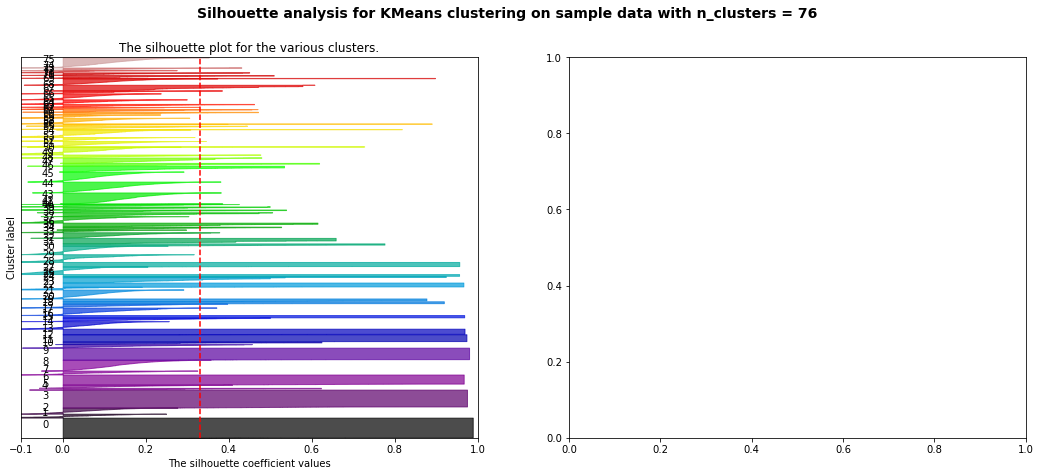

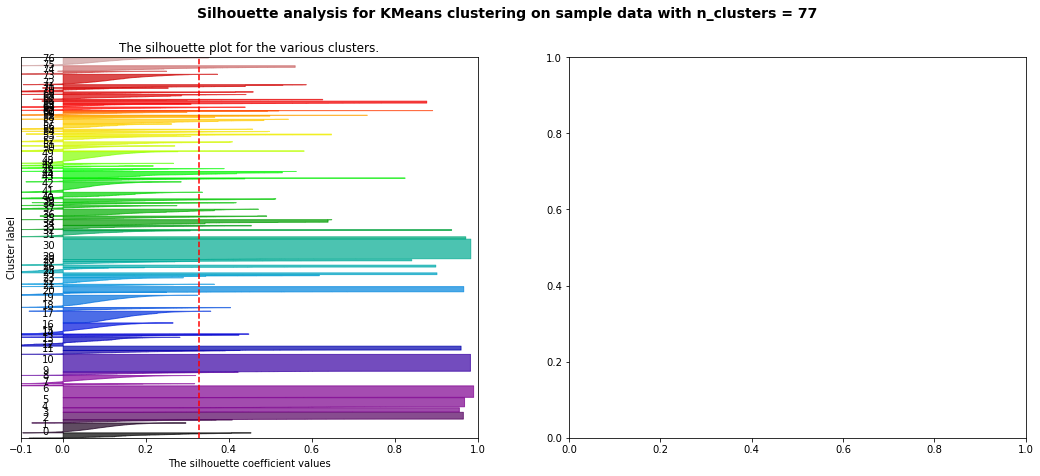

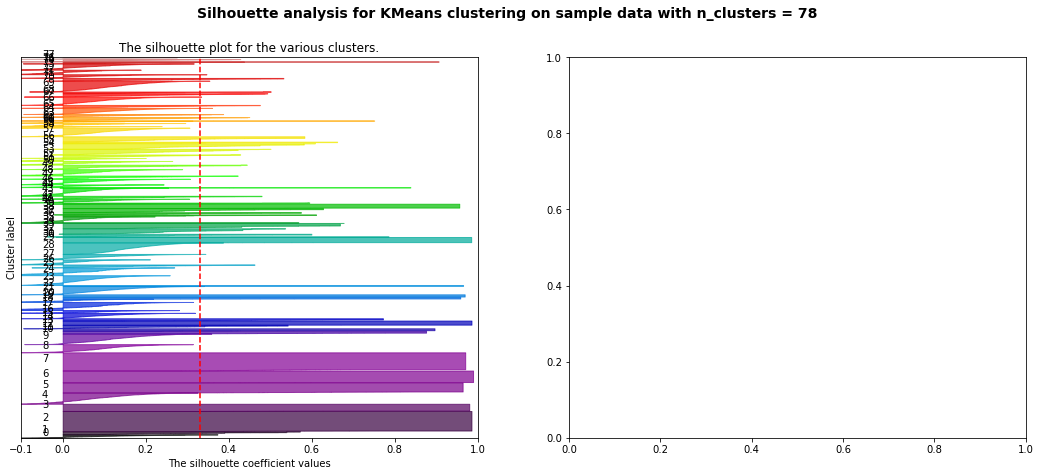

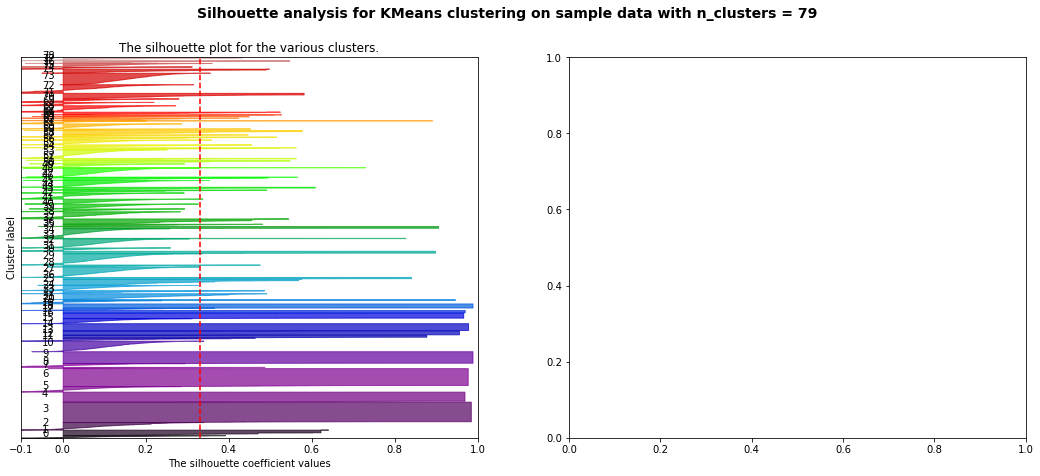

In [267]:
range_n_clusters = range(24,80)
for n_clusters in range_n_clusters:
    t0 = time.time()
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    t_elapsed = time.time() - t0
    print(n_clusters,": ",t_elapsed)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(
#         X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
#     )

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(
#         centers[:, 0],
#         centers[:, 1],
#         marker="o",
#         c="white",
#         alpha=1,
#         s=200,
#         edgecolor="k",
#     )

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    
plt.show()

**According to the result, 20 to be the best number of clusters now let's see the characteristics of each cluster**

## Parameter Selection

In [30]:
from sklearn.cluster import MiniBatchKMeans, KMeans
# run Kmeans with 20 clusters

# Initialize the clusterer with n_clusters value and a random generator
# seed of 47 for reproducibility.
customer_group_merged_np = np.array(customer_group_merged)
n_clusters = 20
clusterer = KMeans(n_clusters=n_clusters, random_state=47)
cluster_labels = clusterer.fit_predict(customer_group_merged_np)

In [31]:
pd.DataFrame(pd.Series(cluster_labels).value_counts(), columns = ['No. of customers']).T

12      17      1       19     7      4      3      2   \
No. of customers  210954  162210  138487  130539  97847  94525  88938  65457   

                     18     13     6      5      0      9      8      10  \
No. of customers  65210  55015  48676  32472  30002  29248  25433  25354   

                     16     14     15    11  
No. of customers  19923  16529  16439  9023

In [356]:
# show the summary of clustering
pd.DataFrame(pd.Series(cluster_labels).value_counts(), columns = ['No. of customers']).T

12      17      1       19     7      4      3      2   \
No. of customers  210954  162210  138487  130539  97847  94525  88938  65457   

                     18     13     6      5      0      9      8      10  \
No. of customers  65210  55015  48676  32472  30002  29248  25433  25354   

                     16     14     15    11  
No. of customers  19923  16529  16439  9023

In [ ]:
centers = pd.DataFrame(clusterer.cluster_centers_).T
centers['r'] = customer_group_merged.columns

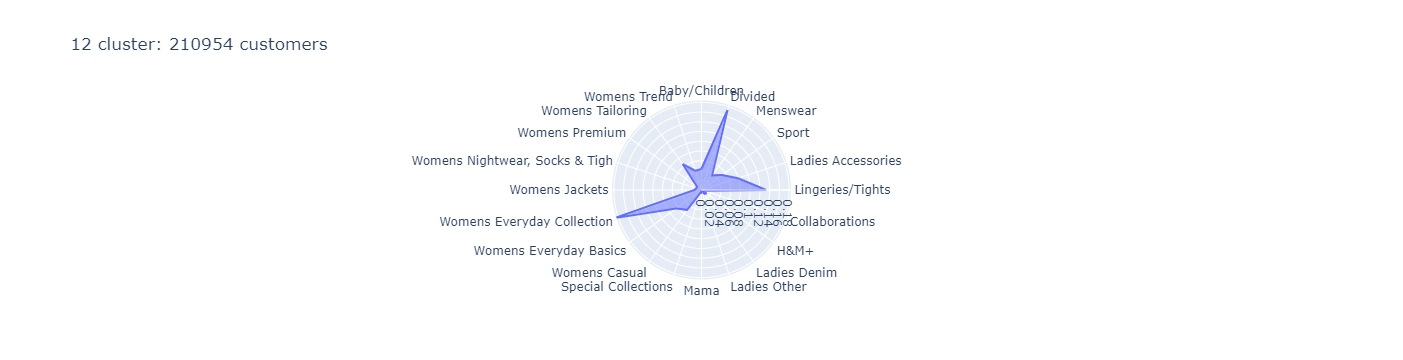

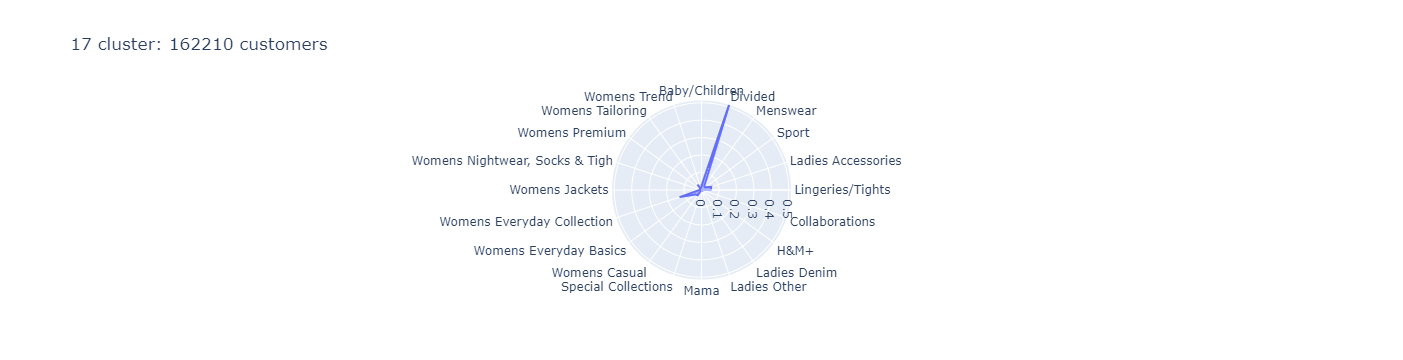

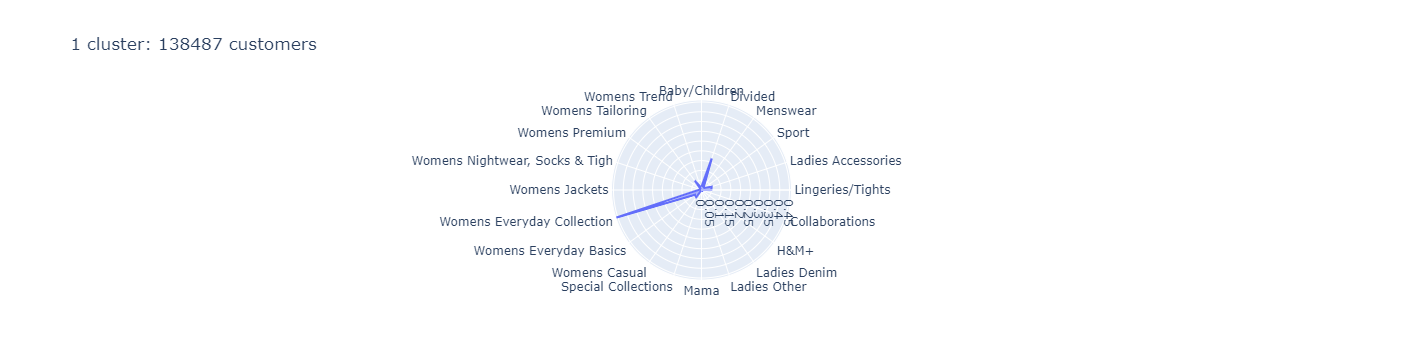

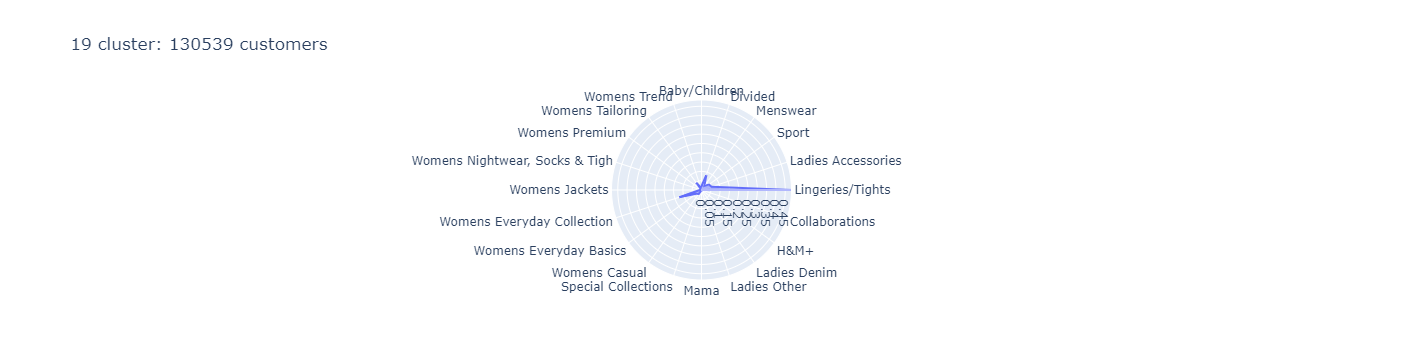

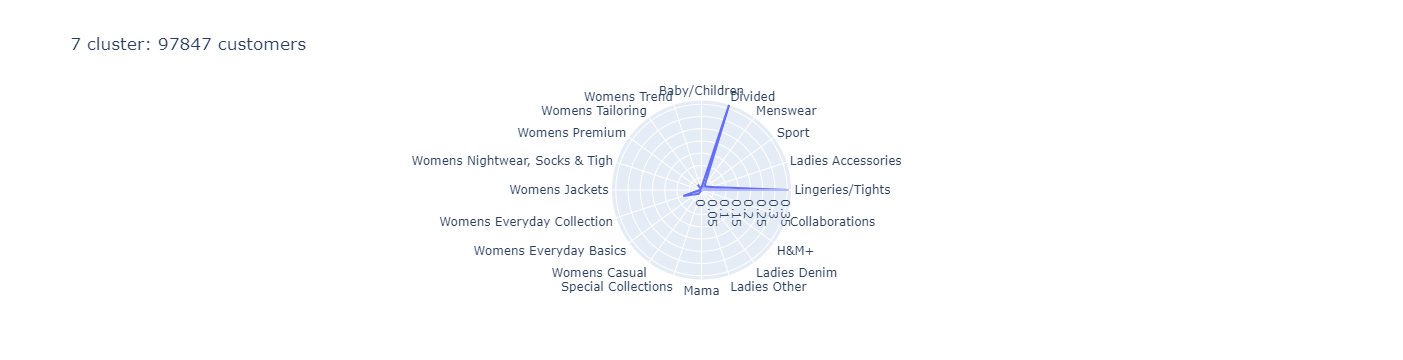

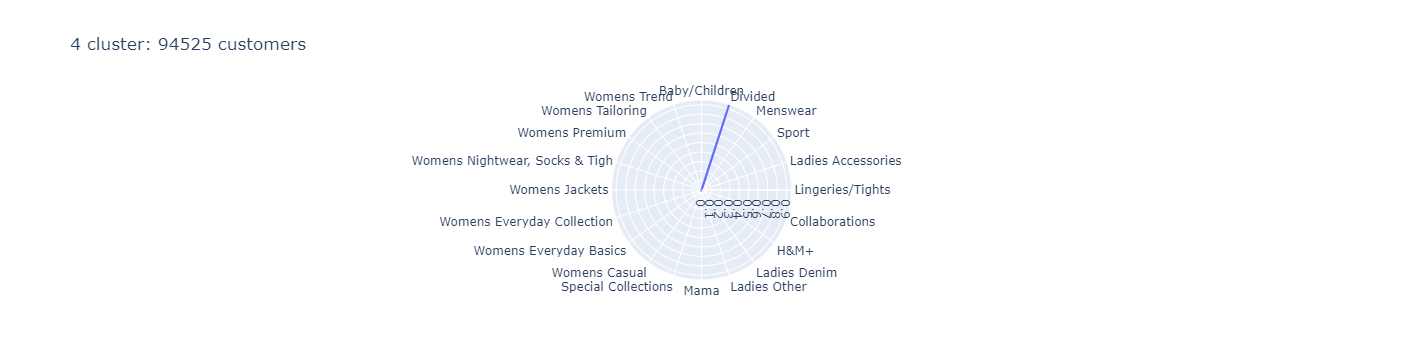

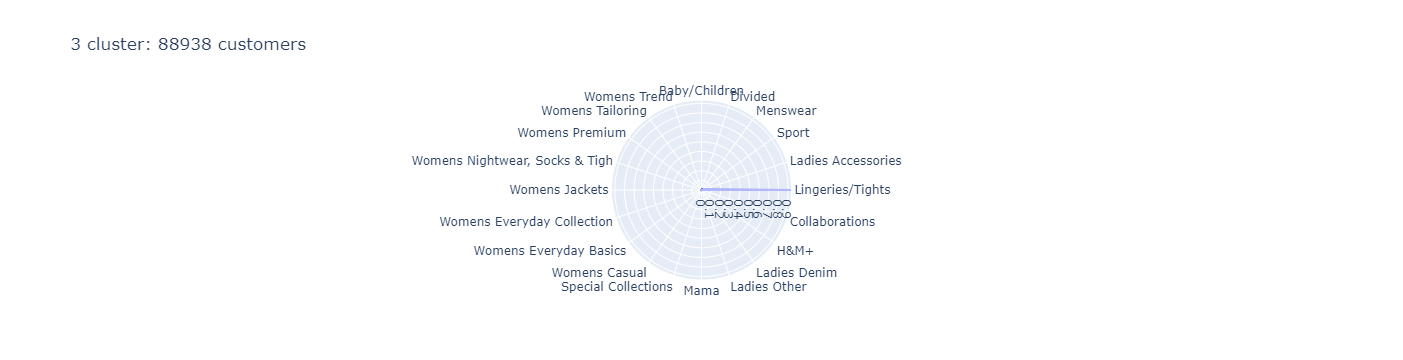

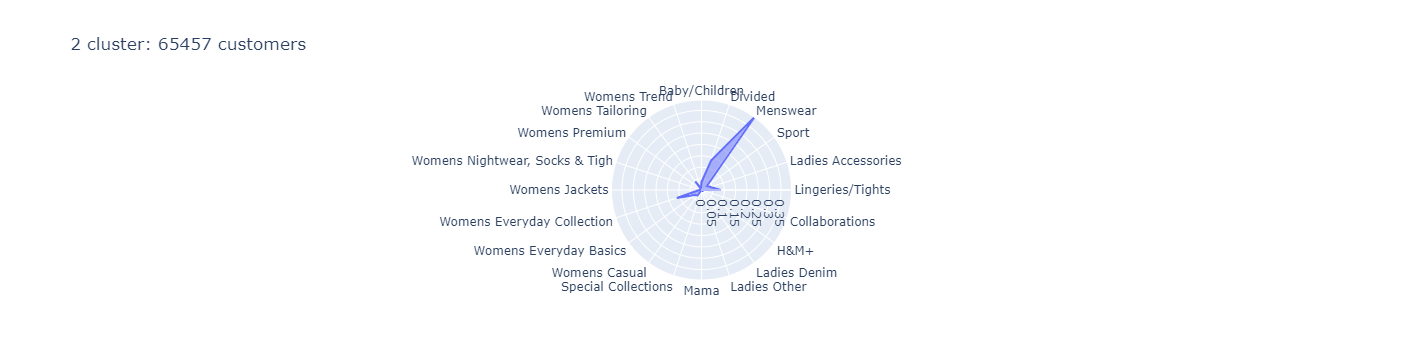

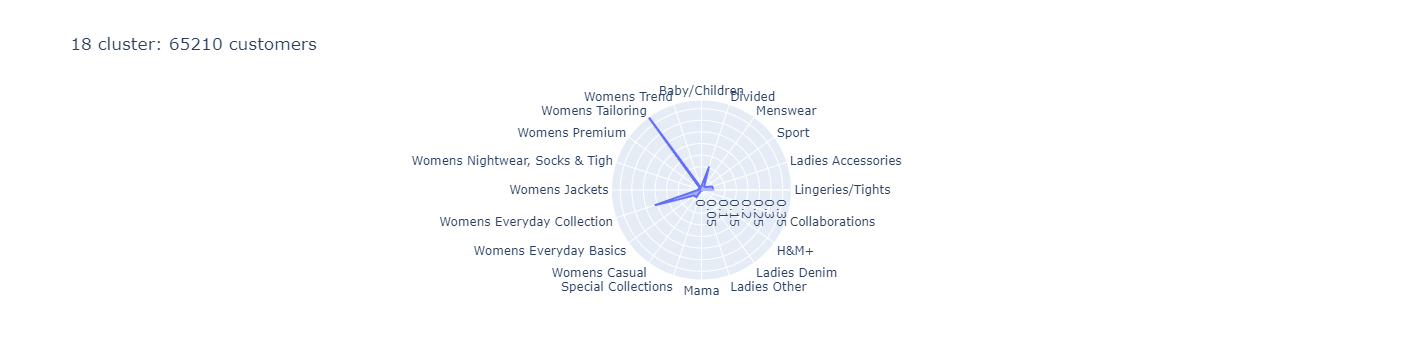

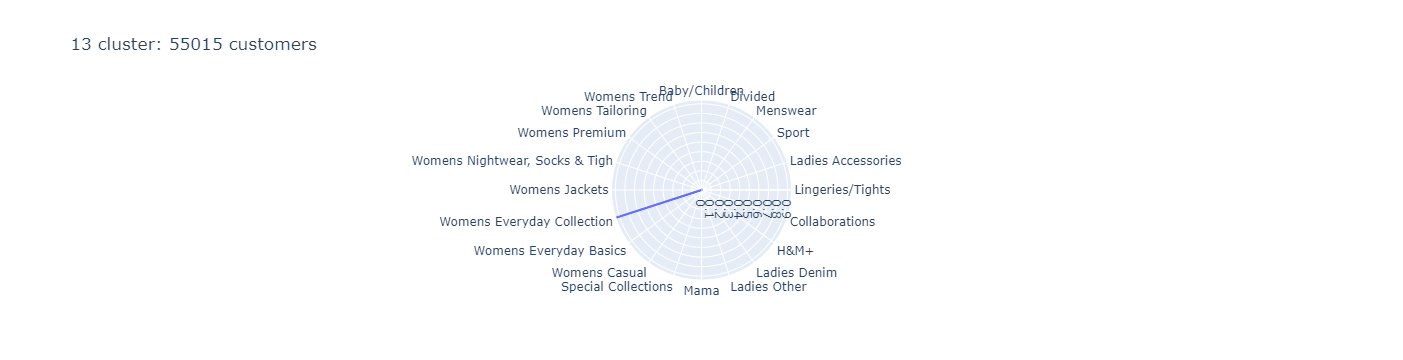

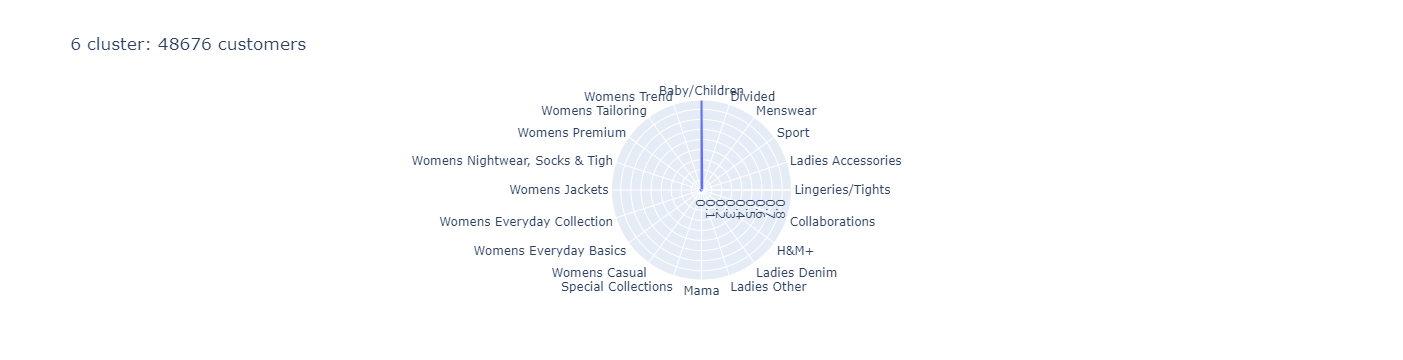

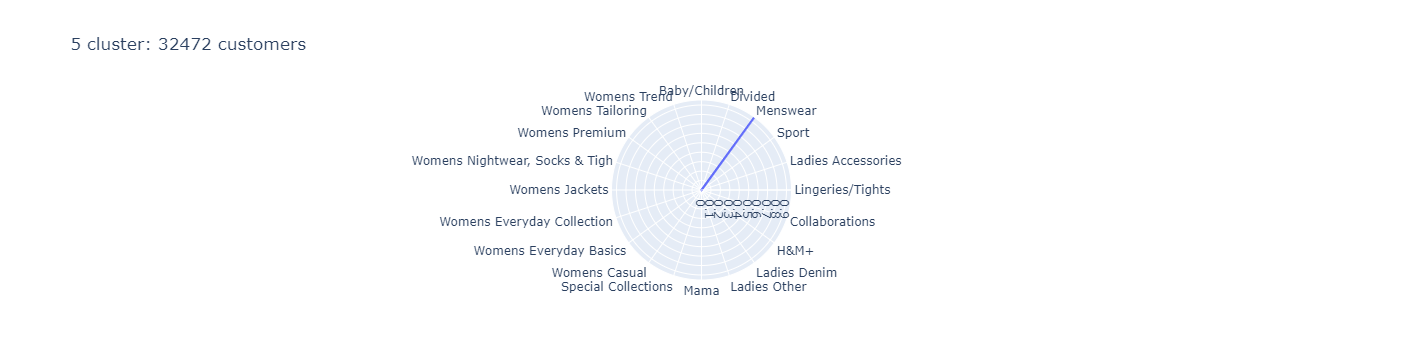

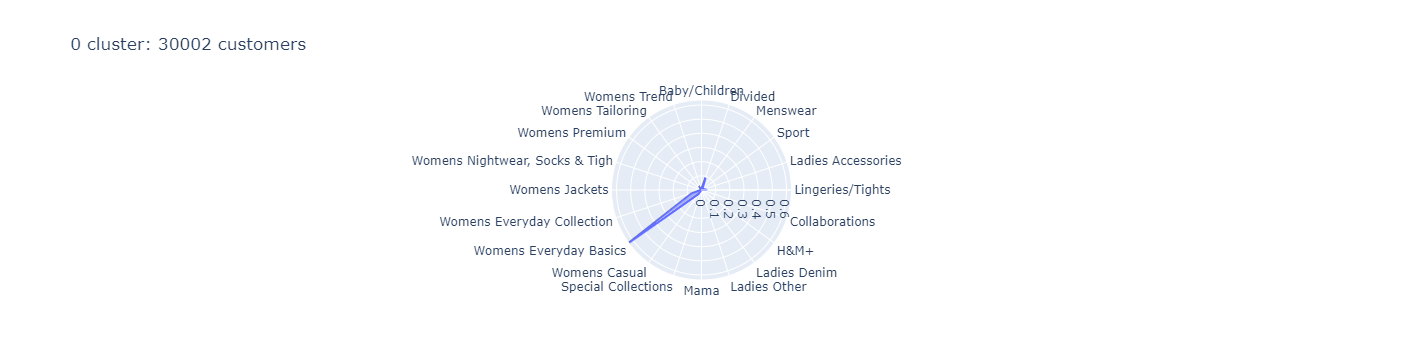

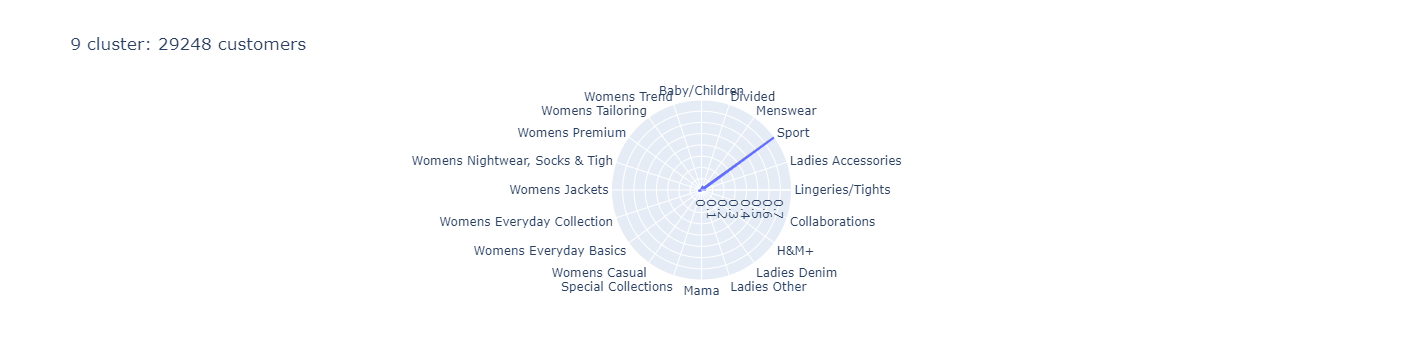

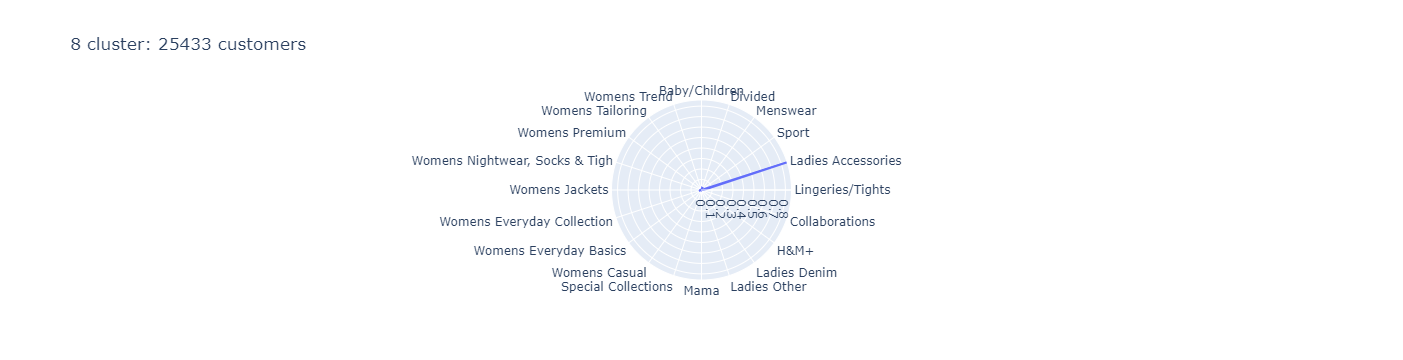

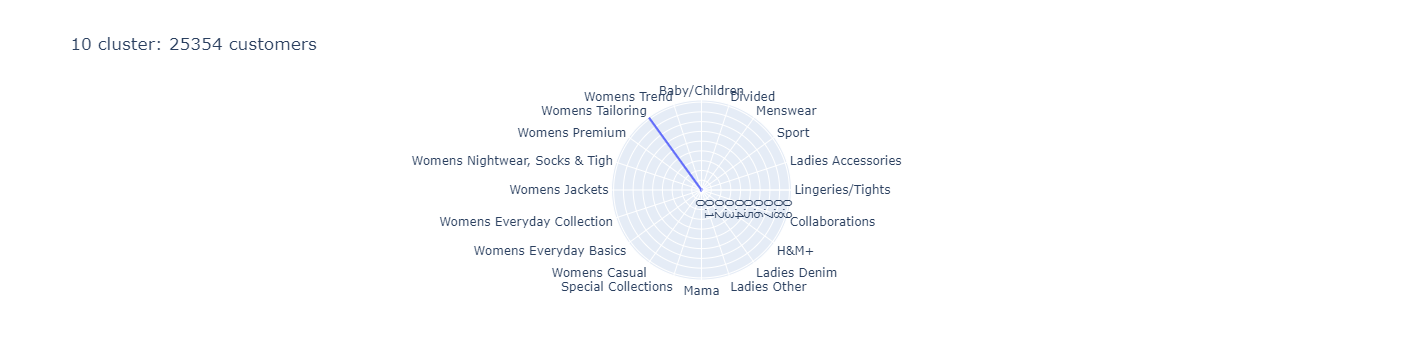

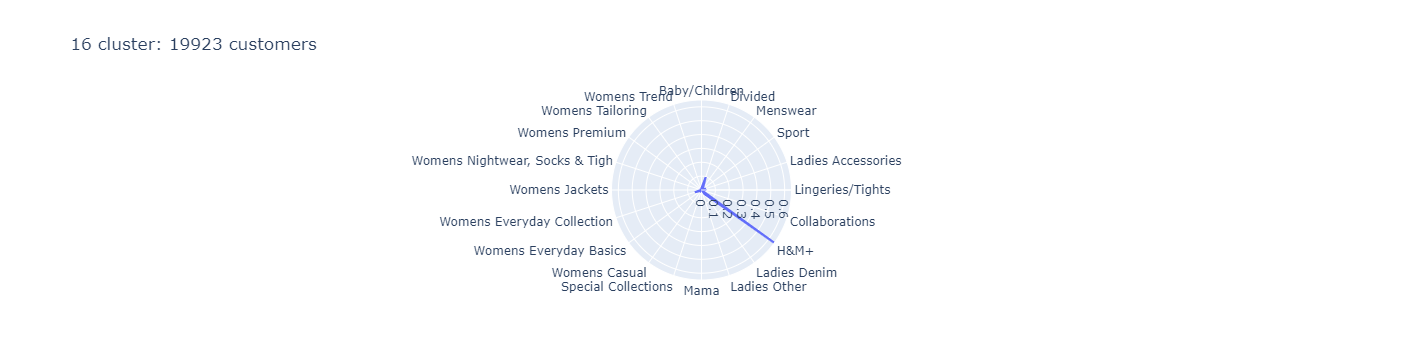

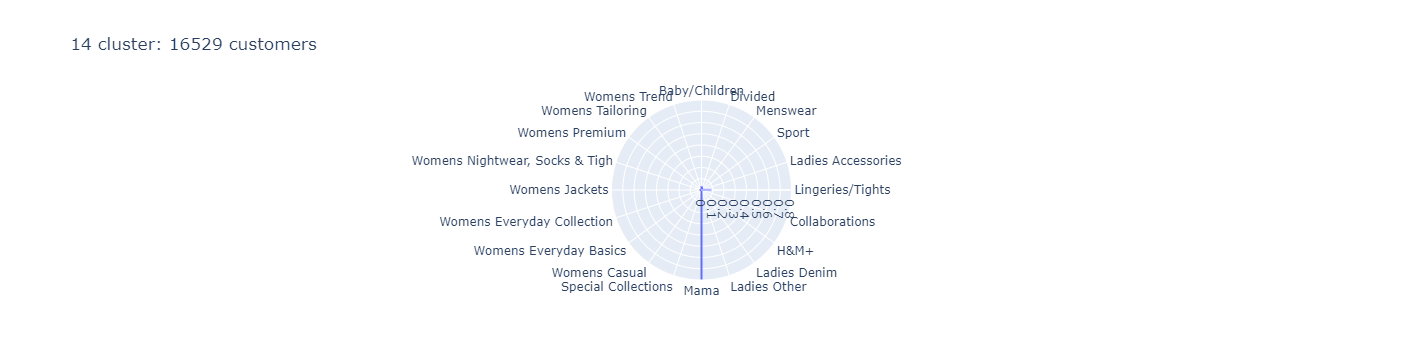

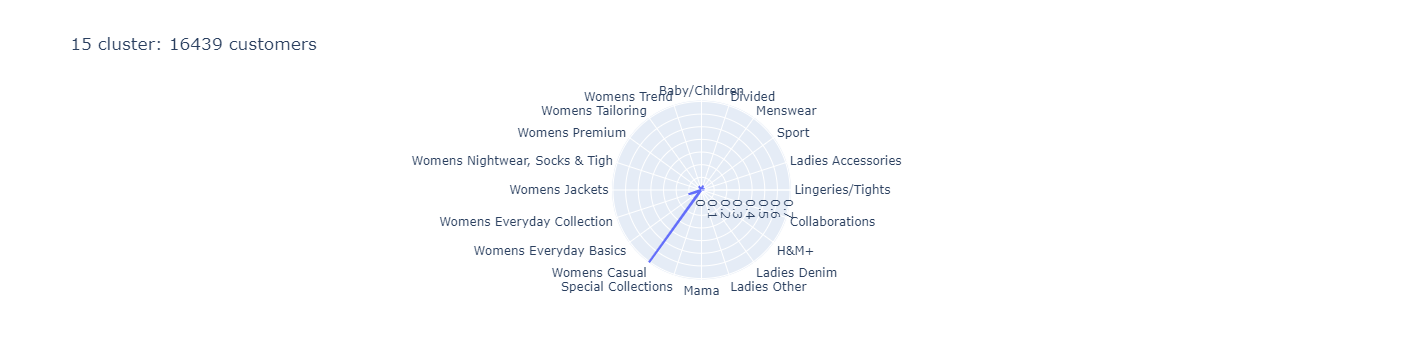

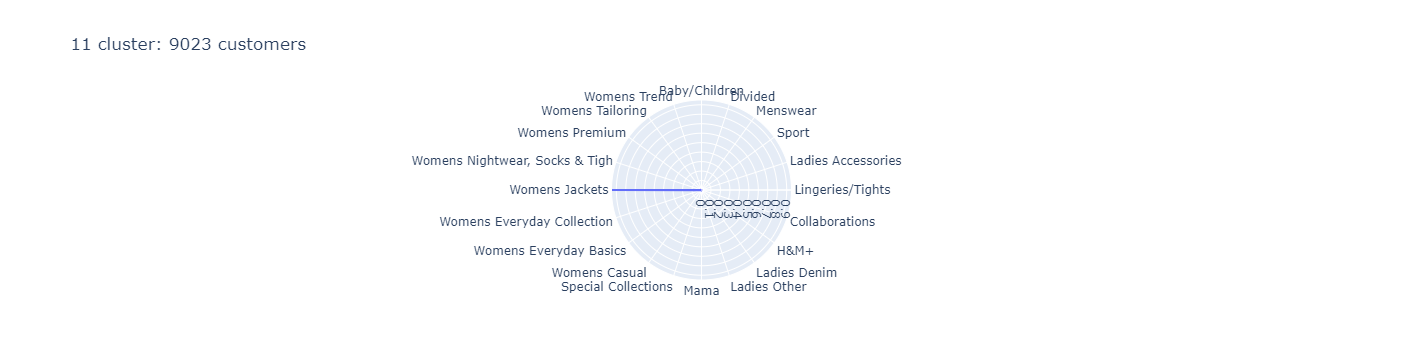

In [388]:
import plotly.express as px
cluster_order = pd.Series(cluster_labels).value_counts().iteritems()
# show the radar plot for each cluster in the order of the number of customers

for i, number in cluster_order:
    fig = px.line_polar(centers, r=i, theta='r', line_close=True,title=f'{i} cluster: {number} customers')
    fig.update_traces(fill='toself')
    fig.show()

**Though the silhoutte scores is not so high, I still see the cluster has different characteristics. (EXPLAIN MORE ABOUT EACH SEGMENT). \
I will move on to make recommendation and see if the approach works**

In [179]:
# make a df with customer_id and cluster label
df_cluster_labels = pd.DataFrame(data=cluster_labels, index=customer_group_merged.index,columns=['cluster']).reset_index()
dd_cluster_labels = dd.from_pandas(df_cluster_labels, npartitions=3)
# del df_cluster_labels

## Make Recommendation

In [33]:
transaction_with_cluster_label = transactions_merged[['t_dat','article_id','customer_id']]

In [34]:
transaction_with_cluster_label = transaction_with_cluster_label.merge(dd_cluster_labels, how='left', on = 'customer_id',suffixes=('', '_y'))

In [ ]:
transaction_with_cluster_label = transaction_with_cluster_label.drop(columns=['customer_id'])

In [44]:
transaction_with_cluster_label.info

<bound method DataFrame.info of Dask DataFrame Structure:
                         t_dat article_id customer_id cluster
npartitions=54                                               
                datetime64[ns]      int64      object   int32
                           ...        ...         ...     ...
...                        ...        ...         ...     ...
                           ...        ...         ...     ...
                           ...        ...         ...     ...
Dask Name: assign, 1046 tasks>

In [54]:
%%time
(transaction_with_cluster_label['t_dat'] <= '2018-09-21').sum().compute()

Wall time: 3min 50s


95942

In [283]:
%%time
df_recs_final = transaction_with_cluster_label[transaction_with_cluster_label['t_dat'] >= pd.to_datetime(dates.max()) - pd.DateOffset(days =3)].groupby(['cluster','article_id']).count().compute()

Wall time: 7min 23s


In [284]:
df_recs_final = df_recs_final.sort_values(['t_dat'],ascending=False).reset_index()

In [285]:
# make dictionary of recs for each cluster
dic_recs = {}
num_cluster = 20
for i in range(num_cluster):
    dic_recs[i] = ' '.join([str(a).zfill(10) for a in df_recs_final[df_recs_final['cluster'] == i].iloc[:12,1].values]) # make the list into string for formatting
dic_recs[999] = ' '.join([str(a).zfill(10) for a in df_recs_final.iloc[:12,1].values])

In [268]:
dic_recs

{0: '0610776002 0768912001 0800691007 0803757001 0778064003 0456163086 0803757004 0610776001 0778064001 0841383002 0800691008 0456163060',
 1: '0915526001 0751471043 0751471001 0915529003 0909370001 0896152002 0924243001 0918522001 0898694001 0933706001 0863595006 0915526002',
 2: '0685813001 0685814001 0685816002 0685813043 0685813037 0685814022 0685814003 0685816001 0685813042 0720504010 0685814063 0685814033',
 3: '0758034001 0611415001 0158340001 0160442007 0885951001 0160442010 0557599022 0858147001 0719655001 0819113001 0860797001 0803468002',
 4: '0706016001 0715624001 0448509014 0706016003 0706016002 0717464001 0715624010 0621381012 0914441004 0715624013 0715624053 0760084003',
 5: '0685814001 0685813001 0715255013 0685814003 0685814048 0685814022 0685813003 0720504010 0685813037 0685814063 0781758003 0685814033',
 6: '0715624010 0787946002 0831939004 0715624001 0751471001 0911214001 0685814001 0805000001 0677930086 0857347002 0750481010 0870525005',
 7: '0448509014 0706016001 

In [188]:
submission = pd.read_csv(data_path /"sample_submission.csv")

In [ ]:
# add cluster info to customer_id
# filter
## previous 7 days(need to test), cluster
# aggregate(sum)
# sort and recommend
# format: df
## columns:

In [286]:
submission = submission.merge(df_cluster_labels, how='left', on='customer_id')
submission['cluster'] = submission['cluster'].fillna(999)
submission['prediction'] = submission['cluster'].map(dic_recs)

In [287]:
submission = submission.drop(columns='cluster')

In [288]:
submission

customer_id  \
0        00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   
1        0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...   
2        000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
3        00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...   
4        00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...   
...                                                    ...   
1371975  ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...   
1371976  ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...   
1371977  ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...   
1371978  ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...   
1371979  ffffd9ac14e89946416d80e791d064701994755c3ab686...   

                                                prediction  
0        0762846027 0850917001 0762846031 0912100001 09...  
1        0158340001 0918292001 0866731001 0918522001 06...  
2        0158340001 0918292001 0866731001 0918522001 06...  
3        0866731001 0918292001 0918292004 0791587001 08...  
4        0158340001 0918292001 0866731001 0918522001 06...  
...                                                    ...  
1371975  0611415001 0855706009 0158340001 0891763001 07...  
1371976  0448509014 0874110016 0706016003 0788575004 07...  
1371977  0448509014 0874110016 0706016003 0788575004 07...  
1371978  0448509014 0714790020 0909059002 0788575002 08...  
1371979  0906372001 0898886001 0914118001 0552716001 09...  

[1371980 rows x 2 columns]

In [289]:
submission.to_csv(data_path /"submission_20_clu_3_days.csv", index=False, header=True)

In [277]:
%%time
df_temp = transaction_with_cluster_label[transaction_with_cluster_label['t_dat'] >= pd.to_datetime(dates.max()) - pd.DateOffset(days =7)].compute()
df_temp

Wall time: 7min 24s


t_dat  article_id  \
111507 2020-09-15   762063001   
111508 2020-09-15   909357001   
111509 2020-09-15   832312003   
111510 2020-09-15   826492001   
111511 2020-09-15   902161004   
...           ...         ...   
74708  2020-09-22   865917001   
74709  2020-09-22   669999001   
74710  2020-09-22   669999001   
74711  2020-09-22   788575004   
74712  2020-09-22   788575002   

                                              customer_id  cluster  
111507  001b09b8679f1efaefebab00c6d7fdeb036e2ca015605f...       12  
111508  001b09b8679f1efaefebab00c6d7fdeb036e2ca015605f...       12  
111509  03836fd3e97e3c7b499e94f17a1e507e8a3a6ab875a2d6...       12  
111510  05f8d4e14fadbb88ad9b3fb56150f5934da29e4f5ade58...        2  
111511  0788ff167c39344f1d487c23ea24df71927e1b8d69e3a9...        7  
...                                                   ...      ...  
74708   fddb1df1284df3c4e623c0e9fac1ba8e7ba631cd84a0fd...       12  
74709   febcfe62c04f9516ee7ce0cd2b76f6608a1204efb9a6dd...       12  
74710   febcfe62c04f9516ee7ce0cd2b76f6608a1204efb9a6dd...       12  
74711   febcfe62c04f9516ee7ce0cd2b76f6608a1204efb9a6dd...       12  
74712   febcfe62c04f9516ee7ce0cd2b76f6608a1204efb9a6dd...       12  

[266364 rows x 4 columns]

In [282]:
df_temp.t_dat.unique()

array(['2020-09-15T00:00:00.000000000', '2020-09-16T00:00:00.000000000',
       '2020-09-17T00:00:00.000000000', '2020-09-18T00:00:00.000000000',
       '2020-09-19T00:00:00.000000000', '2020-09-20T00:00:00.000000000',
       '2020-09-21T00:00:00.000000000', '2020-09-22T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [290]:
df_recs_final.t_dat.unique()

array([140, 135, 133, 130, 119, 115, 110, 109, 107, 106,  99,  98,  97,
        93,  92,  91,  90,  89,  88,  87,  86,  85,  84,  82,  78,  77,
        76,  75,  74,  73,  72,  71,  68,  67,  66,  65,  64,  63,  62,
        61,  60,  59,  58,  57,  56,  55,  53,  51,  50,  49,  48,  47,
        46,  45,  44,  43,  42,  41,  40,  39,  38,  37,  36,  35,  34,
        33,  32,  31,  30,  29,  28,  27,  26,  25,  24,  23,  22,  21,
        20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,   9,   8,
         7,   6,   5,   4,   3,   2,   1], dtype=int64)